In [1]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from torch.distributions import Normal, Independent, kl_divergence 
from collections import namedtuple
from math import e, cos, sin, pi, atan2, asin, sqrt, tan

### Quadrotor Dynamical Data Generator

In [2]:
class Quadrotor_Dynamics_Generator():

  def __init__(self,
               x_size=26,
               y_size=12,
               traj_length=2,
               normalize=True,
               xy_offset=20,
               min_Z=0,
               max_Z=50,
               xydot_offset=60.0,
               min_Zdot = -30,
               max_Zdot = 30,
               min_accel_xy = -30,
               max_accel_xy = 30,
               min_accel_z = -30,
               max_accel_z = 30, 
               min_omega=-80,
               max_omega=80,
               min_omegadot=-80,
               max_omegadot=80,
               min_rp = -pi/2 + 0.1,
               max_rp = pi/2 - 0.1,
               min_rotor_rps = 0,
               max_rotor_rps = 1000,
               perturb_rps=10,
               ground_effect=False,
               wind_vel_offset = 25,
               Z_thresh=2,
               quad_mass=20
              ):

    self.x_size = x_size
    self.y_size = y_size
    self.traj_length = traj_length
    self.normalize = normalize
    self.xy_offset = xy_offset
    self.min_Z = min_Z
    self.max_Z = max_Z
    self.xydot_offset = xydot_offset

    self.min_rp = min_rp
    self.max_rp = max_rp
    self.min_rotor_bound = min_rotor_rps
    self.max_rotor_bound = max_rotor_rps
    self.perturb_rps = perturb_rps
    self.ground_effect = ground_effect
    self.Z_thresh = Z_thresh
    self.m = quad_mass
    self.constants = self.constants_init()

    # Initialize minmax data needed for relavent simulation parameters
    self.minmax_data = torch.tensor([[0, 0], #dt
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [min_Zdot, max_Zdot],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_z, max_accel_z],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot]])
    

  # Evolves the dynamics of quadrotor
  def eqn_mtn(self, state_vec, uu, dt, V_w, rotor_disturbances=False, rotor_spike_bound=100, linvel_offset=torch.zeros([3,]), angvel_offset=torch.zeros([3,])):

    ########     NESTED FUNCTION     ########

    # Verify boundness of Euler angles
    def theta_check(theta):
      # Parsing euler angles
      roll = theta[0]
      pitch = theta[1]
      yaw = theta[2]

      # Ensuring euler angles remain within [-pi, pi]
      roll_offset = torch.abs(torch.floor(roll / (2*pi)))
      pitch_offset = torch.abs(torch.floor(pitch / (2*pi)))
      yaw_offset = torch.abs(torch.floor(yaw / (2*pi)))

      if roll > pi:
        roll -= roll_offset * (2*pi)
      elif roll < -pi:
        roll += roll_offset * (2*pi)

      if pitch > pi:
        pitch -= pitch_offset * (2*pi)
      elif pitch < -pi:
        pitch += pitch_offset * (2*pi)

      if yaw > pi:
        yaw -= yaw_offset * (2*pi)
      elif yaw < -pi:
        yaw += yaw_offset * (2*pi)

      theta_transformed = torch.tensor([roll, pitch, yaw])
      return theta_transformed
    
    ###########   END OF NESTED FUNCTION   ###########
    
    # Parsing positional and velocity states
    x = state_vec[:3]
    theta = state_vec[3:6]
    xdot = state_vec[6:9]
    thetadot = state_vec[9:12]
    omega = state_vec[12:15]
    omegadot = state_vec[15:18]
    a = state_vec[18:]
    
    # Checking if current altitude is at ground effect threshold  
    if x[2] <= 2 and x[2] > 0:
      self.ground_effect = True
    else:
      self.ground_effect = False  
      
    print(f'EQN_MTN BEFORE: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}')


    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']


    # Incorporating rotor spiking (if applicable)
    if rotor_disturbances == True:
      uu_observed = uu.clone()
      uu = self.perturb_rv(uu_observed, rotor_spike_bound=rotor_spike_bound)

    # Integrating body rates
    omega = omega + dt * omegadot

    # Ensuring commanded velocities keep quadrotor within defined state space
    if linvel_offset.any():
      xdot = linvel_offset
    else:
      xdot = xdot + dt * a
      
    if angvel_offset.any():
      thetadot = angvel_offset
    else: 
      thetadot = self.omega2thetadot(omega, theta)

    # Integrating positional states
    theta = theta + dt * thetadot
    x = x + dt * xdot

    # Ensuring euler angles lie within appropriate bounds
    theta = theta_check(theta)
    
    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates from updated euler data
    omega = self.thetadot2omega(thetadot, theta)
    
    # Computing forces and moments from external perturbations
    V_w, F_w = self.inject_wind_peturb(V_w, dt)
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(z=x[2],z_thresh=2)
    else:
      Fg = torch.zeros_like(F_bf)

    # Computing exogenous disturbances
    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    
    # Compute linear and angular accelerations.
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, F_aero, prev_a=a)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero, prev_ωdot=omegadot)

    # Updating state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)
    print(f'EQN_MTN AFTER: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}, V_w: {V_w}')
    
    return state_vec, V_w, F_aero, tau_aero
  
  ####   QUADROTOR PHYSICS FUNCTIONS   ####
  
  # Compute translational accelerations
  def acceleration(self, inputs, angles, xdot, m, g, kf, kd, F_aero, prev_a=torch.zeros([3,])):
    gravity = torch.tensor([0,0,-g])
    R = self.rotation(angles)
    T = R @ self.thrust(inputs, kf)
    Fd = -kd * xdot
    a = gravity + (1/m) * (T + Fd + F_aero) - kd * prev_a
    return a

  # Compute angular accelerations
  def angular_acceleration(self, inputs, omega, I, I_r, L, b, km, tau_aero, prev_ωdot=torch.zeros([3,])):
    tau_m = self.motor_torques(inputs, L, b, km)
    tau_g = self.gyroscopic_torques(inputs, omega, I_r)
    
    #print(f'tau_m: {tau_m}, tau_aero: {tau_aero}, tau_g: {tau_g}\n')
    tau = (tau_m + tau_aero - tau_g)
    omegadot = torch.inverse(I) @ (tau - torch.linalg.cross(omega, I @ omega)) - km * prev_ωdot
    return omegadot
  
  # Compute torques, given current inputs, length of arm, drag coefficient, and moment coefficient.
  def motor_torques(self, inputs, L, b, km):
    # Inputs are values for ${\omega_i}^2$
    tau = torch.tensor([
        L * km * (inputs[0] - inputs[2]),
        L * km * (inputs[1] - inputs[3]),
        b * (inputs[0] - inputs[1] + inputs[2] - inputs[3])
    ])
    return tau
  
  # Compute thrust given current inputs and thrust coefficient.
  def thrust(self, inputs, kf):
    # Inputs are values for ${\omega_i}^2$
    T = torch.tensor([0, 0, kf * torch.sum(inputs)])
    return T

  # Compute gyroscopic torques on quadrotor
  def gyroscopic_torques(self, inputs, omega, I_r):
    # Parsing body rates
    pp = omega[0]
    qq = omega[1]
    
    # Untransforming squared inputs
    inputs = torch.sqrt(inputs)
    
    # Computing gyroscopic torques
    tau_g = torch.zeros([3,])
    tau_g[0] = I_r*qq*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    tau_g[1] = -I_r*pp*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    
    return tau_g

  ####    END OF PHYSICS FUNCTIONS     ####


  ####  PERTURBATION/NOISE FUNCTIONS   ####

  def perturb_rv(self, uu, rotor_spike_bound=100):

    # High: perturb_rps minmax = -100, 100
    # Medium: perturb_rps_minmax = -50, 50

    max_rotor_perturb_rps = rotor_spike_bound
    min_rotor_perturb_rps = -rotor_spike_bound
    
    # Sampling rotor spiking values
    dω1 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω2 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω3 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω4 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    
    # Applying spiking values to rotor velocities
    uu[0] += dω1
    uu[1] += dω2
    uu[2] += dω3
    uu[3] += dω4

     # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    return uu
  
  def model_rotor_vels(self, uu, noise_bias=10, noise_std=15):
    
    # Sampling noise vector to perturb rotor velocities in realistic manner
    noise_uu = torch.normal(mean=torch.tensor(noise_bias), std=torch.tensor(noise_std), size=[4,])
    
    # Applying noise to rotor velocities
    uu += noise_uu
    
    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    # Applying quantization step
    uu = torch.round(uu)
    
    return uu


  def compute_rotor_linvels(self, xdot, theta, omega, d_array, V_w):
    # VECTORIZE
    
    # Computing rotation matrix for  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing rotor linear velocities for each rotor
    Vr_array = torch.zeros([4,3])
    for rotor in range(4):
      Vr_array[rotor,:] = R.T @ (xdot - V_w) + torch.linalg.cross(omega, d_array[rotor,:])
    
    return Vr_array
    

  def inject_blade_flapping_force(self, theta, uu, Vr_array):
    # VECTORIZE
    
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Ca = 5e-4
    Cb = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of blade flapping forces coming from all rotors
    F_bf = torch.zeros([3,])
    F_bf_array = torch.zeros([4,3])
    mat = torch.tensor([[Ca,-Cb,0],
                        [Cb,Ca,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_bf = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_bf += rotor_F_bf
      F_bf_array[rotor,:] = rotor_F_bf

    return F_bf, F_bf_array

  def inject_induced_drag_force(self, theta, uu, Vr_array):
    # VECTORIZE
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Cdx = 5e-4
    Cdy = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of induced drag forces from all rotors
    F_id = torch.zeros(3,)
    F_id_array = torch.zeros([4,3]) 
    mat = torch.tensor([[Cdx,0,0],
                        [0,Cdy,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_id = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_id += rotor_F_id
      F_id_array[rotor,:] = rotor_F_id

    return F_id, F_id_array
  
  def inject_ground_effect(self, z, z_thresh):
  
    # Defining needed aerodynamic coefficient
    Cg = 1e-3

    # Computing ground effect force
    Fg_coeff = Cg / (4*z**2) - Cg / (z_thresh - z) ** 2
    Fg = Fg_coeff * torch.tensor([0,0,1])
    
    # Computing maximum allowed ground effect force based on quadrotor weight
    Fg_max = 0.4 * (self.m * 9.8)
    
    # Constraining ground effect force to be within realistic bounds
    if Fg[2] > Fg_max:
      Fg[2] = Fg_max
    elif Fg[2] < -Fg_max:
      Fg[2] = -Fg_max

    return Fg


  def inject_torque_perturb(self, F_bf_array, F_id_array, d_array):
    # VECTORIZE
    def skew_symmetric(d):
      Sd = torch.tensor([[0,-d[2],d[1]],
                        [d[2],0,-d[0]],
                        [-d[1],d[0],0]])
      return Sd

    tau_perturb = torch.zeros([3,])
    for rotor in range(4):
      d = d_array[rotor,:]
      F_bf = F_bf_array[rotor,:]
      F_id = F_id_array[rotor,:] 

      Sd = skew_symmetric(d)

      tau_perturb += Sd @ (F_bf + F_id)
    
    return tau_perturb
  
  def inject_wind_peturb(self, V_w, dt):
  
    # Computing matrices needed for wind update
    w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
    w_array1 = torch.diag(w_array1)

    w_array2 = torch.tensor([1.65,1.5,1.9])
    w_array2 = torch.inverse(torch.diag(w_array2))

    # Computing updated wind force
    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
                  ])

    # Computing updated wind velocity
    w_d = torch.normal(mean=0, std=0.2, size=[3,])
    V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

    V_w += V_wdot * dt
    
    return V_w, F_w
  

  def apply_mm_gaussian_noise(self, xdot, a, ω, ωdot, V_w, max_num_peaks=5, num_points=500, gps_err_bias1=5e-2, gps_err_std1=1e-2, gyro_err_bias1=1e-2, gyro_err_std1=5e-2, 
                              gps_err_bias2=5e-1, gps_err_std2=6e-1, gyro_err_bias2=5e-1, gyro_err_std2=1.0, max_motion_scale=6e-3, min_motion_scale=5e-4):

    # Large Noise: gps_err_bias=0.2, gps_err_std=0.6, gyro_err_bias=5e-1, gyro_err_std=1e-3
    # Medium Noise: gps_err_bias=5e-2, gps_err_std=6e-3, gyro_err_bias=1e-2, gyro_err_std=1e-3

    # Preventing in-place computations
    xdot = xdot.clone()
    a = a.clone()
    ω = ω.clone()
    ωdot = ωdot.clone()

    num_peaks = random.randint(2,max_num_peaks)
    peak_weights = torch.rand([num_peaks,])
    peak_weights /= torch.sum(peak_weights)

    for i in range(num_peaks):
      
      # Computing sample size for noise peak
      N = int(torch.ceil(num_points * peak_weights[i])) if int(torch.ceil(num_points * peak_weights[i])) > 3 else 3

      # Sampling sensor noise characteristics
      gps_err_bias = random.random() * (gps_err_bias2 - gps_err_bias1) + gps_err_bias1
      gps_err_std = random.random() * (gps_err_std2 - gps_err_std1) + gps_err_std1
      gyro_err_bias = random.random() * (gyro_err_bias2 - gyro_err_bias1) + gyro_err_bias1
      gyro_err_std = random.random() * (gyro_err_std2 - gyro_err_std1) + gyro_err_std1
      V_w_err_bias = random.random() * (1 - 0.1) + 0.1
      V_w_err_std = random.random() * (1 - 1e-2) + 1e-2

      # Instantiating zero-mean gaussian noise for linear and angular data
      noise_xdot = torch.normal(mean=torch.tensor(gps_err_bias), std=torch.tensor(gps_err_std), size=[N,])
      noise_a = torch.normal(mean=torch.tensor(gps_err_bias*1.5), std=torch.tensor(gps_err_std*1.5), size=[N,])
      noise_ω = torch.normal(mean=torch.tensor(gyro_err_bias), std=torch.tensor(gyro_err_std), size=[N,])
      noise_ωdot = torch.normal(mean=torch.tensor(gyro_err_bias*1.5), std=torch.tensor(gyro_err_std*1.5), size=[N,])
      noise_V_w = torch.normal(mean=torch.tensor(V_w_err_bias), std=torch.tensor(V_w_err_std), size=[N,])

      # Shuffle the elements of the multimodal distribution
      shuffled_dist_xdot = noise_xdot[torch.randperm(len(noise_xdot))]
      shuffled_dist_a = noise_a[torch.randperm(len(noise_a))]
      shuffled_dist_ω = noise_ω[torch.randperm(len(noise_ω))]
      shuffled_dist_ωdot = noise_ωdot[torch.randperm(len(noise_ωdot))]
      shuffled_dist_V_w = noise_V_w[torch.randperm(len(noise_V_w))]

      # Parsing multimodal gaussian noise to disrupt sensor data
      noise_xdot = shuffled_dist_xdot[torch.randperm(3)]
      noise_a = shuffled_dist_a[torch.randperm(3)]
      noise_ω = shuffled_dist_ω[torch.randperm(3)]
      noise_ωdot = shuffled_dist_ωdot[torch.randperm(3)]
      noise_V_w = shuffled_dist_V_w[torch.randperm(3)]


    # Applying additive/multiplicative noise to dynamic signals
    motion_scale = random.random() * (max_motion_scale - min_motion_scale) + min_motion_scale
    xdot += noise_xdot
    a += noise_a
    ω += noise_ω
    ωdot += noise_ωdot
    V_w += noise_V_w
    
    xdot *= (1 + motion_scale * xdot)
    a *= (1 + motion_scale * a)
    ω *= (1 + motion_scale * ω)
    ωdot *= (1 + motion_scale * ωdot)
    V_w *= (1 + motion_scale * V_w)

    return xdot, a, ω, ωdot, V_w
  
  ####   END OF PERTURBATION/NOISE FUNCTIONS    ####
  

  # Initializing needed constants for simulation
  def constants_init(self):

    m = torch.tensor([self.m])                                  # Mass of quadrotor (kg)
    g = 9.806                                                   # Gravitational force (m/s^2)
    L = torch.pow((m / 2.5), 1/3)                               # Length of quadrotor arm (rotor-to-center) (m)
    r_prop = L / 4                                              # Radius of quadrotor propellor
    A = pi * r_prop**2                                          # Cross-sectional area of propellor

    # Defining inertia tensor of quadrotor (kg*m^2)
    I = torch.zeros([3,3])
    I[0,0] = 0.35 * m
    I[1,1] = 0.35 * m
    I[2,2] = 0.40 * m
    
    # Defining rotor inertia (kg*m^2)
    I_r = 4e-5*self.m*L**2

    # Defining quadrotor aerodynamic properties
    force_reg = 1e-3
    torque_reg = 5e-4
    rho = 1.225                                                 # Air density (kg/m^3)
    ω_hover = torch.sqrt((m*g) / (4*1e-3))                      # Angular velocity of rotors needed to hover (rad/s)
    km = (2.5*m*g) / (4*ω_hover**2) * torque_reg                # Aerodynamic moment coefficient (N*s^2)
    kf = 5e-3 * force_reg * m                                   # Aerodynamic force coefficient (N*s^2)
    C_d = 1.5                                                   # Aerodynamic drag coefficient

    # Translational and moment drag coefficient
    kd = 0.5 * rho * C_d * A
    b = 0.5 * r_prop**3 * rho * C_d  * A * torque_reg 

    # Defining individual rotor distances to quadrotor center of mass
    d_array = torch.zeros([4,3])
    rotor_angle = torch.tensor([pi/4, 3*pi/4, 5*pi/4, 7*pi/4])
    for rotor in range(d_array.shape[0]):
      d_array[rotor,0] = L * sin(rotor_angle[rotor])
      d_array[rotor,1] = L * cos(rotor_angle[rotor])
      d_array[rotor,2] = 0.2 * L

    # Updating internal quadrotor inertial properties
    constants = {'I':I, 'I_r':I_r, 'g':g, 'm':m, 'L':L, 'b':b, 'kf':kf, 'km':km, 'kd':kd, 'd_array':d_array}
    return constants


  # Computing ZYZ rotation matrix (Body -> Inertial)
  def rotation(self, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]
    yaw = theta[2]

    # Computing rotation matrix
    R = torch.tensor([[cos(roll)*cos(yaw) - cos(pitch)*sin(roll)*sin(yaw), -cos(yaw)*sin(roll) - cos(roll)*cos(pitch)*sin(yaw), sin(pitch)*sin(yaw)],
                      [cos(pitch)*cos(yaw)*sin(roll) + cos(roll)*sin(yaw), cos(roll)*cos(pitch)*cos(yaw) - sin(roll)*sin(yaw), -cos(yaw)*sin(pitch)],
                      [sin(roll)*sin(pitch), cos(roll)*sin(pitch), cos(pitch)]])

    return R

  def linvel_control(self, Z):
    # Applying appropriate translational velocity offsets based on
    # quadrotor's current pose outside of defined regions (in m/s)
    linvel_offset = torch.zeros([3,])
  
    # Altitude control.
    if Z > self.max_Z:
      linvel_offset[2] = -10
    elif Z < self.min_Z:
      linvel_offset[2] = 10

    return linvel_offset


  def roll_pitch_control(self, ROLL, PITCH):
    # Applying appropriate roll/pitch velocity offset based on
    # quadrotor's current attitude (in rad/s)
    euler_offset = torch.zeros([3,])

    if ROLL < self.min_rp:
      euler_offset[0] = pi/2
    elif ROLL > self.max_rp:
      euler_offset[0] = -(pi/2)

    if PITCH < self.min_rp:
      euler_offset[1] = pi/2
    elif PITCH > self.max_rp:
      euler_offset[1] = -(pi/2)

    return euler_offset
  

  def sample_quad_states(self, uu):
    # Sample random initial simulation states
    X = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Y = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Z = random.random() * (self.max_Z - self.min_Z) + self.min_Z
    x = torch.tensor([X, Y, Z])
    
    # Ground effect check
    if Z <= self.Z_thresh:
      self.ground_effect=True
    else:
      self.ground_effect=False

    ROLL = random.random() * (pi/2 + pi/2) - pi/2
    PITCH = random.random() * (pi/2 + pi/2) - pi/2
    YAW = random.random() * (pi + pi) - pi
    theta = torch.tensor([ROLL, PITCH, YAW])

    X_dot = random.random() * (5 + 5) - 5
    Y_dot = random.random() * (5 + 5) - 5
    Z_dot = random.random() * (5 + 5) - 5
    xdot = torch.tensor([X_dot, Y_dot, Z_dot])

    ROLL_dot = random.random() * (2*pi + 2*pi) - 2*pi
    PITCH_dot = random.random() * (2*pi + 2*pi) - 2*pi
    YAW_dot = random.random() * (2*pi + 2*pi) - 2*pi
    thetadot = torch.tensor([ROLL_dot, PITCH_dot, YAW_dot])

    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']

    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates
    omega = self.thetadot2omega(thetadot, theta)

    # Computing forces and moments from external perturbations
    V_w = torch.zeros([3,])
    V_w[0] = random.random() * (15 + 15) - 15
    V_w[1] = random.random() * (15 + 15) - 15
    V_w[2] = random.random() * (15 + 15) - 15

    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
    ])
    
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(Z,self.Z_thresh)
    else:
      Fg = torch.zeros_like(F_bf)

    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    
    # Computing translational+rotational accelerations from sampled states
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, F_aero)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero)
   # print(f'(sampled accel): {a}, omegadot: {omegadot}\n')

    # Saving randomized states into state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)

    return state_vec, V_w


  def state_space_verify(self, Z, ROLL, PITCH):
    # Boolean that checks if quadrotor's states are within defined state space
    state_verified = False

    if Z > self.min_Z and abs(ROLL) < self.max_rp and abs(PITCH) < self.max_rp:

      state_verified = True

    return state_verified
  
  def quad_vel_verify(self, prev_state_vec, next_state_vec, linvel_offset, pitch_offset):
    vel_verified = True
    xdot_prev = prev_state_vec[6:9]
    thetadot_prev = prev_state_vec[9:12]

    xdot_next = next_state_vec[6:9]
    thetadot_next = next_state_vec[9:12]
    
    # Check to prevent offset velocities being included in 'quadout'
    if (xdot_next == linvel_offset).any() or (xdot_prev == linvel_offset).any() or \
      (thetadot_next == pitch_offset).any() or (thetadot_prev == pitch_offset).any():
        vel_verified = False

    return vel_verified

  def thetadot2omega(self, thetadot, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Inertial -> Body)
    R = torch.tensor([[1, 0, -sin(pitch)],
                      [0, cos(roll), cos(pitch)*sin(roll)],
                      [0, -sin(roll), cos(pitch)*cos(roll)]])

    # Computing angular body rates
    omega = R @ thetadot

    return omega


  def omega2thetadot(self, omega, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Body -> Inertial)
    R_inv = torch.tensor([[1, sin(roll)*tan(pitch), cos(roll)*tan(pitch)],
                      [0, cos(roll), -sin(roll)],
                      [0, sin(roll)/cos(pitch), cos(roll)/cos(pitch)]])

    # Computing angular body rates
    thetadot = R_inv @ omega

    return thetadot

  
  def update_controls(self, uu, rotor_rps_bound=20):

    # Computing randomly-selected change in each rotor velocity of quadrotor
    dw1 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw2 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw3 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw4 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound

    # Updating rotor velocities
    uu[0] += dw1
    uu[1] += dw2
    uu[2] += dw3
    uu[3] += dw4

    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20

    return uu
  
  
  def index_data_stacker(self, dataset, force=False):
    # Parsing relevant data shapes
    num_targets = dataset.shape[0]
    traj_length = dataset.shape[1]
    stack_iters = dataset.shape[2]

    # Initializing index data objects needed for computation
    idx = torch.randperm(num_targets)
    idx = torch.unsqueeze(idx, dim=-1)
    idx_array = torch.tensor([])
    idx_tnsr = torch.zeros([num_targets, traj_length, stack_iters])
    
    # Ensuring idx_array.shape == idx_tnsr[:,:,i].shape 
    for _ in range(traj_length):
      idx_array = torch.concat([idx_array, idx], dim=1)
    idx_array = torch.unsqueeze(idx_array, dim=-1)

    # Updating each dimension of idx_tnsr with idx_array
    for stack in range(stack_iters):
      idx_tnsr[:,:,stack:stack+1] = idx_array
      
    if force:
      force_idx_tnsr = idx_tnsr[:,:,:6]
      return idx_tnsr.to(dtype=torch.int64), force_idx_tnsr.to(dtype=torch.int64)

    return idx_tnsr.to(dtype=torch.int64) # ensure all entries are integers

  
  # Minmax normalization function
  def minmax_norm(self, dataset):
    # Parsing relevant data shapes
    batch_size = dataset.shape[0]
    dynamical_data_dim = dataset.shape[2]
    prev_dim = 0
    next_dim = 1
    prev_dim_skips = [0]
    next_dim_skips = list(range(8))

    for batch in range(batch_size):
      for dim in range(dynamical_data_dim):
        # Skipping sampling rate dimension to avoid normalization
        if dim in prev_dim_skips:
          continue

        curr_sequence = dataset[batch,prev_dim,dim:dim+1]
        curr_min = self.minmax_data[dim,0]
        curr_max = self.minmax_data[dim,1]

        dataset[batch,prev_dim,dim:dim+1] = (curr_sequence - curr_min) / (curr_max - curr_min)
        
        
    for batch in range(batch_size):
      for dim in range(dynamical_data_dim):
        # Skipping sampling rate dimension to avoid normalization
        if dim in next_dim_skips:
          continue

        curr_sequence = dataset[batch,next_dim,dim:dim+1]
        curr_min = self.minmax_data[dim,0]
        curr_max = self.minmax_data[dim,1]

        dataset[batch,next_dim,dim:dim+1] = (curr_sequence - curr_min) / (curr_max - curr_min)
        
    return dataset
  
 
  # Minmax unnormalization function
  def minmax_unnorm(self, target_y, pred_y, var):

    batch_size = target_y.shape[0]
    state_dim = target_y.shape[2]
    
    # Unnormalizing input array trajectory-by-trajectory
    for batch in range(batch_size):
      for i,dim in enumerate(range(8, 8+state_dim)):

        min_value = self.minmax_data[dim, 0]
        max_value = self.minmax_data[dim, 1]

        target_y[batch,:,i] = target_y[batch,:,i] * (max_value - min_value) + min_value
        pred_y[batch,:,i] = pred_y[batch,:,i] * (max_value - min_value) + min_value
        var[batch,:,i] = torch.sqrt(var[batch,:,i] * (max_value - min_value))
 
    return target_y, pred_y, var
  
  
  # Converts dataset tensor into new format for NP training/predictions
  def convert2new(self, quadout):
    
    # Parsing important data shapes
    sample_size = quadout.shape[0]
    traj_length = quadout.shape[1]
    
    # Reshaping pytorch tensor to new format for NP consumption
    updated_quadout = torch.empty([sample_size*traj_length,traj_length,20])
    data_idx = 0
    for i in range(sample_size):
        
        for j in range(traj_length):
        
            # Parsing data from current sample
            curr_sample = quadout[i,j,:]
            
            xdot_prev = curr_sample[:3]
            a = curr_sample[3:6]
            omega_prev = curr_sample[6:9]
            omegadot = curr_sample[9:12]
            dt = curr_sample[12:13]
            uu = curr_sample[13:17]
            V_w = curr_sample[17:20]
            xdot_next = curr_sample[26:29]
            a_next = curr_sample[29:32]
            omega_next = curr_sample[32:35]
            omegadot_next = curr_sample[35:]
            
            # Storing current transition in 'updated_quadout'
            updated_quadout[data_idx,0,:1] = torch.zeros([1,])
            updated_quadout[data_idx,0,1:5] = uu
            updated_quadout[data_idx,0,5:8] = V_w
            updated_quadout[data_idx,0,8:11] = xdot_prev
            updated_quadout[data_idx,0,11:14] = a
            updated_quadout[data_idx,0,14:17] = omega_prev
            updated_quadout[data_idx,0,17:20] = omegadot

            updated_quadout[data_idx,1,:1] = dt
            updated_quadout[data_idx,1,1:5] = torch.zeros([4,]) # Padded zeros for uu
            updated_quadout[data_idx,1,5:8] = torch.zeros([3,]) # Padded zeros for V_w
            updated_quadout[data_idx,1,8:11] = xdot_next
            updated_quadout[data_idx,1,11:14] = a_next
            updated_quadout[data_idx,1,14:17] = omega_next
            updated_quadout[data_idx,1,17:20] = omegadot_next

            data_idx += 1
    
    return updated_quadout
  

  def generate_random_signs(self, size):
    # Generate random integers (0 or 1)
    random_ints = torch.randint(0, 2, (size,))
    
    # Map 0 to -1 and 1 to 1
    signs = 2 * random_ints - 1
    
    return signs
  
  def generate_test_traj(self, seq_length, perturb_params, gaussian_noise=True):
    
    # Initializing quadrotor output array
    quadout = torch.zeros([seq_length, self.traj_length, self.x_size+self.y_size])
    
    # Parsing sensor perturb parameters
    rotor_spike_bound = perturb_params[0]
    wind_profile = perturb_params[1]
    V_w = wind_profile * self.generate_random_signs(size=3)
  
    disturb_quad_at = 1
    disturbance_iter = 0
    

    # Initializing input trajectory from our controller.
    w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    uu = torch.tensor([w1, w2, w3, w4])
      
    # Sampling initial quadrotor states
    state_vec, V_w = self.sample_quad_states(uu)
    
    # Sampling initial sampling rate
    dt = random.random() * (0.2 - 0.0001) + 0.0001

    # Saving current state as previous one
    prev_state_vec = state_vec
    
    for i in range(seq_length):

      while True:
        
        transition_complete = False
        for j in range(self.traj_length):
          
          # Integrating dynamical states
          if disturbance_iter % disturb_quad_at == 0:
            next_state_vec, _, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w, rotor_disturbances=True, rotor_spike_bound=rotor_spike_bound)

            # Resetting irregular disturbance count
            disturb_quad_at = np.ceil(random.random() * 10)
            disturbance_iter = 0
          else:
            next_state_vec, _, _, _ = self.eqn_mtn(prev_state_vec, uu, dt, V_w)
            
          Z = next_state_vec[2]
          ROLL = next_state_vec[3]
          PITCH = next_state_vec[4]

          # Verifying that candidate next state is within defined state space
          state_verified = self.state_space_verify(Z, ROLL, PITCH)
          #print(state_verified)
          if not state_verified: 
            
            # Evolving states with forcing terms until quadrotor back in admissible state space
            while True:
              linvel_offset = self.linvel_control(Z)
              rp_offset = self.roll_pitch_control(ROLL, PITCH)
              
              next_state_vec, _, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w=torch.zeros([3,]), 
                                                      linvel_offset=linvel_offset, angvel_offset=rp_offset)
              
              Z = next_state_vec[2]
              ROLL = next_state_vec[3]
              PITCH = next_state_vec[4]
              
              # Verifying that candidate next state is within defined state space
              state_verified = self.state_space_verify(Z, ROLL, PITCH)
              no_vel_offsets = self.quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, rp_offset)
              
              #print(f'Z: {Z}, Roll: {ROLL}, Pitch: {PITCH}, no_vel_offsets: {no_vel_offsets}\n')
              # Resetting states until quadrotor back in admissible state space
              prev_state_vec = next_state_vec
              if state_verified and no_vel_offsets:
                linvel_offset = torch.zeros([3,])
                rp_offset = torch.zeros([3,])
                break
      
            # Reset for loop that was forming current transistion in 'quadout' tensor
            break
          
          else:
            # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
            # of quadrotor
            xdot_prev = prev_state_vec[6:9]
            omega_prev = prev_state_vec[12:15]
            omegadot = prev_state_vec[15:18]
            a = prev_state_vec[18:]
            
            theta_next = next_state_vec[3:6]
            thetadot_next = next_state_vec[9:12]
            xdot_next = next_state_vec[6:9]
            omega_next = next_state_vec[12:15]
            omegadot_next = next_state_vec[15:18]
            a_next = next_state_vec[18:]
            
            # Applying multimodal Gaussian noise to previous states
            if gaussian_noise: xdot_prev, a, omega_prev, omegadot, V_w = self.apply_mm_gaussian_noise(xdot_prev, a, omega_prev, 
                                                                                   omegadot, V_w)
            
            # MODEL INPUTS
            quadout[i,j,:3] = xdot_prev
            quadout[i,j,3:6] = a
            quadout[i,j,6:9] = omega_prev
            quadout[i,j,9:12] = omegadot
            quadout[i,j,12:13] = dt
            quadout[i,j,13:17] = self.model_rotor_vels(uu)
            quadout[i,j,17:20] = V_w
            quadout[i,j,20:23] = theta_next 
            quadout[i,j,23:26] = thetadot_next
            
            # MODEL OUTPUTS
            quadout[i,j,26:29] = xdot_next
            quadout[i,j,29:32] = a_next
            quadout[i,j,32:35] = omega_next
            quadout[i,j,35:] = omegadot_next
            
            # If valid transitions formed, break while loop
            if j == self.traj_length-1: transition_complete = True 
            
            # Setting new states to previous ones
            prev_state_vec = next_state_vec
            
            disturbance_iter += 1
        
        # Updating rotor velocities and sampling next dt
        uu = self.update_controls(uu)
        dt = random.random() * (0.2 - 0.0001) + 0.0001
        
        if transition_complete: break  
    
    # Normalize data entries (if applicable)
    if self.normalize: quadout = self.minmax_norm(quadout)

    return quadout
    
      
  
  def generate_rand_dynamical_dataset(self, sample_size):
    # Initializing quadrotor output array
    quadout = torch.zeros([sample_size, self.traj_length, self.x_size+self.y_size])

    # Setting print checkpoint variable
    print_after = int(sample_size / 50)

    # Implemented try-except catch in case early data generation stoppage
    try:

      # Step through the simulation, updating the state.
      disturbance_iter = 0
      disturb_quad_at = 500
      for i in range(sample_size):

        # Initializing input trajectory from our controller.
        w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        uu = torch.tensor([w1, w2, w3, w4])
          
        # Sampling initial quadrotor states
        state_vec, V_w = self.sample_quad_states(uu)

        # Resampling next sampling rate
        dt = random.random() * (0.2 - 0.0001) + 0.0001

        # Saving current state as previous one
        prev_state_vec = state_vec

        while True:
          
          transition_complete = False
          for j in range(self.traj_length):
            
            # Integrating dynamical states
            if disturbance_iter % disturb_quad_at == 0:
              next_state_vec, V_w, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w, rotor_disturbances=True)

              # Resetting irregular disturbance count
              disturb_quad_at = np.ceil(random.random() * 2000)
              disturbance_iter = 0
            else:
              next_state_vec, V_w, _, _ = self.eqn_mtn(prev_state_vec, uu, dt, V_w)
              
            Z = next_state_vec[2]
            ROLL = next_state_vec[3]
            PITCH = next_state_vec[4]

            # Verifying that candidate next state is within defined state space
            state_verified = self.state_space_verify(Z, ROLL, PITCH)
            
            if not state_verified:
              # Sampling new rotor velocities from our controller.
              w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              uu = torch.tensor([w1, w2, w3, w4])
              
              # Sampling new quadrotor states until admissible transistion(s) is received
              state_vec, V_w = self.sample_quad_states(uu)
              prev_state_vec = state_vec
              break
            
            else:
              # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
              # of quadrotor
              xdot_prev = prev_state_vec[6:9]
              omega_prev = prev_state_vec[12:15]
              omegadot = prev_state_vec[15:18]
              a = prev_state_vec[18:]
              
              theta_next = next_state_vec[3:6]
              thetadot_next = next_state_vec[9:12]
              xdot_next = next_state_vec[6:9]
              omega_next = next_state_vec[12:15]
              omegadot_next = next_state_vec[15:18]
              a_next = next_state_vec[18:]
              
              # MODEL INPUTS
              quadout[i,j,:3] = xdot_prev
              quadout[i,j,3:6] = a
              quadout[i,j,6:9] = omega_prev
              quadout[i,j,9:12] = omegadot
              quadout[i,j,12:13] = dt
              quadout[i,j,13:17] = self.model_rotor_vels(uu)
              quadout[i,j,17:20] = V_w
              quadout[i,j,20:23] = theta_next 
              quadout[i,j,23:26] = thetadot_next
              
              # MODEL OUTPUTS
              quadout[i,j,26:29] = xdot_next
              quadout[i,j,29:32] = a_next
              quadout[i,j,32:35] = omega_next
              quadout[i,j,35:] = omegadot_next
              
              # If valid transitions formed, break while loop
              if j == self.traj_length-1: transition_complete = True 
              
              # Updating rotor velocities and sampling next dt
              uu = self.update_controls(uu)
              dt = random.random() * (0.2 - 0.0001) + 0.0001
              
              # Setting new states to previous ones
              prev_state_vec = next_state_vec
              disturbance_iter += 1
          
          if transition_complete: break  
          
        if i % print_after == 0: print(f"Sample {i} reached!\n")
      
      print(f"Sample {i+1} reached. All samples collected!\n")

      # Normalize data entries (if applicable)
      if self.normalize: quadout = self.minmax_norm(quadout.clone())

      return quadout
    
    except KeyboardInterrupt:
      # Printing data generation stoppage message and initializing dataset needed for early stoppage 
      print(f"Data generation stopped at sample {i}. Will need to normalize data separately for model consumption! (use db.minmax_norm(traj_dataset))")
      quadout_early = torch.empty([i, self.traj_length, self.x_size+self.y_size])
      quadout_early = quadout[:i,:,:]
      
      return quadout_early
     


In [3]:
db = Quadrotor_Dynamics_Generator(normalize=False)

traj_dataset = db.generate_rand_dynamical_dataset(sample_size=int(1e6))

Sample 0 reached!

Sample 20000 reached!

Sample 40000 reached!

Sample 60000 reached!

Sample 80000 reached!

Sample 100000 reached!

Sample 120000 reached!

Sample 140000 reached!

Sample 160000 reached!

Sample 180000 reached!

Sample 200000 reached!

Sample 220000 reached!

Sample 240000 reached!

Sample 260000 reached!

Sample 280000 reached!

Sample 300000 reached!

Sample 320000 reached!

Sample 340000 reached!

Sample 360000 reached!

Sample 380000 reached!

Sample 400000 reached!

Sample 420000 reached!

Sample 440000 reached!

Sample 460000 reached!

Sample 480000 reached!

Sample 500000 reached!

Sample 520000 reached!

Sample 540000 reached!

Sample 560000 reached!

Sample 580000 reached!

Sample 600000 reached!

Sample 620000 reached!

Sample 640000 reached!

Sample 660000 reached!

Sample 680000 reached!

Sample 700000 reached!

Sample 720000 reached!

Sample 740000 reached!

Sample 760000 reached!

Sample 780000 reached!

Sample 800000 reached!

Sample 820000 reached!

S

In [4]:
db = Quadrotor_Dynamics_Generator()
print_after = 1e5
for i in range(traj_dataset.shape[0]):
    if i % print_after == 0: print(f'Sample {i} passed.')
    for j in range(traj_dataset.shape[1]):

        curr_sample = traj_dataset[i,j,:]
        xdot = curr_sample[:3]
        a = curr_sample[3:6]
        ω = curr_sample[6:9]
        ωdot = curr_sample[9:12]
        V_w = curr_sample[17:20]

        xdot, a, ω, ωdot, V_w = db.apply_mm_gaussian_noise(xdot, a, ω, ωdot, V_w)

        traj_dataset[i,j,:3] = xdot
        traj_dataset[i,j,3:6] = a
        traj_dataset[i,j,6:9] = ω
        traj_dataset[i,j,9:12] = ωdot
        traj_dataset[i,j,17:20] = V_w

#np.save('quad_traj_new_dataset_5e6_vel_data_high_disturbance_mm_noise_unnorm.npy', traj_dataset.detach().numpy())

Sample 0 passed.
Sample 100000 passed.
Sample 200000 passed.
Sample 300000 passed.
Sample 400000 passed.
Sample 500000 passed.
Sample 600000 passed.
Sample 700000 passed.
Sample 800000 passed.
Sample 900000 passed.


In [77]:
db = Quadrotor_Dynamics_Generator(normalize=False)

quadout_eval = db.generate_test_traj(seq_length=100, perturb_params=torch.zeros([2,]), gaussian_noise=True)

EQN_MTN BEFORE: xdot_prev: tensor([-4.0143, -4.7880, -2.1339]), a: tensor([ -5.9919,   4.8709, -10.6517]), omega_prev: tensor([-9.3413, -5.0610, -3.3946]), omegadot: tensor([-2.8012, 12.0421,  0.0965])
EQN_MTN AFTER: xdot_prev: tensor([-4.2183, -4.6222, -2.4964]), a: tensor([ 0.5225,  3.0100, -4.2314]), omega_prev: tensor([-9.3121, -5.8145, -1.3996]), omegadot: tensor([-2.1828,  8.1132, -0.5902]), V_w: tensor([ 0.5543,  3.6921, -7.3091])
EQN_MTN BEFORE: xdot_prev: tensor([-4.0143, -4.7880, -2.1339]), a: tensor([ -5.9919,   4.8709, -10.6517]), omega_prev: tensor([-9.3413, -5.0610, -3.3946]), omegadot: tensor([-2.8012, 12.0421,  0.0965])
EQN_MTN AFTER: xdot_prev: tensor([-4.2183, -4.6222, -2.4964]), a: tensor([-1.9337,  0.5987, -1.3472]), omega_prev: tensor([0.0000, 1.3307, 0.8347]), omegadot: tensor([-0.9990, -0.1255, -3.7785]), V_w: tensor([ 0.0424, -0.3596,  0.0088])
EQN_MTN BEFORE: xdot_prev: tensor([-4.2183, -4.6222, -2.4964]), a: tensor([-1.9337,  0.5987, -1.3472]), omega_prev: ten

KeyboardInterrupt: 

In [5]:
quadout = db.convert2new(quadout)
norm_quadout = db.minmax_norm(quadout.clone())

In [6]:
quadout[:10,:,:]

tensor([[[ 0.0000e+00,  1.1100e+02,  9.8000e+02,  5.5200e+02,  4.3000e+02,
           1.2719e+01, -2.9080e-01,  7.9883e+00,  4.1101e+00,  4.8749e+00,
          -3.1164e-01,  1.8708e+00,  8.6442e-02, -1.8473e+00,  4.3538e+00,
          -1.3809e+00, -1.4682e+00, -9.3844e-01,  4.2269e-02,  8.5012e-01],
         [ 1.1147e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  4.3186e+00,  4.8846e+00,
          -5.1757e-01,  6.6133e-01,  2.3581e-01, -7.6125e-01,  4.2658e+00,
          -1.8362e+00, -6.3400e-01, -8.0752e-01,  9.2941e-01,  1.1269e+00]],

        [[ 0.0000e+00,  1.2900e+02,  9.8100e+02,  5.5900e+02,  4.2200e+02,
           1.2299e+01, -5.4554e-01,  7.8583e+00,  4.3186e+00,  4.8846e+00,
          -5.1757e-01,  6.6133e-01,  2.3581e-01, -7.6125e-01,  4.2658e+00,
          -1.8362e+00, -6.3400e-01, -8.0752e-01,  9.2941e-01,  1.1269e+00],
         [ 3.1835e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+0

In [7]:
quadout.shape

torch.Size([400000, 2, 20])

In [9]:
norm_quadout[:5,:,:]

tensor([[[0.0000, 0.1110, 0.9800, 0.5520, 0.4300, 0.7544, 0.4942, 0.6598,
          0.5343, 0.5406, 0.4948, 0.5312, 0.5014, 0.4692, 0.5272, 0.4914,
          0.4908, 0.4941, 0.5003, 0.5053],
         [0.1115, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.5360, 0.5407, 0.4914, 0.5110, 0.5039, 0.4873, 0.5267, 0.4885,
          0.4960, 0.4950, 0.5058, 0.5070]],

        [[0.0000, 0.1290, 0.9810, 0.5590, 0.4220, 0.7460, 0.4891, 0.6572,
          0.5360, 0.5407, 0.4914, 0.5110, 0.5039, 0.4873, 0.5267, 0.4885,
          0.4960, 0.4950, 0.5058, 0.5070],
         [0.0318, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.5362, 0.5408, 0.4910, 0.5259, 0.5021, 0.4742, 0.5265, 0.4883,
          0.4977, 0.4951, 0.5052, 0.5040]],

        [[0.0000, 0.6380, 0.8110, 0.8940, 0.9500, 0.2214, 0.5295, 0.5748,
          0.5129, 0.5187, 0.5052, 0.4426, 0.4488, 0.5654, 0.5068, 0.5046,
          0.4817, 0.5220, 0.4721, 0.4742],
         [0.1291, 0.0000, 0.0000, 0.0000,

In [6]:
np.save('quad_traj_dataset_2e6_unnorm_unfiltered_pt6.npy', traj_dataset.detach().numpy())

Saving Filtered Dynamical Data

In [5]:
def index_data_stacker(dataset, idx):

    num_targets = idx.shape[0]
    traj_length = dataset.shape[1]
    stack_iters = dataset.shape[2]

    idx = torch.unsqueeze(idx, dim=-1)
    idx = torch.unsqueeze(torch.concat([idx, idx], dim=1), dim=-1)
    idx_tnsr = torch.zeros([num_targets, traj_length, stack_iters])

    for stack in range(stack_iters):
      idx_tnsr[:,:,stack:stack+1] = idx

    return idx_tnsr.to(dtype=torch.int64) # ensure all entries are integers

In [ ]:
updated_quadout_idx = []
#train_dataset, test_dataset = traj_dataset
trajs_dataset = traj_dataset.clone()
#torch.from_numpy(np.load("quad_traj_dataset_2e6_vel_data_1000rad_per_sec_unnorm.npy"))

print_after = 1e5

for iter, sample in enumerate(range(trajs_dataset.shape[0])):
    if iter % print_after == 0:
        print(f"Sample {iter} passed, current quadout size: {len(updated_quadout_idx)}")


    curr_sample = trajs_dataset[sample:sample+1,:,:]
    
    context_y = curr_sample[:,0:1,20:]

    target_x = curr_sample[:,1:2,:12] #torch.concat([curr_sample[:,1:2,:3], curr_sample[:,1:2,6:9]], dim=-1)

    if (context_y != target_x).any():
        continue
    else:
        updated_quadout_idx.append(sample)


print(f"Sample {iter+1} passed, current quadout size: {len(updated_quadout_idx)}")

idx_tnsr = index_data_stacker(trajs_dataset, idx=torch.tensor(updated_quadout_idx))
updated_quadout = torch.gather(trajs_dataset, dim=0, index=idx_tnsr)

In [10]:
updated_quadout = torch.from_numpy(np.load('quad_traj_dataset_5e6_unnorm_vel_data_high_disturbance.npy'))
#updated_quadout[:10,:,:]

In [5]:
updated_quadout = traj_dataset.clone() #torch.from_numpy(np.load('quad_traj_all_dataset_4.5e6_vel_data_high_disturbance_no_noise_unnorm_filtered.npy'))
combined_quad_array = np.empty([updated_quadout.shape[0]*2, 38])
for iter,i in enumerate(range(0, 2*updated_quadout.shape[0], 2)):

    added_inputs1 = updated_quadout[iter:iter+1,0,12:26]
    added_inputs2 = updated_quadout[iter:iter+1,1,12:26]

    traj1 = updated_quadout[iter:iter+1,0,:12]
    traj2 = updated_quadout[iter:iter+1,1,:12]
    traj3 = updated_quadout[iter:iter+1,1,26:]
    #traj4 = updated_quadout[iter:iter+1,observed_dim,0,:12]
    #traj5 = updated_quadout[iter:iter+1,observed_dim,1,:12]
    #traj6 = updated_quadout[iter:iter+1,observed_dim,1,23:]
    array1 = torch.concat([traj1,added_inputs1,traj2], dim=-1)
    array2 = torch.concat([traj2,added_inputs2,traj3], dim=-1)

    traj_array = np.concatenate([array1, array2], axis=0)
    combined_quad_array[i:i+2,:] = traj_array


In [6]:
data = {'prev_xdot':combined_quad_array[:,0],'prev_ydot':combined_quad_array[:,1],'prev_zdot':combined_quad_array[:,2],
        'prev_ax':combined_quad_array[:,3],'prev_ay':combined_quad_array[:,4],'prev_az':combined_quad_array[:,5],
        'prev_wx':combined_quad_array[:,6],'prev_wy':combined_quad_array[:,7],'prev_wz':combined_quad_array[:,8],
        'prev_wxdot':combined_quad_array[:,9],'prev_wydot':combined_quad_array[:,10],'prev_wzdot':combined_quad_array[:,11], 'dt':combined_quad_array[:,12],
        'R1':combined_quad_array[:,13],'R2':combined_quad_array[:,14],'R3':combined_quad_array[:,15],'R4':combined_quad_array[:,16],
        'V_wx':combined_quad_array[:,17],'V_wy':combined_quad_array[:,18],'V_wz':combined_quad_array[:,19],
        'next_roll':combined_quad_array[:,20],'next_pitch':combined_quad_array[:,21],'next_yaw':combined_quad_array[:,22],
        'next_rolldot':combined_quad_array[:,23],'next_pitchdot':combined_quad_array[:,24],'next_yawdot':combined_quad_array[:,25],
        'next_xdot':combined_quad_array[:,26],'next_ydot':combined_quad_array[:,27],'next_zdot':combined_quad_array[:,28],
        'next_ax':combined_quad_array[:,29],'next_ay':combined_quad_array[:,30],'next_az':combined_quad_array[:,31],
        'next_wx':combined_quad_array[:,32],'next_wy':combined_quad_array[:,33],'next_wz':combined_quad_array[:,34],
        'next_wxdot':combined_quad_array[:,35],'next_wydot':combined_quad_array[:,36],'next_wzdot':combined_quad_array[:,37]}


df = pd.DataFrame(data)

In [7]:
df_new = df.copy()
num_samples = df.shape[0]
idx_array = []

for i in range(0,num_samples,2):

    curr_trans = df_new.iloc[i:i+2,:]
    if (np.abs(curr_trans['next_wx']) > 80).any() or (np.abs(curr_trans['next_wy']) > 80).any() or (np.abs(curr_trans['next_wz']) > 80).any() or \
        (np.abs(curr_trans['next_wxdot']) > 80).any() or (np.abs(curr_trans['next_wydot']) > 80).any() or (np.abs(curr_trans['next_wzdot']) > 80).any() or \
        (np.abs(curr_trans['next_rolldot']) > 80).any() or (np.abs(curr_trans['next_pitchdot']) > 80).any() or (np.abs(curr_trans['next_yawdot']) > 80).any():
        idx_array.extend([i, i+1])


df_new.drop(idx_array, inplace=True)
#df_new.to_csv('quad_traj_dataframe_filtered_high_noise.csv')

In [8]:
quadout = torch.empty([int(df_new.shape[0]/2),2,38])
for iter,i in enumerate(range(0, df_new.shape[0], 2)):

    curr_sample = torch.from_numpy(df_new.iloc[i:i+2,:].values)
    prev_states = curr_sample[0:1,:12]
    prev_add_inputs = curr_sample[0:1,12:26]
    prev_trans_states = curr_sample[0:1,26:]
    next_add_inputs = curr_sample[1:2,12:26]
    next_states = curr_sample[1:2,26:]

    # Storing observed and latent states back into quadout tensor
    quadout[iter,0:1,:12] = prev_states
    quadout[iter,0:1,12:26] = prev_add_inputs
    quadout[iter,0:1,26:] = prev_trans_states
    quadout[iter,1:2,:12] = prev_trans_states
    quadout[iter,1:2,12:26] = next_add_inputs
    quadout[iter,1:2,26:] = next_states

In [13]:
quadout.shape

torch.Size([999782, 2, 38])

In [36]:
np.load('quad_traj_dkf_dataset_1e6_vel_data_high_disturbance_mm_noise.npy')[:10,:,:]

array([[[-7.22713709e-01, -3.20114040e+00,  3.55580640e+00,
          3.30322480e+00, -1.79404652e+00, -4.44265509e+00,
         -1.84502339e+00, -6.25561833e-01,  1.39980465e-01,
         -6.84539080e-01,  3.01148248e+00, -2.22715437e-01,
          1.46755710e-01,  7.13000000e+02,  7.52000000e+02,
          3.47000000e+02,  3.88000000e+02,  6.40474749e+00,
         -1.23327386e+00, -9.36494637e+00,  1.10187352e+00,
          4.55130011e-01,  1.71122119e-01, -2.40843844e+00,
          2.83218026e-02, -1.34496284e+00, -3.14310580e-01,
         -3.12537503e+00,  2.69491220e+00,  1.87380135e-01,
         -7.91030228e-01, -1.27594554e+00, -1.57810581e+00,
         -1.04766381e+00, -3.46033037e-01,  8.77687056e-03,
          2.07358837e+00,  8.41305196e-01],
        [-3.14310580e-01, -3.12537503e+00,  2.69491220e+00,
          1.87380135e-01, -7.91030228e-01, -1.27594554e+00,
         -1.57810581e+00, -1.04766381e+00, -3.46033037e-01,
          8.77687056e-03,  2.07358837e+00,  8.41305196e-

In [15]:
np.save('quad_traj_dkf_dataset_1e6_vel_data_high_disturbance_mm_noise.npy', quadout.detach().numpy())

In [16]:
db = Quadrotor_Dynamics_Generator()
#quadout = torch.from_numpy(np.load('quad_traj_NP_dataset_2e6_vel_data_high_disturbance_test.npy'))
quadout = db.convert2new(quadout)

norm_quadout = db.minmax_norm(quadout.clone())

In [ ]:
np.save('quad_traj_NP_dataset_1e6_vel_data_high_disturbance_mm_noise_unnorm.npy', quadout.detach().numpy())

In [17]:
norm_quadout[:5,:,:]

tensor([[[0.0000, 0.7130, 0.7520, 0.3470, 0.3880, 0.6281, 0.4753, 0.3127,
          0.4940, 0.4733, 0.5593, 0.5551, 0.4701, 0.4260, 0.4885, 0.4961,
          0.5009, 0.4957, 0.5188, 0.4986],
         [0.1468, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.4974, 0.4740, 0.5449, 0.5031, 0.4868, 0.4787, 0.4901, 0.4935,
          0.4978, 0.5001, 0.5130, 0.5053]],

        [[0.0000, 0.7350, 0.7580, 0.3550, 0.4170, 0.6275, 0.4499, 0.3325,
          0.4974, 0.4740, 0.5449, 0.5031, 0.4868, 0.4787, 0.4901, 0.4935,
          0.4978, 0.5001, 0.5130, 0.5053],
         [0.0553, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.4954, 0.4674, 0.5409, 0.5281, 0.4579, 0.4472, 0.4886, 0.4944,
          0.4958, 0.4998, 0.5118, 0.4958]],

        [[0.0000, 0.7900, 0.4660, 0.2150, 0.7130, 0.6197, 0.3514, 0.2445,
          0.5019, 0.4729, 0.5560, 0.5047, 0.4571, 0.4407, 0.4933, 0.4647,
          0.4886, 0.5069, 0.5056, 0.4851],
         [0.0437, 0.0000, 0.0000, 0.0000,

### Quadrotor Simulation

In [10]:
# Compute thrust given current inputs and thrust coefficient.
def thrust(inputs, kf):
  # Inputs are values for ${\omega_i}^2$
  T = torch.tensor([0, 0, kf * torch.sum(inputs)])
  return T

# Compute torques, given current inputs, length, drag coefficient, and thrust coefficient.
def motor_torques(inputs, L, b, km):
  # Inputs are values for ${\omega_i}^2$
  tau_m = torch.tensor([
      L * km * (inputs[0] - inputs[2]),
      L * km * (inputs[1] - inputs[3]),
      b * (inputs[0] - inputs[1] + inputs[2] - inputs[3])
  ])
  return tau_m

def gyroscopic_torques(inputs, omega, I_r):
  # Parsing body rates
  pp = omega[0]
  qq = omega[1]
  
#  print(f'omega: {omega}')
  
  # Untransforming squared inputs
  inputs = torch.sqrt(inputs)
  
#  print(f'inputs: {inputs}')
  
  # Computing gyroscopic torques
  tau_g = torch.zeros([3,])
  tau_g[0] = I_r*qq*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
  tau_g[1] = -I_r*pp*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
  
#  print(f'tau_g: {tau_g}\n')
  
  return tau_g

def compute_rotor_linvels(xdot, theta, omega, d_array, V_w):
  
  # Computing rotation matrix for  (Body -> Inertial)
  R = rotation(theta)

  # Computing rotor linear velocities for each rotor
  Vr_array = torch.zeros([4,3])
  for rotor in range(4):
    Vr_array[rotor,:] = R.T @ (xdot - V_w) + torch.cross(omega, d_array[rotor,:])
  
  return Vr_array

def inject_blade_flapping_force(theta, uu, Vr_array):
  
  # Defining needed aerodynamic coefficients
  Ct = 2e-3
  Ca = 5e-4
  Cb = 5e-4

  # Computing rotation matrix  (Body -> Inertial)
  R = rotation(theta)

  # Computing sum of blade flapping forces coming from all rotors
  F_bf = torch.zeros([3,])
  F_bf_array = torch.zeros([4,3])
  mat = torch.tensor([[Ca,-Cb,0],
                      [Cb,Ca,0],
                      [0,0,0]])
  
  for rotor in range(uu.shape[0]):
    rotor_F_bf = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
    F_bf += rotor_F_bf
    F_bf_array[rotor,:] = rotor_F_bf

  return F_bf, F_bf_array

def inject_induced_drag_force(theta, uu, Vr_array):
  
  # Defining needed aerodynamic coefficients
  Ct = 2e-3
  Cdx = 5e-4
  Cdy = 5e-4

  # Computing rotation matrix  (Body -> Inertial)
  R = rotation(theta)

  # Computing sum of induced drag forces from all rotors
  F_id = torch.zeros(3,)
  F_id_array = torch.zeros([4,3]) 
  mat = torch.tensor([[Cdx,0,0],
                      [0,Cdy,0],
                      [0,0,0]])
  
  for rotor in range(uu.shape[0]):
    rotor_F_id = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
    F_id += rotor_F_id
    F_id_array[rotor,:] = rotor_F_id

  return F_id, F_id_array

def inject_ground_effect(z, z_thresh, quad_mass=20):
  
  # Defining needed aerodynamic coefficient
  Cg = 1e-3

  # Computing ground effect force
  Fg_coeff = Cg / (4*z**2) - Cg / (z_thresh - z) ** 2
  Fg = Fg_coeff * torch.tensor([0,0,1])
  
  
  # Computing maximum allowed ground effect force based on quadrotor weight
  Fg_max = 0.4 * (quad_mass * 9.8)
  
  # Constraining ground effect force to be within realistic bounds
  if Fg[2] > Fg_max:
    Fg[2] = Fg_max
  elif Fg[2] < -Fg_max:
    Fg[2] = -Fg_max

  return Fg

def inject_torque_perturbation(F_bf_array, F_id_array, d_array):
  def skew_symmetric(d):
    Sd = torch.tensor([[0,-d[2],d[1]],
                       [d[2],0,-d[0]],
                       [-d[1],d[0],0]])
    return Sd

  tau_perturb = torch.zeros([3,])
  for rotor in range(4):
    d = d_array[rotor,:]
    F_bf = F_bf_array[rotor,:]
    F_id = F_id_array[rotor,:] 

    Sd = skew_symmetric(d)

    tau_perturb += Sd @ (F_bf + F_id)
    
  
  
  return tau_perturb

def inject_wind_force(V_w, dt):
  
  # Computing matrices needed for wind update
  w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
  w_array1 = torch.diag(w_array1)

  w_array2 = torch.tensor([1.65,1.5,1.9])
  w_array2 = torch.inverse(torch.diag(w_array2))

  # Computing updated wind force
  F_w = torch.tensor([
                  0.0035 * V_w[0]**2 * torch.sign(V_w[0]), 
                  0.0035 * V_w[1]**2 * torch.sign(V_w[1]),
                  0.0246 * V_w[2]**2 * torch.sign(V_w[2])
                ])

  # Computing updated wind velocity
  w_d = torch.normal(mean=0, std=0.2, size=[3,])
  V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

  V_w += V_wdot * dt
  
  return V_w, F_w

def acceleration(inputs, angles, xdot, m, g, kf, kd, F_aero):
  gravity = torch.tensor([0,0,-g])
  R = rotation(angles)
  T = R @ thrust(inputs, kf)
  Fd = -kd * xdot
  #print(f"Fd: {Fd}")
  a = gravity + (1/m) * (T + Fd + F_aero)
  # F = torch.tensor([-0.2,-0.2,-0.05])
  # a = F / m
  return a


def angular_acceleration(inputs, omega, I, I_r, L, b, k, tau_aero):
  tau_m = motor_torques(inputs, L, b, k)
  tau_g = gyroscopic_torques(inputs, omega, I_r)
  '''
  print(f'inputs: {torch.sqrt(inputs)}')
  print(f'tau_g: {tau_g}')
  print(f'tau_m: {tau_m}')
  print(f'tau_aero: {tau_aero}\n')
  '''
  tau = (tau_m + tau_aero - tau_g)

  omegadot = torch.inverse(I) @ (tau - torch.cross(omega, I @ omega))
  return omegadot


def rotation(theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]
  yaw = theta[2]

  # Computing ZYZ rotation matrix (Body -> Inertial)
  R = torch.tensor([[cos(roll)*cos(yaw) - cos(pitch)*sin(roll)*sin(yaw), -cos(yaw)*sin(roll) - cos(roll)*cos(pitch)*sin(yaw), sin(pitch)*sin(yaw)],
                    [cos(pitch)*cos(yaw)*sin(roll) + cos(roll)*sin(yaw), cos(roll)*cos(pitch)*cos(yaw) - sin(roll)*sin(yaw), -cos(yaw)*sin(pitch)],
                    [sin(roll)*sin(pitch), cos(roll)*sin(pitch), cos(pitch)]])

  return R


def thetadot2omega(thetadot, theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]

  # Computing rotation matrix (Inertial -> Body)
  R = torch.tensor([[1, 0, -sin(pitch)],
                    [0, cos(roll), cos(pitch)*sin(roll)],
                    [0, -sin(roll), cos(pitch)*cos(roll)]])

  # Computing angular body rates
  omega = R @ thetadot

  return omega


def omega2thetadot(omega, theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]

  # Computing rotation matrix (Body -> Inertial)
  R_inv = torch.tensor([[1, sin(roll)*tan(pitch), cos(roll)*tan(pitch)],
                    [0, cos(roll), -sin(roll)],
                    [0, sin(roll)/cos(pitch), cos(roll)/cos(pitch)]])

  # Computing angular body rates
  thetadot = R_inv @ omega

  return thetadot


def inertia_tensor():
  # Defining inertia tensor of quadrotor (kg*m^2)
  I = torch.zeros([3,3])
  I[0,0] = 1.354 # Ixx
  I[1,1] = 1.354 # Iyy
  I[2,2] = 2.167 # Izz
  return I

def theta_check(theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]
  yaw = theta[2]

  # Ensuring euler angles remain within [-pi, pi]
  roll_offset = torch.abs(torch.floor(roll / (2*pi)))
  pitch_offset = torch.abs(torch.floor(pitch / (2*pi)))
  yaw_offset = torch.abs(torch.floor(yaw / (2*pi)))

  if roll > pi:
    roll -= roll_offset * (2*pi)
  elif roll < -pi:
    roll += roll_offset * (2*pi)

  #print(f"pitch: {pitch}, pitch_offset: {pitch_offset}")
  if pitch > pi:
    pitch -= pitch_offset * (2*pi)
  elif pitch < -pi:
    pitch += pitch_offset * (2*pi)

  if yaw > pi:
    yaw -= yaw_offset * (2*pi)
  elif yaw < -pi:
    yaw += yaw_offset * (2*pi)

  theta_transformed = torch.tensor([roll, pitch, yaw])
  return theta_transformed

def eqn_mtn(state_vec, uu, dt, V_w, linvel_offset=torch.tensor([0,0,0]), rp_offset=torch.tensor([0,0,0]), ground_effect=False):
  # Parsing positional and velocity states
  x = state_vec[:3]
  theta = state_vec[3:6]
  xdot = state_vec[6:9]
  thetadot = state_vec[9:12]
  
  if x[2] <= 2 and x[2] > 0: ground_effect = True
  
  # Computing angular body rates from euler angle derivatives
  omega = thetadot2omega(thetadot, theta)

  #print(f"eqn mtn rotor: {uu}, eqn mtn theta: {theta}, eqn mtn xdot: {xdot}")
  #print(f"acceleration: {a}, omegadot: {omegadot}")

  # Transforming inputs into $\Bar{\omega_{i}}^2$
  uu = torch.pow(uu, 2)

  # Computing forces and moments from external perturbations
  V_w, F_w = inject_wind_force(V_w, dt)
  Vr_array = compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
  F_bf, F_bf_array = inject_blade_flapping_force(theta, uu, Vr_array)
  F_id, F_id_array = inject_induced_drag_force(theta, uu, Vr_array)
  
  if ground_effect: 
    Fg = inject_ground_effect(x[2],2)
  else:
    Fg = torch.zeros_like(F_bf)
  
  #if Fg[2] >= 50: print(f'Fg: {Fg}\n')
  #print(f'F_bf: {F_bf}, F_id: {F_id}, F_w: {F_w}, Fg: {Fg}')

  F_aero = F_bf + F_id + Fg + F_w
  tau_aero = inject_torque_perturbation(F_bf_array, F_id_array, d_array)

  #print(f'Vr_array: {Vr_array}, F_aero: {F_aero}, tau_aero: {tau_aero}')

  # Compute linear and angular accelerations.
  a = acceleration(uu, theta, xdot, m, g, kf, kd, F_aero)
  omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero)
  #print(f"acceleration: {a}, omegadot: {omegadot}\n")

  # Integrating angular accelerations to obtain body rates
  omega = omega + dt * omegadot

  # Checking if external roll/pitch command is needed
  if torch.any(rp_offset):
    thetadot = rp_offset
  else:
    thetadot = omega2thetadot(omega, theta)

  # Checking if external linear velocity commands needed
  if torch.any(linvel_offset):
    xdot = linvel_offset
  else:
    xdot = xdot + dt * a

  #print(f"xdot: {xdot}, thetadot: {thetadot}")

  # Integrating positional states
  theta = theta + dt * thetadot
  x = x + dt * xdot

  # Ensuring euler angles lie within appropriate bounds
  theta = theta_check(theta)

  # Updating state vector
  state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)

  return state_vec, V_w


def linvel_control(Z, min_Z, max_Z):
  # Applying appropriate translational velocity offsets based on
  # quadrotor's current pose outside of defined regions
  linvel_offset = torch.zeros([3,])

  if Z > max_Z:
    linvel_offset[2] = -10
  elif Z < min_Z:
    linvel_offset[2] = 10

  #print(f"linvel_offset: {linvel_offset}\n")
  return linvel_offset


def roll_pitch_control(ROLL, PITCH):
  # Applying appropriate pitch velocity offset based on
  # quadrotor's current attitude (in rad/s)
  euler_offset = torch.zeros([3,])

  if ROLL < -pi/2 + 0.1:
    euler_offset[0] = pi/2
  elif ROLL > pi/2 - 0.1:
    euler_offset[0] = -pi/2
  
  if PITCH < -pi/2 + 0.1:
    euler_offset[1] = pi/2
  elif PITCH > pi/2 - 0.1:
    euler_offset[1] = -pi/2

  return euler_offset

def sample_quad_states(xy_offset, min_Z, max_Z, uu, ground_effect=False, Z_thresh=2):
  # Initial simulation state.
  X = random.random() * (xy_offset + xy_offset) - xy_offset
  Y = random.random() * (xy_offset + xy_offset) - xy_offset
  Z = random.random() * (max_Z - min_Z) + min_Z
  x = torch.tensor([X, Y, Z])
  
  # Ground effect check
  if Z <= Z_thresh: ground_effect=True

  ROLL = random.random() * (pi/2 + pi/2) - pi/2
  PITCH = random.random() * (pi/2 + pi/2) - pi/2
  YAW = random.random() * (pi + pi) - pi
  theta = torch.tensor([ROLL, PITCH, YAW])

  X_dot = random.random() * (5 + 5) - 5
  Y_dot = random.random() * (5 + 5) - 5
  Z_dot = random.random() * (5 + 5) - 5
  xdot = torch.tensor([X_dot, Y_dot, Z_dot])

  ROLL_dot = random.random() * (2*pi + 2*pi) - 2*pi
  PITCH_dot = random.random() * (2*pi + 2*pi) - 2*pi
  YAW_dot = random.random() * (2*pi + 2*pi) - 2*pi
  thetadot = torch.tensor([ROLL_dot, PITCH_dot, YAW_dot])

  # Transforming inputs into $\omega_{i}^2$
  uu = torch.pow(uu, 2)

  omega = thetadot2omega(thetadot, theta)

  # Computing forces and moments from external perturbations
  V_w = torch.zeros([3,])
  V_w[0] = random.random() * (15 + 15) - 15
  V_w[1] = random.random() * (15 + 15) - 15
  V_w[2] = random.random() * (15 + 15) - 15

  F_w = torch.tensor([
                  0.0035 * V_w[0]**2 * torch.sign(V_w[0]), 
                  0.0035 * V_w[1]**2 * torch.sign(V_w[1]),
                  0.0246 * V_w[2]**2 * torch.sign(V_w[2])
  ])
  
  Vr_array = compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
  F_bf, F_bf_array = inject_blade_flapping_force(theta, uu, Vr_array)
  F_id, F_id_array = inject_induced_drag_force(theta, uu, Vr_array)
  
  if ground_effect: 
    Fg = inject_ground_effect(Z,2)
  else:
    Fg = torch.zeros_like(F_bf)
    
  #print(f'F_bf: {F_bf}, F_id: {F_id}, F_w: {F_w}, Fg: {Fg}')

  F_aero = F_bf + F_id + Fg + F_w
  tau_aero = inject_torque_perturbation(F_bf_array, F_id_array, d_array)

  #print(f'Vr_array: {Vr_array}, F_aero: {F_aero}, tau_aero: {tau_aero}')

  # Computing translational+rotational accelerations from sampled states
  a = acceleration(uu, theta, xdot, m, g, kf, kd, F_aero)
  omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero)

  #print(f"sampled rotor vels: {uu}, sampled theta: {theta}, sampled xdot: {xdot}")
  state_vec = torch.concat([x,theta,xdot,thetadot,omega,omegadot,a], dim=0)

  return state_vec, V_w

def state_space_verify(Z,ROLL,PITCH):
  state_verified = False
  min_Z = 0

  # Check to prevent quadrotor from leaving defined state-space 
  if Z > min_Z  and abs(ROLL) < pi/2 - 0.1 and abs(PITCH) < pi/2 - 0.1:

    state_verified = True

  return state_verified

def quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, pitch_offset):
  vel_verified = True
  xdot_prev = prev_state_vec[6:9]
  thetadot_prev = prev_state_vec[9:12]


  xdot_next = next_state_vec[6:9]
  thetadot_next = next_state_vec[9:12]
  
  # Check to prevent offset velocities being included in 'quadout'
  if (xdot_next == linvel_offset).any() or (xdot_prev == linvel_offset).any() or \
    (thetadot_next == pitch_offset).any() or (thetadot_prev == pitch_offset).any():
      vel_verified = False

  return vel_verified


def theta2quat(theta):
  # Parsing euler angles
  roll = theta[0]
  pitch = theta[1]
  yaw = theta[2]

  # Initializing and computing quaternion array from euler angles
  q = torch.zeros(4)
  q[0] = cos(roll/2)*cos(pitch/2)*cos(yaw/2) + sin(roll/2)*sin(pitch/2)*sin(yaw/2)
  q[1] = sin(roll/2)*cos(pitch/2)*cos(yaw/2) - cos(roll/2)*sin(pitch/2)*sin(yaw/2)
  q[2] = cos(roll/2)*sin(pitch/2)*cos(yaw/2) + sin(roll/2)*cos(pitch/2)*sin(yaw/2)
  q[3] = cos(roll/2)*cos(pitch/2)*sin(yaw/2) - sin(roll/2)*sin(pitch/2)*cos(yaw/2)

  # Normalizing quaternion to ensure norm(q) = 1
  qmag = sqrt(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
  q /= qmag

  return q

def update_controls(uu):
  
  # Defining maximum/minimum allowed changes in rotor speed (rad/s) at any instance
  max_rotor_rps = 20
  min_rotor_rps = -20

  # Defining saturation limits of rotor velocities
  max_rotor_bound = 1000
  min_rotor_bound = 0

  # Computing randomly-selected change in each rotor velocity of quadrotor
  dw1 = random.random() * (max_rotor_rps - min_rotor_rps) + min_rotor_rps
  dw2 = random.random() * (max_rotor_rps - min_rotor_rps) + min_rotor_rps
  dw3 = random.random() * (max_rotor_rps - min_rotor_rps) + min_rotor_rps
  dw4 = random.random() * (max_rotor_rps - min_rotor_rps) + min_rotor_rps

  # Updating rotor velocities
  uu[0] += dw1
  uu[1] += dw2
  uu[2] += dw3
  uu[3] += dw4

  for input in range(uu.shape[0]):
    if uu[input] > max_rotor_bound:
      uu[input] = max_rotor_bound - 50
    elif uu[input] < min_rotor_bound:
      uu[input] = min_rotor_bound + 50

  return uu

def apply_gaussian_noise(x, q):
    print(f"x_prev: {x}, q_prev: {q}")
    x = x.clone()
    q = q.clone()
    
    # Instantiiating zero-mean gaussian noise for linear and angular data
    noise_x = torch.normal(mean=torch.tensor(0.1), std=torch.tensor(0.6), size=[3,])
    noise_q = torch.normal(mean=torch.tensor(5e-2), std=torch.tensor(1e-3), size=[4,])

    print(f"noise_x: {noise_x}, noise_q: {noise_q}")
    # Applying additive noise to positional signals
    x += noise_x
    q += noise_q

    print(f"(noise) x_prev: {x}, q_prev: {q}\n")

    return x, q

# Initializing needed constants for simulation
def constants_init():

  # Defining quadrotor inertial properties
  m = torch.tensor([20.0])                                  # Initial Mass of quadrotor (kg)
  g = 9.806                                                 # Gravitational force (m/s^2)
  L = torch.pow((m / 2.5), 1/3)                             # Length of quadrotor arm (rotor-to-center) (m)
  r_prop = L / 4                                            # Radius of quadrotor propellor
  A = pi * r_prop**2                                        # Cross-sectional area of propellor

  # Defining inertia tensor of quadrotor (kg*m^2)
  I = torch.zeros([3,3])
  I[0,0] = 0.25 * m + random.random() * (0.10 + 0.10) - 0.10
  I[1,1] = 0.25 * m + random.random() * (0.10 + 0.10) - 0.10
  I[2,2] = 0.30 * m + random.random() * (0.10 + 0.10) - 0.10
  
  # Defining rotor inertia (kg*m^2)
  I_r = 4e-5*m*L**2

  # Defining quadrotor aerodynamic properties
  force_reg = 1e-3
  torque_reg = 5e-4
  rho = 1.225                                                 # Air density (kg/m^3)
  ω_hover = torch.sqrt((m*g) / (4*1e-3))                      # Angular velocity of rotors needed to hover (rad/s)
  km = (2.5*m*g) / (4*ω_hover**2) * torque_reg                # Aerodynamic moment coefficient (N*s^2)
  kf = 5e-3 * force_reg * m                                   # Aerodynamic force coefficient (N*s^2)
  C_d = 1.5                                                   # Aerodynamic drag coefficient

  # Translational and moment drag coefficient
  kd = 0.5 * rho * C_d * A
  b = 0.5 * r_prop**3 * rho * C_d  * A * torque_reg 

  # Defining individual rotor distances to quadrotor center of mass
  d_array = torch.zeros([4,3])
  rotor_angle = torch.tensor([pi/4, 3*pi/4, 5*pi/4, 7*pi/4])
  for rotor in range(4):
    d_array[rotor,0] = L * sin(rotor_angle[rotor])
    d_array[rotor,1] = L * cos(rotor_angle[rotor])
    d_array[rotor,2] = 0.2 * L

  constants = {'I':I, 'I_r':I_r, 'g':g, 'm':m, 'L':L, 'b':b, 'km':km, 'kf':kf, 'kd':kd, 'd_array': d_array}

  return constants

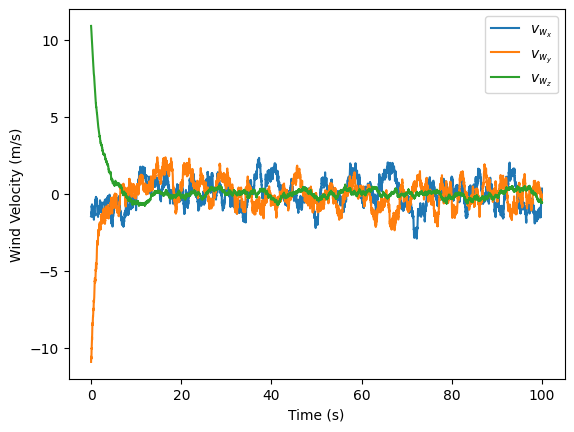

In [7]:
wind_vel_array = np.empty([10000,3])
wind_force_array = np.empty_like(wind_vel_array)

V_w = torch.zeros([3,])
V_w[0] = random.random() * (15 + 15) - 15
V_w[1] = random.random() * (15 + 15) - 15
V_w[2] = random.random() * (15 + 15) - 15
dt = 0.01

w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
w_array1 = torch.diag(w_array1)

w_array2 = torch.tensor([1.65,1.5,1.9])
w_array2 = torch.inverse(torch.diag(w_array2))

for sample in range(wind_vel_array.shape[0]):

    F_w = torch.tensor([
                    0.01 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.01 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.2 * V_w[2]**2 * torch.sign(V_w[2])
    ])
    
    wind_force_array[sample,:] = F_w.detach().numpy()
    
    wind_vel_array[sample,:] = V_w.detach().numpy()
    
    w_d = torch.normal(mean=0, std=0.2, size=[3,])

    V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

    V_w += V_wdot * dt
    
time_plt = np.linspace(0, 0.01*wind_vel_array.shape[0], wind_vel_array.shape[0])
plt.plot(time_plt, wind_vel_array[:,0])
plt.plot(time_plt, wind_vel_array[:,1])
plt.plot(time_plt, wind_vel_array[:,2])
plt.xlabel('Time (s)'), plt.ylabel('Wind Velocity (m/s)')
plt.legend([r'$v_{w_{x}}$',r'$v_{w_{y}}$',r'$v_{w_{z}}$'])    

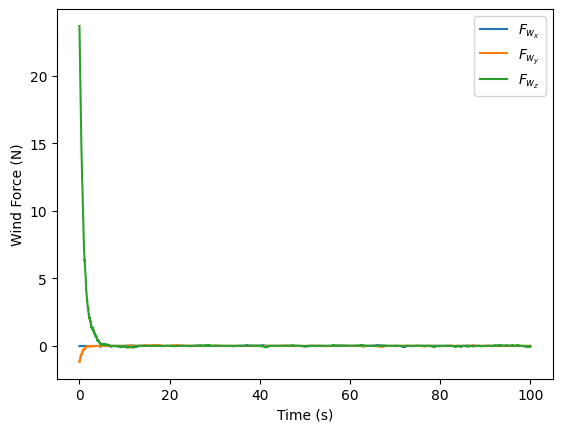

In [8]:
plt.plot(time_plt, wind_force_array[:,0])
plt.plot(time_plt, wind_force_array[:,1])
plt.plot(time_plt, wind_force_array[:,2])
plt.xlabel('Time (s)'), plt.ylabel('Wind Force (N)')
plt.legend([r'$F_{w_{x}}$',r'$F_{w_{y}}$',r'$F_{w_{z}}$'])    

In [81]:
# Number of points in the simulation.
N = 200

# Initializing simulation bound parameters
xy_offset = 20
min_Z, max_Z = 0, 50

# Defining rotor velocity constraints
min_rotor_bound = 0
max_rotor_bound = 1000
linvel_offset = torch.zeros([3,])
pitch_offset = torch.zeros([3,])

# Initializing quadrotor output array
batch_size = 1
quadout = torch.zeros([batch_size,N,32])

# Defining quadrotor mass and inertial properties
constants = constants_init()
I = constants['I']
Ixx = I[0,0]
Iyy = I[1,1]
Izz = I[2,2]
I_r = constants['I_r']
g = constants['g']
m = constants['m']
L = constants['L']
b = constants['b']
kf = constants['kf']
km = constants['km']
kd = constants['kd']
d_array = constants['d_array']

# Step through the simulation, updating the state.
for i in range(batch_size):

  # Initializing input trajectory from our controller.
  w1 = random.random() * (max_rotor_bound - min_rotor_bound) + min_rotor_bound
  w2 = random.random() * (max_rotor_bound - min_rotor_bound) + min_rotor_bound
  w3 = random.random() * (max_rotor_bound - min_rotor_bound) + min_rotor_bound
  w4 = random.random() * (max_rotor_bound - min_rotor_bound) + min_rotor_bound
  uu = torch.tensor([w1, w2, w3, w4])
  
  # Sampling initial quadrotor states
  state_vec, V_w = sample_quad_states(xy_offset, min_Z, max_Z, uu)

  for j in range(N):

    # Resampling next sampling rate
    dt = random.random() * (0.2 - 0.0002) + 0.0002

    # Saving current state as previous one
    prev_state_vec = state_vec

    while True:
      # Integrating dynamical states
      next_state_vec, V_w = eqn_mtn(prev_state_vec, uu, dt, V_w, linvel_offset, pitch_offset)
      X = next_state_vec[0]
      Y = next_state_vec[1]
      Z = next_state_vec[2]
      ROLL = next_state_vec[3]
      PITCH = next_state_vec[4]

      # Verifying that candidate next state is within defined state space
      state_verified = state_space_verify(Z, ROLL, PITCH)
      no_vel_offsets = quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, pitch_offset)
      #print(f'state_verified: {state_verified}, no_vel_offsets: {no_vel_offsets}')
      if state_verified and no_vel_offsets:

        # Capturing previous/next positional states, current sampling rate, and controls (rotor speeds)
        # of quadrotor
        xdot_prev = prev_state_vec[6:9]
        omega_prev = prev_state_vec[12:15]
        omegadot = prev_state_vec[15:18]
        a = prev_state_vec[18:]

        #x_prev_noise, q_prev_noise = apply_gaussian_noise(x_prev, q_prev)
        #print(f"x_prev: {x_prev}, q_prev: {q_prev}")
        #print(f"(noise) x_prev: {x_prev_noise}, q_prev: {q_prev_noise}\n")

        xdot_next = next_state_vec[6:9]
        omega_next = next_state_vec[12:15]
        omegadot_next = next_state_vec[15:18]
        a_next = next_state_vec[18:]
          
        #  INPUTS
        quadout[i,j,:3] = xdot_prev
        quadout[i,j,3:6] = a
        quadout[i,j,6:9] = omega_prev
        quadout[i,j,9:12] = omegadot
        quadout[i,j,12:13] = dt
        quadout[i,j,13:17] = uu
        quadout[i,j,17:20] = V_w
        # OUTPUTS
        quadout[i,j,20:23] = xdot_next
        quadout[i,j,23:26] = a_next
        quadout[i,j,26:29] = omega_next
        quadout[i,j,29:] = omegadot_next

        # Zeroing offsets when conditions are upheld
        linvel_offset = torch.zeros([3,])
        pitch_offset = torch.zeros([3,])
        break

      # Applying appropriate velocities until system evolves within admissible state space
      linvel_offset = linvel_control(Z, min_Z, max_Z)
      pitch_offset = roll_pitch_control(ROLL, PITCH)
      prev_state_vec = next_state_vec

     # print(f"X: {X}, Y: {Y}, Z: {Z}, ROLL: {ROLL}, PITCH: {PITCH}\n")
     # print(f"\n")

    # Saving admissible state vector as next concurrent state
    state_vec = next_state_vec

    # Take input from our controller.
    uu = update_controls(uu)

In [10]:
quadout[0,:,:]

tensor([[ 1.2310e+00,  4.6246e+00, -6.3537e-01,  ..., -1.6375e+00,
          1.8970e+00, -1.4388e+00],
        [ 8.4919e-01,  4.1988e+00, -5.5394e+00,  ...,  1.5920e-01,
         -3.1123e-01, -1.1248e+00],
        [ 7.4760e-01,  4.1431e+00, -6.4505e+00,  ...,  3.5119e-01,
         -1.4621e-01, -1.1840e+00],
        ...,
        [-1.3779e-01, -4.2852e-01, -6.8755e+00,  ...,  3.5511e-02,
          2.4318e-02, -2.1819e-01],
        [-1.4449e-01, -4.6550e-01, -7.9362e+00,  ...,  3.0540e-02,
         -1.8492e-02, -1.5046e-01],
        [-4.5143e-03, -5.1030e-02,  8.9184e+00,  ..., -1.0165e-01,
         -1.9064e-01, -1.2483e-01]])

In [135]:
quadout = traj_dataset.clone()
plt_idx = random.randint(0, quadout.shape[0]-1)
Xdot = quadout[plt_idx,:,0].detach().numpy()
Ydot = quadout[plt_idx,:,1].detach().numpy()
Zdot = quadout[plt_idx,:,2].detach().numpy()
Ax = quadout[plt_idx,:,3].detach().numpy()
Ay = quadout[plt_idx,:,4].detach().numpy()
Az = quadout[plt_idx,:,5].detach().numpy()
ωx = quadout[plt_idx,:,6].detach().numpy()
ωy = quadout[plt_idx,:,7].detach().numpy()
ωz = quadout[plt_idx,:,8].detach().numpy()
ωxdot = quadout[plt_idx,:,9].detach().numpy()
ωydot = quadout[plt_idx,:,10].detach().numpy()
ωzdot = quadout[plt_idx,:,11].detach().numpy()

tspan = np.zeros([quadout.shape[1],], dtype=np.float32)
curr_t = 0
for t in range(N):
    tspan[t] = curr_t
    curr_t += quadout[plt_idx,t,12]

In [18]:
quadout[0,:,12]

tensor([0.1104, 0.0973, 0.1828, 0.0449, 0.0761, 0.0951, 0.0282, 0.0201, 0.0564,
        0.1777, 0.0327, 0.0083, 0.0089, 0.1260, 0.0690, 0.1722, 0.1655, 0.0015,
        0.0143, 0.0620, 0.1846, 0.1914, 0.0814, 0.1235, 0.0348, 0.0902, 0.0108,
        0.0613, 0.1635, 0.1526, 0.1474, 0.1989, 0.0101, 0.0502, 0.0224, 0.0094,
        0.0328, 0.1446, 0.0605, 0.1602, 0.1470, 0.1334, 0.1393, 0.0891, 0.0378,
        0.0737, 0.0012, 0.1913, 0.0448, 0.1693, 0.1207, 0.0926, 0.0752, 0.0091,
        0.1141, 0.0073, 0.0057, 0.1179, 0.0753, 0.0371, 0.0417, 0.1408, 0.1414,
        0.1627, 0.1439, 0.1156, 0.0374, 0.1523, 0.0495, 0.0044, 0.1049, 0.0518,
        0.0549, 0.1841, 0.0426, 0.1051, 0.1193, 0.0330, 0.0107, 0.1291, 0.1808,
        0.0377, 0.1097, 0.0687, 0.1593, 0.1373, 0.1110, 0.0113, 0.0138, 0.0704,
        0.1154, 0.1785, 0.0323, 0.0667, 0.1328, 0.1458, 0.0601, 0.1120, 0.1185,
        0.1441, 0.0359, 0.0197, 0.0629, 0.1563, 0.0789, 0.1125, 0.0888, 0.1743,
        0.0771, 0.0917, 0.1945, 0.0799, 

In [21]:
tspan

array([ 0.        ,  0.11042611,  0.20770729,  0.39053884,  0.4354795 ,
        0.5116084 ,  0.60673004,  0.6349279 ,  0.65500134,  0.71140397,
        0.8891233 ,  0.9218584 ,  0.9301692 ,  0.9391105 ,  1.0650959 ,
        1.1341035 ,  1.3062707 ,  1.4717534 ,  1.4732593 ,  1.4875573 ,
        1.5495548 ,  1.7341437 ,  1.9255338 ,  2.0069141 ,  2.1304545 ,
        2.1652327 ,  2.2554233 ,  2.2661772 ,  2.327479  ,  2.4910128 ,
        2.6436434 ,  2.7910872 ,  2.9899619 ,  3.00004   ,  3.0502021 ,
        3.072601  ,  3.0819976 ,  3.1148071 ,  3.2593584 ,  3.3198857 ,
        3.480079  ,  3.627078  ,  3.7604342 ,  3.8996978 ,  3.9887645 ,
        4.026598  ,  4.100281  ,  4.1014605 ,  4.292803  ,  4.337583  ,
        4.50692   ,  4.627619  ,  4.720219  ,  4.7954397 ,  4.80453   ,
        4.9186077 ,  4.925955  ,  4.9316597 ,  5.0495477 ,  5.124882  ,
        5.161946  ,  5.2036757 ,  5.3444376 ,  5.485797  ,  5.6484504 ,
        5.792324  ,  5.907923  ,  5.945324  ,  6.0975966 ,  6.14

Ground effect force for 20 kg quadrotor should be approximately 80 N at its highest (Scaling computed by 0.4 * weight of quadrotor (in N))

### PID Control Implementations

Attitude Tracking PID Implementation

In [ ]:
def eqn_mtn(state_vec, uu, linvel_offset=torch.tensor([0,0,0]), pitch_offset=torch.tensor([0,0,0])):
  # Parsing positional and velocity states
  x = state_vec[:3]
  theta = state_vec[3:6]
  xdot = state_vec[6:9]
  thetadot = state_vec[9:]

  omega = thetadot2omega(thetadot, theta)

  # Compute linear and angular accelerations.
  a = acceleration(uu, theta, xdot, m, g, kf, kd)
  omegadot = angular_acceleration(uu, omega, I, L, b, km)

  # Integrating quadrotor states
  omega = omega + dt * omegadot

  if torch.any(pitch_offset):
    thetadot = pitch_offset
  else:
    thetadot = omega2thetadot(omega, theta)

  if torch.any(linvel_offset):
    xdot = linvel_offset
  else:
    xdot = xdot + dt * a

  # Integrating quadrotor positional states
  theta = theta + dt * thetadot
  x = x + dt * xdot

  # Ensuring euler angles lie within appropriate bounds
  theta = theta_check(theta)

  # Updating state vector
  state_vec = torch.concat([x, theta, xdot, thetadot], dim=0)

  return state_vec



def pd_control(state_vec, Kp, Kd, I, b, L, m, g, k):

  def error2inputs(e):
    # Parsing components of error for each euler angle
    e_roll = e[0]
    e_pitch = e[1]
    e_yaw = e[2]

    # Parsing scalar values from each needed parameter
    roll = state_vec[3]
    pitch = state_vec[4]
    yaw = state_vec[5]
    Ixx = I[0,0]
    Iyy = I[1,1]
    Izz = I[2,2]

    # Computing needed rotor velocities from derived control law
    w1 = (m*g) / (4*k*cos(pitch)*cos(roll)) - (2*b*e_roll*Ixx + e_yaw*Izz*k*L) / (4*b*k*L)
    w2 = (m*g) / (4*k*cos(pitch)*cos(roll)) + (e_yaw*Izz) / (4*b) - (e_pitch*Iyy) / (2*k*L)
    w3 = (m*g) / (4*k*cos(pitch)*cos(roll)) - (e_yaw*Izz*k*L - 2*b*e_roll*Ixx) / (4*b*k*L)
    w4 = (m*g) / (4*k*cos(pitch)*cos(roll)) + (e_yaw*Izz) / (4*b) + (e_pitch*Iyy) / (2*k*L)

    # Returning rotor velocities
    return torch.tensor([w1, w2, w3, w4])

  # Parsing attitude angles/velocities of quadrotor
  theta = state_vec[3:6]
  thetadot = state_vec[9:]

  # Defining PD parameters
  Kp = 2
  Kd = 4/3

  # Computing total needed thrust
  T = (m*g) / (k*cos(theta[0]*cos(theta[1])))

  # Computing current error
  e = Kd * thetadot + Kp * theta

  inputs = error2inputs(e)

  return inputs


def pid_control(state_vec, err_sum, Kp, Ki, Kd,  I, b, L, m, g, km):

  def error2inputs(e):
    # Parsing components of error for each euler angle
    e_roll = e[0]
    e_pitch = e[1]
    e_yaw = e[2]

    # Parsing scalar values from each needed parameter
    roll = state_vec[3]
    pitch = state_vec[4]
    yaw = state_vec[5]
    Ixx = I[0,0]
    Iyy = I[1,1]
    Izz = I[2,2]

    # Computing needed rotor velocities from derived control law
    w1 = (m*g) / (4*km*cos(pitch)*cos(roll)) - (2*b*e_roll*Ixx + e_yaw*Izz*km*L) / (4*b*km*L)
    w2 = (m*g) / (4*km*cos(pitch)*cos(roll)) + (e_yaw*Izz) / (4*b) - (e_pitch*Iyy) / (2*km*L)
    w3 = (m*g) / (4*km*cos(pitch)*cos(roll)) - (e_yaw*Izz*km*L - 2*b*e_roll*Ixx) / (4*b*km*L)
    w4 = (m*g) / (4*km*cos(pitch)*cos(roll)) + (e_yaw*Izz) / (4*b) + (e_pitch*Iyy) / (2*km*L)

    # Returning rotor velocities
    return torch.tensor([w1, w2, w3, w4])

  # Parsing attitude angles/velocities of quadrotor
  theta = state_vec[3:6]
  thetadot = state_vec[9:]

  # Computing total needed thrust
  T = (m*g) / (km*cos(theta[0]*cos(theta[1])))

  # Computing current error
  e = Kd * thetadot + Kp * theta + Ki * err_sum

  # Storing current error (protects against windup)
  if torch.max(theta) > 0.1:
    err_sum = 0
  else:
    err_sum += theta

  #print(err_sum)

  # Computing needed control input from error
  inputs = error2inputs(e)

  return inputs, err_sum

In [ ]:
# Defining quadrotor inertial properties
m = 1.3                # Mass of quadrotor (kg)
g = 9.806              # Gravitational force (m/s^2)
L = 0.21               # Length of quadrotor arm (rotor-to-center) (m)
r_prop = 0.254         # Radius of quadrotor propellor
A = 5.063e-2           # Cross-sectional area of propellor
I = inertia_tensor()   # Inertia tensor of quadrotor

# Defining quadrotor aerodynamic properties

kf = 1.08e-03       # Aerodynamic force coefficient (N*s^2)
km = 1.08e-03       # Aerodynamic moment coefficient (N*m*s^2)
kd = 0.1            # Aerodynamic friction coefficient
C_d = 0.35          # Aerodynamic dimensionless drag coefficient
rho = 1.225         # Air density (kg/m^3)

# Simulation drag coefficient
b = 0.5 * r_prop**3 * rho * C_d  * A

# Initializing simulation bound parameters
xy_offset = 20
min_Z, max_Z = 0, 40

# Defining PID parameters
Kp = 3.5
Kd = 1.5
Ki = 1e-3

# Sampling initial quadrotor states
state_vec = sample_quad_states(xy_offset, min_Z, max_Z)

# Defining simulation loop
times = torch.linspace(0, 10, 1000)
dt = times[1] - times[0]
quad_attitude = torch.zeros([3, times.shape[0]])
err_sum = torch.zeros([3,])
for t in range(times.shape[0]):

  # Capturing relevant quadrotor output
  quad_attitude[0,t] = state_vec[3]
  quad_attitude[1,t] = state_vec[4]
  quad_attitude[2,t] = state_vec[5]

  # Take input from our controller.
  uu, err_sum = pid_control(state_vec, err_sum, Kp, Ki, Kd, I, b, L, m, g, km)
  # Evolve quadrotor states
  state_vec = eqn_mtn(state_vec, uu)

# Displaying steady-state errors
print(f"Steady-State Error:\n\nRoll: {abs(state_vec[3])}, Pitch: {abs(state_vec[4])}, Yaw: {abs(state_vec[5])}\n")

# Plotting sim results
quad_attitude = quad_attitude.detach().numpy()
plt.plot(times, quad_attitude[0,:], label='roll')
plt.plot(times, quad_attitude[1,:], label='pitch')
plt.plot(times, quad_attitude[2,:], label='yaw')
plt.plot(times, np.zeros_like(times), '--r', label='zero')
plt.xlabel("Time (s)"), plt.ylabel("Euler Angles (rad)")
plt.title("Results from PID Control")
plt.legend()
plt.show()

### General MLP

In [3]:
class MLP(nn.Module):

  def __init__(
      self,
      input_size,
      output_size,
      hidden_size=128,
      n_hidden_layers=1,
      activation=nn.ReLU(),
      is_bias=True,
      dropout=0,
      aggregate_step=False,
      num_latents=0):

    super(MLP, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.n_hidden_layers = n_hidden_layers

    self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()
    self.activation = activation

    self.to_hidden = nn.Linear(self.input_size, self.hidden_size, bias=is_bias)
    self.linears = nn.ModuleList(
        [
            nn.Linear(self.hidden_size, self.hidden_size, bias=is_bias)
            for _ in range(self.n_hidden_layers - 1)
        ]
    )

    self.out = nn.Linear(self.hidden_size, self.output_size, bias=is_bias)
    self.aggregate_step = aggregate_step
    if self.aggregate_step:
      self.num_latents = num_latents
      self.latent_hidden = int((hidden_size+num_latents)/2)
      self.penultimate_layer = nn.Linear(output_size, self.latent_hidden, bias=is_bias)
      self.mu_layer = nn.Linear(self.latent_hidden, num_latents)
      self.log_sigma_layer = nn.Linear(self.latent_hidden, num_latents)


  def forward(self, x):
    out = self.to_hidden(x)
    out = self.activation(out)
    x = self.dropout(out)

    for linear in self.linears:
      out = linear(x)
      out = self.activation(out)
      out = self.dropout(out)
      x = out

    out = self.out(out)

    # Add-in for latent encoder steps
    if self.aggregate_step:
      out = torch.mean(out, dim=1)
      out = self.penultimate_layer(out)
      mu = self.mu_layer(out)
      log_sigma = self.log_sigma_layer(out)

      return mu, log_sigma

    else:
      return out

### Cross-Attention Module

In [ ]:
class Attention(object):
  """The Attention module."""

  def __init__(self, output_sizes, normalize=True):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention.
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalize: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self.output_sizes = output_sizes
    self.normalize = normalize

  def dot_product_attention(self, q, k, v):
      """Computes dot product attention.

      Args:
        q: queries. tensor of  shape [B,m,d_k].
        k: keys. tensor of shape [B,n,d_k].
        v: values. tensor of shape [B,n,d_v].
        normalise: Boolean that determines whether weights sum to 1.

      Returns:
        tensor of shape [B,m,d_v].
      """
      d_k = q.shape[-1]
      scale = torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
      unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]

      if self.normalize:
        weights = torch.nn.functional.softmax(unnorm_weights)  # [B,m,n]
      else:
        weights = torch.nn.functional.sigmoid(unnorm_weights)

      rep = torch.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
      return rep

  def __call__(self, context_x, target_x, representation):
    """Apply attention to create aggregated representation of r.

    Args:
      context_x: tensor of shape [B,n1,d_x].
      target_x: tensor of shape [B,n2,d_x].
      representation: tensor of shape [B,n1,d].

    Returns:
      tensor of shape [B,n2,d]

    """

    # Pass through MLP
    key_mlp = MLP(
        input_size=1,
        output_size=128
    )
    k = key_mlp(context_x)

    query_mlp = MLP(
        input_size=1,
        output_size=128
    )
    q = query_mlp(target_x)

    rep = self.dot_product_attention(q, k, representation)

    return rep

### 1D-Convolutional NN

In [4]:
class Conv1D(nn.Module):

  def __init__(
      self,
      head_size=16,
      input_size=128,
      x_dim=1,
      stddev=1
  ):
    super(Conv1D, self).__init__()

    # Initializing kernel
    self.W = nn.init.normal_(torch.zeros([head_size, input_size, x_dim]), std=stddev)

  def forward(self, x):
    out = F.conv1d(x.transpose(2,1), self.W, bias=None)
    out.transpose_(2,1)
    return out


### Defining Deterministic Encoder

In [5]:
class DeterministicEncoder():

  def __init__(self, hidden_size):

    self.hidden_sizes = hidden_size

  def __call__(self, context_x, context_y, target_x):

    num_context_points = context_x.shape[1]
    encoder_input = torch.concat([context_x, context_y], dim=-1)

    batch_size = encoder_input.shape[0]
    encoder_size = encoder_input.shape[2]

    encoder_input = encoder_input.reshape([batch_size*num_context_points, -1])

    encoder_network = MLP(
        input_size=encoder_size,
        hidden_size=self.hidden_sizes,
        output_size=self.hidden_sizes,
        n_hidden_layers=2
    )

    hidden = encoder_network(encoder_input)
    hidden = hidden.reshape([batch_size, num_context_points, self.hidden_sizes])

    representation = F.scaled_dot_product_attention(target_x, context_x, hidden)

    return representation

### Defining Latent Encoder

In [ ]:
class LatentEncoder():

  def __init__(self, hidden_sizes, num_latents):

    self.hidden_sizes = hidden_sizes
    self.num_latents = num_latents

  def __call__(self, x, y):
    # Concatenate x and y along the filter axes
    encoder_input = torch.concat([x, y], dim=-1)
    encoder_size = encoder_input.shape[-1]

    # Initializing latent encoder network
    encoder_network = MLP(
        input_size=encoder_size,
        hidden_size=self.hidden_sizes,
        output_size=self.hidden_sizes,
        n_hidden_layers=2,
        aggregate_step=True,
        num_latents=self.hidden_sizes
    )

    # Passing encoder input through MLP and deriving mean and log variance describing latent variable distribution
    mu, log_sigma = encoder_network(encoder_input)

    # Bounding the log variance to obtain true variance values
    sigma = 0.9 * F.sigmoid(log_sigma) + 0.1

    return Normal(loc=mu, scale=sigma)


### Defining Base Decoder

In [ ]:
class Decoder():

  def __init__(self, hidden_sizes):

    self.hidden_sizes = hidden_sizes

  def __call__(self, representation, target_x, num_total_points):

    input = torch.concat([representation, target_x], axis=-1)
    batch_size = input.shape[0]
    decoder_size = input.shape[2]
    decoder_input = torch.reshape(input, [batch_size*num_total_points, -1])

    decoder_network = MLP(
        input_size=decoder_size,
        output_size=2,
        hidden_size=self.hidden_sizes
    )

    hidden = decoder_network(decoder_input)
    hidden = hidden.reshape([batch_size, num_total_points, -1])

    mu, log_sigma = torch.tensor_split(hidden, 2, dim=-1)

    sigma = 0.9 * F.softplus(log_sigma, threshold=100) + 0.1

    dist = Independent(Normal(loc=mu, scale=sigma), 1)

    return dist, mu, sigma

### Defining (Att)LNP Base Model

In [ ]:
class LatentModel():

  def __init__(self, encoder_hidden_sizes, decoder_hidden_sizes, num_latents, use_deterministic_path=True):

    self.latent_encoder = LatentEncoder(encoder_hidden_sizes, num_latents)
    self.decoder = Decoder(decoder_hidden_sizes)
    self.use_deterministic_path = use_deterministic_path
    if self.use_deterministic_path:
      self.deterministic_encoder = DeterministicEncoder(encoder_hidden_sizes)

  def __call__(self, query, num_total_points, num_context_points, target_y=None):

    (context_x, context_y), target_x = query

    prior = self.latent_encoder(context_x, context_y)

    # For testing, when target_y unavailable, use contexts for latent encoder.
    if target_y is None:
      latent_rep = prior.sample()

    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    else:
      posterior = self.latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()

    latent_rep = torch.tile(torch.unsqueeze(latent_rep, dim=1), [1, num_total_points, 1])

    if self.use_deterministic_path:
      deterministic_rep = self.deterministic_encoder(context_x, context_y, target_x)
      representation = torch.concat([deterministic_rep, latent_rep], dim=-1)
    else:
      representation = latent_rep

    dist, mu, sigma = self.decoder(representation, target_x, num_total_points)

    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      kl = torch.sum(
          kl_divergence(posterior, prior),
          dim=-1,
          keepdim=True
      )
      kl = torch.tile(kl, [1, num_total_points])
    else:
      log_p = None
      kl = None

    return log_p, kl, mu, sigma


### Defining Custom Loss Function

In [5]:
class LossFunc(nn.Module):
  def __init__(self):
    super(LossFunc, self).__init__()

  def forward(self, log_p, kl):
    # Computing total loss
    loss = -torch.mean((log_p - kl))
    return loss

### Combining Encoder, Decoder, Cross-Attention, and Latent Models for Training and Evaluating Purposes.

In [6]:
class AttLNP(nn.Module):

  def __init__(
      self,
      encoder_size,
      x_dim=1,
      y_dim=1,
      num_heads=8,
      att_type='mha',
      rep_transform = 'mlp',
      use_deterministic_path=True,
      R_dim=128  # Size for encoded representation vector, R
      ):

    super(AttLNP, self).__init__()
    self.hidden_sizes = R_dim
    self.rep_transform = rep_transform
    self.att_type = att_type
    self.use_deterministic_path = use_deterministic_path
    if self.att_type == 'mha'.lower():
      self.num_heads = num_heads

    # 1D Convolution Layers (for Multihead Attention)
    if self.att_type == 'mha':
      self.key_conv1d = Conv1D()
      self.value_conv1d = Conv1D()
      self.query_conv1d = Conv1D()
      self.rep_conv1d = Conv1D(
          head_size=R_dim, input_size=int(R_dim/num_heads), stddev=R_dim**(-0.5)
      )

    # Encoder/Decoder MLPs
    self.latent_encoder_network = MLP(
        input_size=encoder_size,
        output_size=R_dim,
        n_hidden_layers=2,
        aggregate_step=True,
        num_latents=R_dim
    )

    if self.use_deterministic_path: decoder_input = 2*R_dim+x_dim
    else: decoder_input = R_dim+x_dim
    self.decoder_network = MLP(
        input_size=decoder_input, # Input size for 128-dim representation vector + target_x (1-dim) concatenated
        output_size=y_dim*2
    )

    if self.use_deterministic_path:
      self.deterministic_encoder_network = MLP(
          input_size=encoder_size,
          output_size=R_dim,
          n_hidden_layers=2
      )

      # Key/Query MLPs
      if self.rep_transform == 'mlp'.lower():
        self.key_mlp = MLP(
            input_size=x_dim,
            output_size=R_dim
            )
        self.query_mlp = MLP(
            input_size=x_dim,
            output_size=R_dim
            )

  def latent_encoder(self, x, y):
    # Passing encoder input through MLP and deriving mean and log variance describing latent variable distribution
    encoder_input = torch.concat([x, y], dim=-1)
    mu, log_sigma = self.latent_encoder_network(encoder_input)

    # Bounding the log variance to obtain true variance values
    sigma = 0.9 * F.sigmoid(log_sigma) + 0.1

    return Normal(loc=mu, scale=sigma)

  def deterministic_encoder(self, context_x, context_y, target_x):

    num_context_points = context_x.shape[1]
    encoder_input = torch.concat([context_x, context_y], dim=-1)

    batch_size = encoder_input.shape[0]
    encoder_size = encoder_input.shape[2]

    encoder_input = encoder_input.reshape([batch_size*num_context_points, -1])

    hidden = self.deterministic_encoder_network(encoder_input)
    v = hidden.reshape([batch_size, num_context_points, self.hidden_sizes])

    # Passing context and target inputs to form keys and query of attention model
    if self.rep_transform == 'mlp'.lower():
      k = self.key_mlp(context_x)
      q = self.query_mlp(target_x)
    elif self.rep_transform == 'identity'.lower():
      k, q = context_x, target_x

    # Calculating query-specific representation, R(*)
    if self.att_type == 'dpa'.lower(): # dot-product attention
      representation = F.scaled_dot_product_attention(q,k,v)
    elif self.att_type == 'mha'.lower(): # multi-headed attention
      representation = self.multihead_attention(q,k,v)
    elif self.att_type == 'ua'.lower(): # uniform attention
      representation = self.uniform_attention(q, v)

    return representation


  def decoder(self, representation, target_x):
    decoder_input = torch.concat([representation, target_x], axis=-1)
    num_total_points = target_x.shape[1]
    batch_size = decoder_input.shape[0]

    hidden = self.decoder_network(decoder_input)
    hidden = hidden.reshape([batch_size, num_total_points, -1])

    mu, log_sigma = torch.tensor_split(hidden, 2, dim=-1)

    sigma = 0.9 * F.softplus(log_sigma, threshold=100) + 0.1

    dist = Independent(Normal(loc=mu, scale=sigma), 1)

    return dist, mu, sigma


  def multihead_attention(self, q, k, v):
    """Computes multi-head attention.

    Args:
      q: queries. tensor of  shape [B,m,d_k].
      k: keys. tensor of shape [B,n,d_k].
      v: values. tensor of shape [B,n,d_v].
      num_heads: number of heads. Should divide d_v.

    Returns:
      tensor of shape [B,m,d_v].
    """
    batch_size = q.shape[0]
    query_size = q.shape[1]
    d_v = v.shape[-1]

    rep = torch.zeros([batch_size, query_size, d_v])
    for h in range(self.num_heads):
      # Shrinking dimension space of representations through 1D convolution
      k_conv = self.key_conv1d(k)
      q_conv = self.query_conv1d(q)
      v_conv = self.value_conv1d(v)

      # Gathering attention from reduced representations
      o = F.scaled_dot_product_attention(q_conv, k_conv, v_conv)
      rep += self.rep_conv1d(o)

    return rep

  def uniform_attention(self, q, v):
    # Equivalent to a LNP
    num_total_points = q.shape[1]
    rep = torch.mean(v, dim=1, keepdim=True)
    rep = torch.tile(rep, [1, num_total_points, 1])
    return rep

  def forward(
      self,
      query,
      target_y=torch.tensor([]),
      is_testing=False
  ):

    # Parsing data from dataset query
    (context_x, context_y), target_x = query
    num_total_points = target_x.shape[1]

    # Defining prior distribution over gaussian latent variable
    prior = self.latent_encoder(context_x, context_y)

    # For testing, when target_y unavailable, use contexts for latent encoder.
    if is_testing:
      latent_rep = prior.sample()

    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    else:
      posterior = self.latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()

    latent_rep = torch.tile(torch.unsqueeze(latent_rep, dim=1), [1, num_total_points, 1])

    if self.use_deterministic_path:
      deterministic_rep = self.deterministic_encoder(context_x, context_y, target_x)
      representation = torch.concat([deterministic_rep, latent_rep], dim=-1)
    else:
      representation = latent_rep

    dist, mu, sigma = self.decoder(representation, target_x)

    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y.shape[0] != 0:
      posterior = self.latent_encoder(target_x, target_y)
      log_p = dist.log_prob(target_y)
      kl = torch.sum(
          kl_divergence(posterior, prior),
          dim=-1,
          keepdim=True
          )
     # print(f'kl: {kl.shape}, kl-array: {kl_divergence(posterior, prior).shape}')
      kl = torch.tile(kl, [1, num_total_points])
     # print(f'log_p: {log_p.shape}, kl: {kl.shape}')
      
      return log_p, kl, mu, sigma

    else:

      return mu, sigma



In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

model = torch.load('vel+accel-high-disturbance-mm-noise-model-1370-epochs.pt')
count_parameters(model)

193304

In [7]:
def compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(target_y[:,-1,:] - pred_y[:,-1,:])
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array

def scaled_compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  scaled_pos_diff = np.abs((target_y[:,-1,:3] - pred_y[:,-1,:3]) / pred_y[:,-1,:3])
  scaled_euler_diff = np.abs((np.cos(target_y[:,-1,3:]) - np.cos(pred_y[:,-1,3:])) / np.cos(pred_y[:,-1,3:])) \
                    + np.abs((np.sin(target_y[:,-1,3:]) - np.sin(pred_y[:,-1,3:])) / np.sin(pred_y[:,-1,3:]))
  
  scaled_AE_array = np.sum(scaled_pos_diff, axis=1) + np.sum(scaled_euler_diff, axis=1)

  return scaled_AE_array

def plot_all_functions(context_x, context_y, target_x, target_y, pred_y, var, num_rows=2, num_cols=3):

  # Detaching gradients of tensors for plotting purposes
  context_x = context_x.detach().numpy()
  context_y = context_y.detach().numpy()
  target_x = target_x.detach().numpy()
  target_y = target_y.detach().numpy()
  pred_y = pred_y.detach().numpy()
  var = var.detach().numpy()

  # Computing batch absolute error and logging error of first sample
  plt_idx = random.randint(0, pred_y.shape[0]-1)
  AE_array = compute_AE(target_y, pred_y)
  print(f"Average Absolute Prediction Error (AAE) of Plotted Sample: {AE_array[plt_idx]}")

  # TO DO
  batch_size = pred_y.shape[0]
  pred_plot_array = np.zeros([2,12])
  pred_plot_array[0,:] = target_y[plt_idx,0,:]
  pred_plot_array[1,:] = pred_y[plt_idx,1,:]

  # Defining plot figures for both velocity/acceleration predictions
  figure, axis = plt.subplots(num_rows, num_cols)
  figure2, axis2 = plt.subplots(num_rows, num_cols)

  # Obtaining simulation time vector 'tspan'
  t = 0
  tspan = np.zeros_like(target_x[0,:,0])
  for i in range(tspan.shape[0]):
    tspan[i] = t
    t += target_x[plt_idx,-1,0]

  # Plotting everything for the first sample in the test batch
  y_labels = [r'$\dot{X}$ (m/s)', r'$\dot{Y}$ (m/s)', r'$\dot{Z}$ (m/s)', 
              r'$\ddot{X}$ (m/$s^{2}$)', r'$\ddot{Y}$ (m/$s^{2}$)', r'$\ddot{Z}$ (m/$s^{2}$)',
              r'$\omega_x$ ($rad/s$)', r'$\omega_y$ ($rad/s$)', r'$\omega_z$ ($rad/s$)',
              r'$\dot{\omega}_x$ ($rad/s^{2}$)', r'$\dot{\omega}_y$ ($rad/s^{2}$)', r'$\dot{\omega}_z$ ($rad/s^{2}$)']

  i = 0
  for row in range(num_rows):
    for col in range(num_cols):
      # Determine the upper and lower uncertainty bounds for each model prediction
      pred_ub = pred_plot_array[-1, i] + var[plt_idx, -1, i]
      pred_lb = pred_plot_array[-1, i] - var[plt_idx, -1, i]
      var_range = np.linspace(pred_lb, pred_ub, 20)
      dt_range = np.linspace(tspan[-1], tspan[-1], 20)

      # Obtaining prediction performance for each positional state
      axis[row,col].plot(tspan, target_y[plt_idx,:,i], 'ko', markersize=7.5)
      axis[row,col].plot(tspan[-1], pred_plot_array[-1,i], 'b*', markersize=7.5)
      axis[row,col].plot(tspan[-1], pred_ub, 'b_', linewidth=1)
      axis[row,col].plot(tspan[-1], pred_lb, 'b_', linewidth=1)
      axis[row,col].plot(dt_range, var_range, 'b--', linewidth=0.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis[row,col].set_ylabel(y_labels[i], fontsize=12)
      """
      axis[row].fill_between(
          tspan,
          pred_plot_array[:, row] - var[0, :, row],
          pred_plot_array[:, row] + var[0, :, row],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)
      """
      if row == 0 and col == 0: axis[row,col].legend(['pred','real'], fontsize=6)
      plt.plot()
      axis[row,col].grid(False)
      i += 1

  figure.supxlabel(r"Time $(s)$")
  figure.tight_layout(pad=1.0)
  
  # Looping over velocity predictions
  for row in range(num_rows):
    for col in range(num_cols):
      # Determine the upper and lower uncertainty bounds for each model prediction
      pred_ub = pred_plot_array[-1, i] + var[plt_idx, -1, i]
      pred_lb = pred_plot_array[-1, i] - var[plt_idx, -1, i]
      var_range = np.linspace(pred_lb, pred_ub, 20)
      dt_range = np.linspace(tspan[-1], tspan[-1], 20)

      # Obtaining prediction performance for each positional state
      axis2[row,col].plot(tspan, target_y[plt_idx,:,i], 'ko', markersize=7.5)
      axis2[row,col].plot(tspan[-1], pred_plot_array[-1,i], 'b*', markersize=7.5)
      axis2[row,col].plot(tspan[-1], pred_ub, 'b_', linewidth=1)
      axis2[row,col].plot(tspan[-1], pred_lb, 'b_', linewidth=1)
      axis2[row,col].plot(dt_range, var_range, 'b--', linewidth=0.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis2[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis2[row,col].set_ylabel(y_labels[i], fontsize=12)

      if row == 0 and col == 0: axis[row,col].legend(['pred','real'], fontsize=6)
      plt.plot()
      axis2[row,col].grid(False)
      i += 1

  figure2.supxlabel(r"Time $(s)$")
  figure2.tight_layout(pad=1.0)
  plt.show()

### Training AttLNP

In [13]:
norm_quadout.shape

torch.Size([3999144, 2, 20])

In [8]:
# Initializing data & training step parameters
NUM_EPOCHS = 1000
PLOT_AFTER = 10
BATCH_SIZE = 1000
TRAIN_TEST_SPLIT = 499564
TRAJ_LENGTH = 2
COLLECT_TRAINING_LOSS_AFTER = int(5e1)

In [9]:
def shuffle_data(traj_dataset, shuffle_test=False):
    idx_tnsr = db.index_data_stacker(traj_dataset)
    if shuffle_test:
        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])
        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT, :])

        return train_dataset, test_dataset
    
    train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr)
    return train_dataset

In [24]:
norm_quadout.shape

torch.Size([1999564, 2, 20])

In [27]:
db = Quadrotor_Dynamics_Generator(traj_length=TRAJ_LENGTH)

# Loading training and testing datasets
traj_dataset = norm_quadout.clone() #torch.from_numpy(np.load('quad_traj_all_dataset_4.5e6_vel_data_high_disturbance_mm_noise_filtered.npy'))
#traj_dataset = db.convert2new(traj_dataset)
train_dataset, test_dataset = shuffle_data(traj_dataset, shuffle_test=True)

# Sampling initial training and testing batches from dynamical dataset
batch_dataset = train_dataset[:BATCH_SIZE,:,:]
input = batch_dataset[:,:,:8]
output = batch_dataset[:,:,8:]

# Defining context and target sets
context_x = input[:,0:1,:].clone()
context_y = output[:,0:1,:].clone()
target_x = input.clone()
target_y = output.clone()

In [11]:
np.save('quad_traj_NP_dataset_4.5e6_vel_data_high_disturbance_mm_noise_unnorm_filtered.npy', traj_dataset.detach().numpy())

Epoch: 0, Batch Testing Loss: 10.39978313446045, Batch Testing Average AE: 722.6859741210938 w/ Standard Deviation: 37.630958557128906
Average Absolute Prediction Error (AAE) of Plotted Sample: 725.48828125


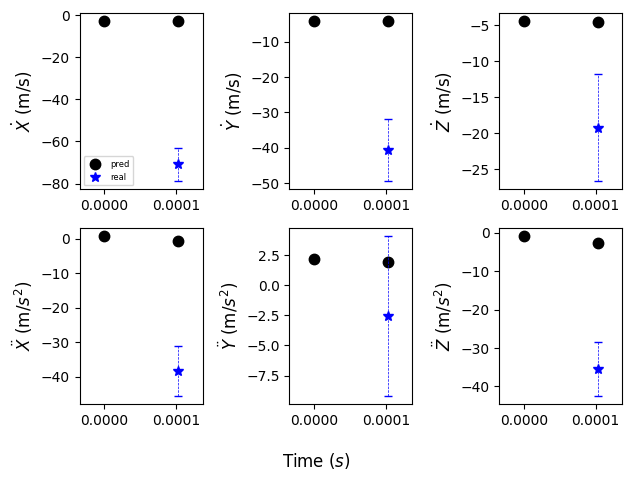

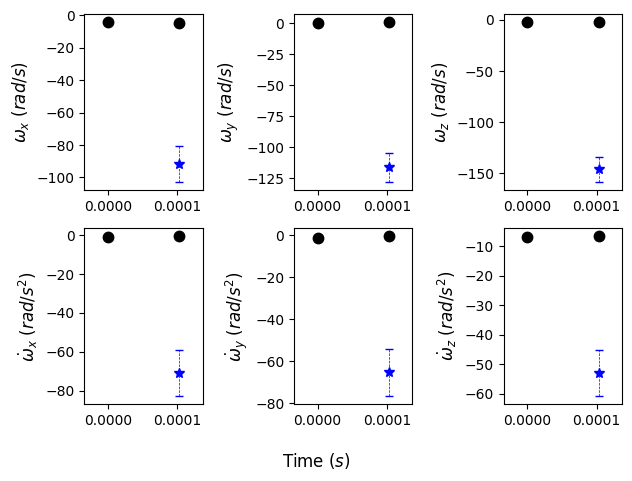

Current Batch Train Loss: 10.071662902832031

Current Batch Train Loss: -7.4615960121154785

Current Batch Train Loss: -14.251812934875488

Current Batch Train Loss: -15.230874061584473

Current Batch Train Loss: -15.636710166931152

Current Batch Train Loss: -15.852131843566895

Current Batch Train Loss: -15.979496002197266

Current Batch Train Loss: -16.012619018554688

Current Batch Train Loss: -16.095415115356445

Current Batch Train Loss: -16.085744857788086

Current Batch Train Loss: -16.130817413330078

Current Batch Train Loss: -16.11259651184082

Current Batch Train Loss: -16.140653610229492

Current Batch Train Loss: -16.14479637145996

Current Batch Train Loss: -16.02349853515625

Current Batch Train Loss: -16.164770126342773

Current Batch Train Loss: -16.19801902770996

Current Batch Train Loss: -16.158693313598633

Current Batch Train Loss: -16.207698822021484

Current Batch Train Loss: -16.21994400024414

Current Batch Train Loss: -16.184553146362305

Current Batch Train

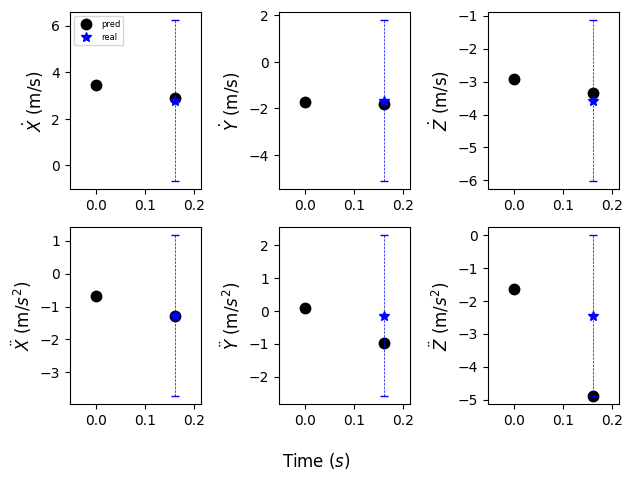

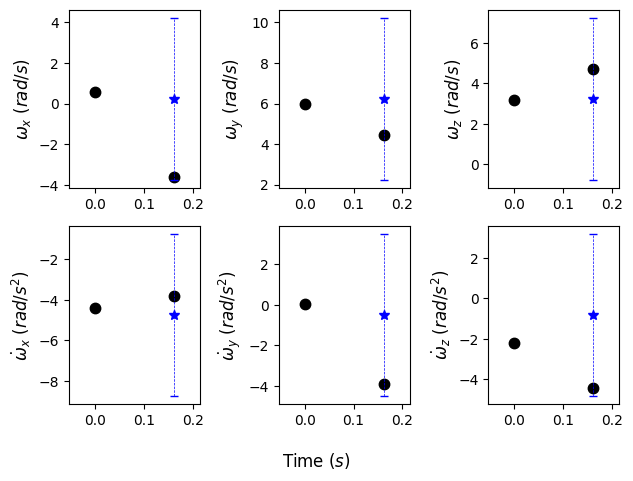

Current Batch Train Loss: -16.35841178894043

Current Batch Train Loss: -16.365253448486328

Current Batch Train Loss: -16.338836669921875

Current Batch Train Loss: -16.360246658325195

Current Batch Train Loss: -16.352767944335938

Current Batch Train Loss: -16.356882095336914

Current Batch Train Loss: -16.36369514465332

Current Batch Train Loss: -16.349851608276367

Current Batch Train Loss: -16.34581756591797

Current Batch Train Loss: -16.352888107299805

Current Batch Train Loss: -16.33945655822754

Current Batch Train Loss: -16.36338996887207

Current Batch Train Loss: -16.358245849609375

Current Batch Train Loss: -16.353450775146484

Current Batch Train Loss: -16.340654373168945

Current Batch Train Loss: -16.364086151123047

Current Batch Train Loss: -16.357389450073242

Current Batch Train Loss: -16.355812072753906

Current Batch Train Loss: -16.31483268737793

Current Batch Train Loss: -16.34722137451172

Current Batch Train Loss: -16.356502532958984

Current Batch Train 

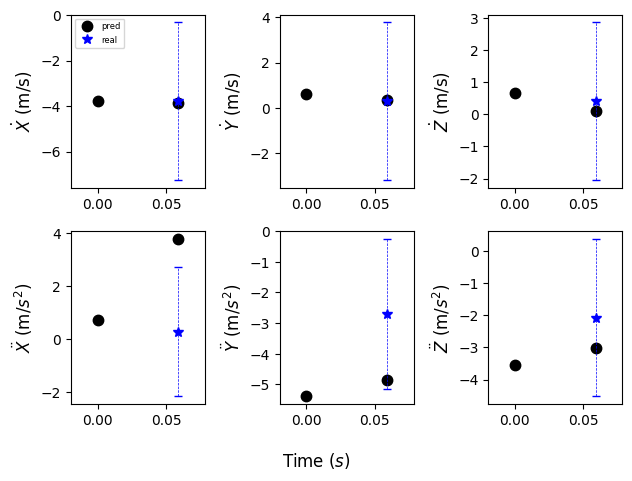

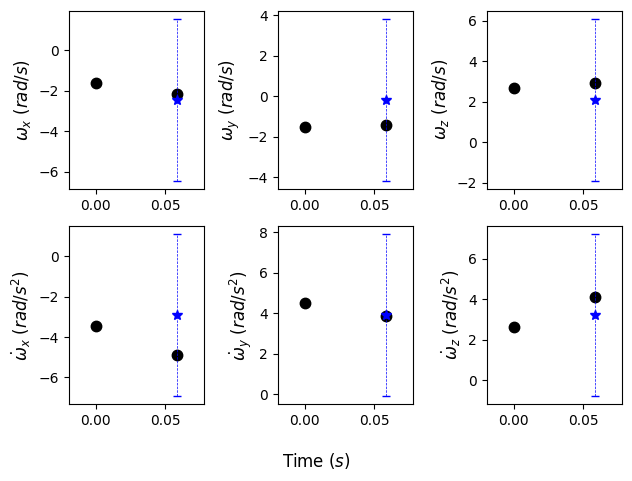

Current Batch Train Loss: -16.363204956054688

Current Batch Train Loss: -16.364654541015625

Current Batch Train Loss: -16.361980438232422

Current Batch Train Loss: -16.364715576171875

Current Batch Train Loss: -16.352785110473633

Current Batch Train Loss: -16.37204933166504

Current Batch Train Loss: -16.35479164123535

Current Batch Train Loss: -16.3618106842041

Current Batch Train Loss: -16.37640380859375

Current Batch Train Loss: -16.34734535217285

Current Batch Train Loss: -16.35394287109375

Current Batch Train Loss: -16.352943420410156

Current Batch Train Loss: -16.371381759643555

Current Batch Train Loss: -16.366453170776367

Current Batch Train Loss: -16.36887550354004

Current Batch Train Loss: -16.34535026550293

Current Batch Train Loss: -16.357892990112305

Current Batch Train Loss: -16.343341827392578

Current Batch Train Loss: -16.359458923339844

Current Batch Train Loss: -16.349775314331055

Current Batch Train Loss: -16.370025634765625

Current Batch Train Lo

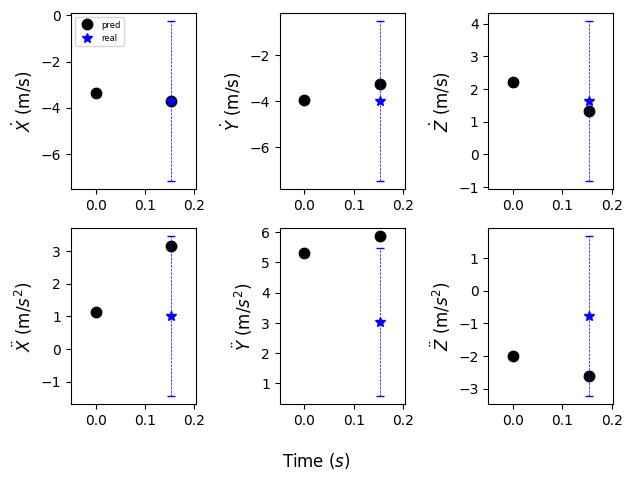

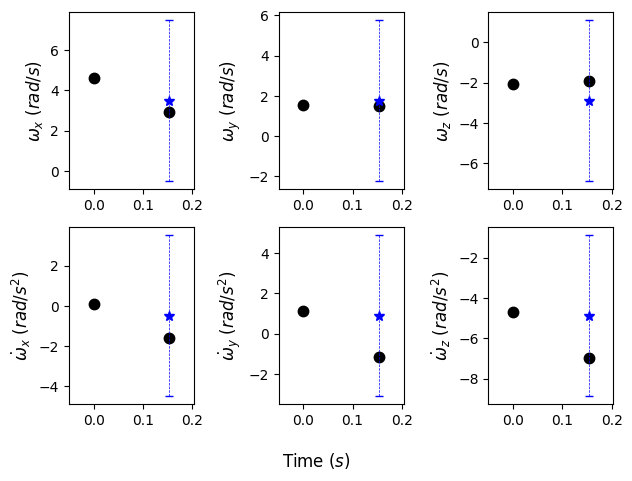

Current Batch Train Loss: -16.337858200073242

Current Batch Train Loss: -16.354740142822266

Current Batch Train Loss: -16.368974685668945

Current Batch Train Loss: -16.366939544677734

Current Batch Train Loss: -16.371850967407227

Current Batch Train Loss: -16.349523544311523

Current Batch Train Loss: -16.378355026245117

Current Batch Train Loss: -16.344627380371094

Current Batch Train Loss: -16.36444854736328

Current Batch Train Loss: -16.367084503173828

Current Batch Train Loss: -16.340673446655273

Current Batch Train Loss: -16.355926513671875

Current Batch Train Loss: -16.34754180908203

Current Batch Train Loss: -16.35881805419922

Current Batch Train Loss: -16.352741241455078

Current Batch Train Loss: -16.37030792236328

Current Batch Train Loss: -16.371631622314453

Current Batch Train Loss: -16.365421295166016

Current Batch Train Loss: -16.368513107299805

Current Batch Train Loss: -16.37552833557129

Current Batch Train Loss: -16.36428451538086

Current Batch Train

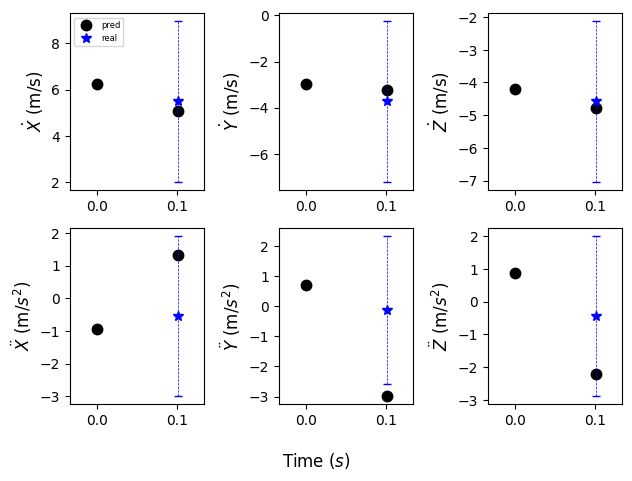

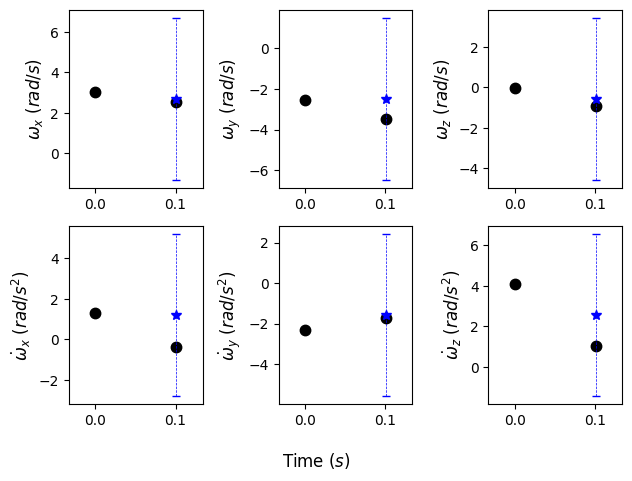

Current Batch Train Loss: -16.36125946044922

Current Batch Train Loss: -16.35357093811035

Current Batch Train Loss: -16.345252990722656

Current Batch Train Loss: -16.379684448242188

Current Batch Train Loss: -16.361862182617188

Current Batch Train Loss: -16.345205307006836

Current Batch Train Loss: -16.363279342651367

Current Batch Train Loss: -16.366579055786133

Current Batch Train Loss: -16.359628677368164

Current Batch Train Loss: -16.352327346801758

Current Batch Train Loss: -16.34636878967285

Current Batch Train Loss: -16.350372314453125

Current Batch Train Loss: -16.36650848388672

Current Batch Train Loss: -16.3629207611084

Current Batch Train Loss: -16.377025604248047

Current Batch Train Loss: -16.36130142211914

Current Batch Train Loss: -16.353229522705078

Current Batch Train Loss: -16.366533279418945

Current Batch Train Loss: -16.355180740356445

Current Batch Train Loss: -16.366655349731445

Current Batch Train Loss: -16.359458923339844

Current Batch Train 

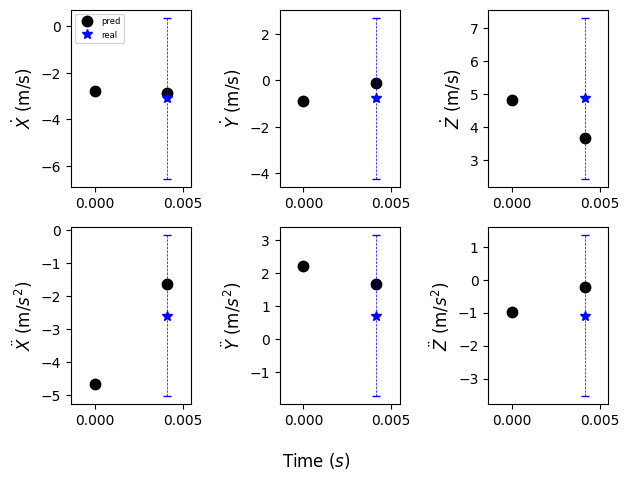

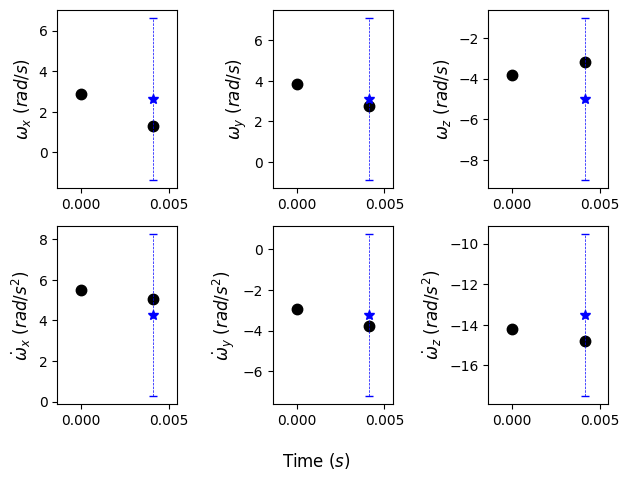

Current Batch Train Loss: -16.37040901184082

Current Batch Train Loss: -16.361976623535156

Current Batch Train Loss: -16.369691848754883

Current Batch Train Loss: -16.3632755279541

Current Batch Train Loss: -16.368331909179688

Current Batch Train Loss: -16.3752498626709

Current Batch Train Loss: -16.355728149414062

Current Batch Train Loss: -16.364246368408203

Current Batch Train Loss: -16.353181838989258

Current Batch Train Loss: -16.356061935424805

Current Batch Train Loss: -16.351882934570312

Current Batch Train Loss: -16.354909896850586

Current Batch Train Loss: -16.35717010498047

Current Batch Train Loss: -16.35284996032715

Current Batch Train Loss: -16.36355972290039

Current Batch Train Loss: -16.378427505493164

Current Batch Train Loss: -16.37076187133789

Current Batch Train Loss: -16.37017059326172

Current Batch Train Loss: -16.367671966552734

Current Batch Train Loss: -16.378122329711914

Current Batch Train Loss: -16.365739822387695

Current Batch Train Los

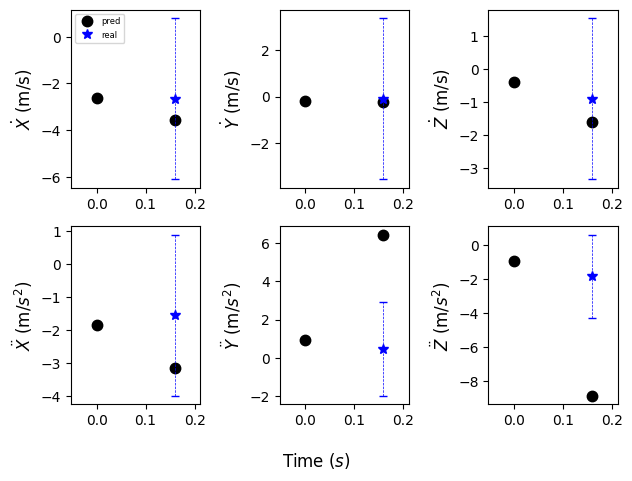

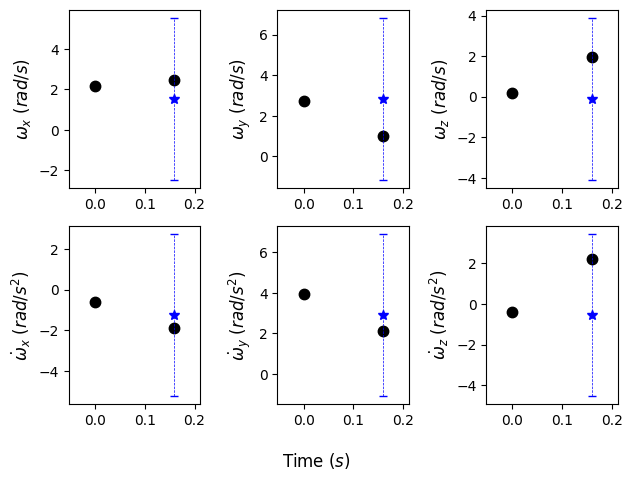

Current Batch Train Loss: -16.34040069580078

Current Batch Train Loss: -16.367387771606445

Current Batch Train Loss: -16.378000259399414

Current Batch Train Loss: -16.362077713012695

Current Batch Train Loss: -16.37697982788086

Current Batch Train Loss: -16.364425659179688

Current Batch Train Loss: -16.36319351196289

Current Batch Train Loss: -16.378318786621094

Current Batch Train Loss: -16.360855102539062

Current Batch Train Loss: -16.359447479248047

Current Batch Train Loss: -16.369686126708984

Current Batch Train Loss: -16.35511589050293

Current Batch Train Loss: -16.361970901489258

Current Batch Train Loss: -16.35324478149414

Current Batch Train Loss: -16.35274887084961

Current Batch Train Loss: -16.366243362426758

Current Batch Train Loss: -16.375471115112305

Current Batch Train Loss: -16.346179962158203

Current Batch Train Loss: -16.371810913085938

Current Batch Train Loss: -16.36448097229004

Current Batch Train Loss: -16.366199493408203

Current Batch Train 

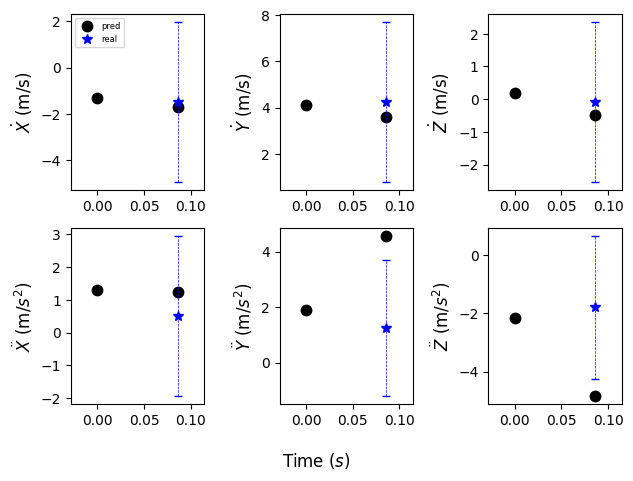

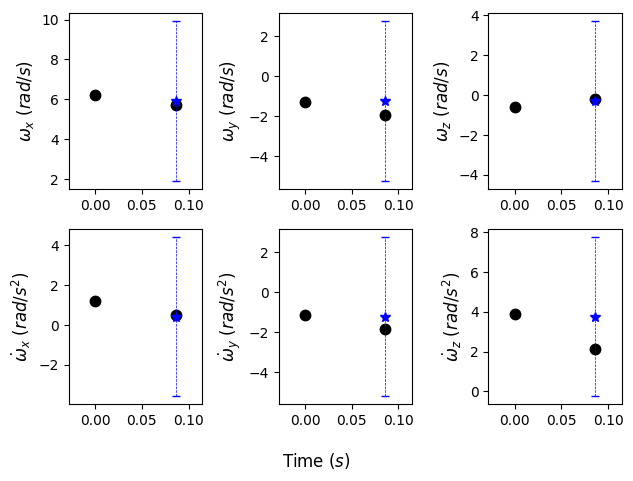

Current Batch Train Loss: -16.364683151245117

Current Batch Train Loss: -16.352523803710938

Current Batch Train Loss: -16.367107391357422

Current Batch Train Loss: -16.36004066467285

Current Batch Train Loss: -16.370203018188477

Current Batch Train Loss: -16.372962951660156

Current Batch Train Loss: -16.358631134033203

Current Batch Train Loss: -16.365276336669922

Current Batch Train Loss: -16.36297607421875

Current Batch Train Loss: -16.3475284576416

Current Batch Train Loss: -16.35110855102539

Current Batch Train Loss: -16.379337310791016

Current Batch Train Loss: -16.367849349975586

Current Batch Train Loss: -16.363914489746094

Current Batch Train Loss: -16.35848617553711

Current Batch Train Loss: -16.36149024963379

Current Batch Train Loss: -16.366107940673828

Current Batch Train Loss: -16.370967864990234

Current Batch Train Loss: -16.37017822265625

Current Batch Train Loss: -16.350902557373047

Current Batch Train Loss: -16.37356185913086

Current Batch Train Lo

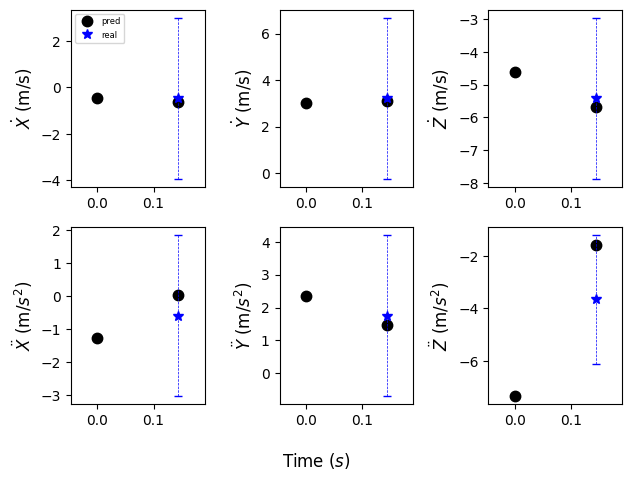

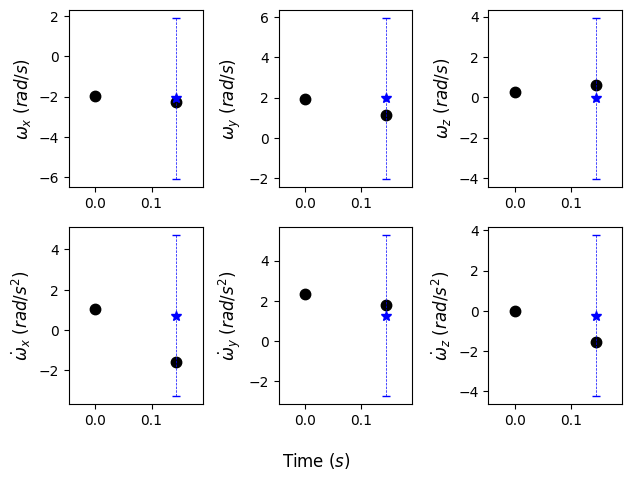

Current Batch Train Loss: -16.378589630126953

Current Batch Train Loss: -16.374835968017578

Current Batch Train Loss: -16.36020851135254

Current Batch Train Loss: -16.33548355102539

Current Batch Train Loss: -16.358125686645508

Current Batch Train Loss: -16.360334396362305

Current Batch Train Loss: -16.359779357910156

Current Batch Train Loss: -16.359121322631836

Current Batch Train Loss: -16.357507705688477

Current Batch Train Loss: -16.372814178466797

Current Batch Train Loss: -16.354923248291016

Current Batch Train Loss: -16.37079620361328

Current Batch Train Loss: -16.365663528442383

Current Batch Train Loss: -16.354299545288086

Current Batch Train Loss: -16.376693725585938

Current Batch Train Loss: -16.353822708129883

Current Batch Train Loss: -16.358205795288086

Current Batch Train Loss: -16.369333267211914

Current Batch Train Loss: -16.362483978271484

Current Batch Train Loss: -16.35685920715332

Current Batch Train Loss: -16.360401153564453

Current Batch Tra

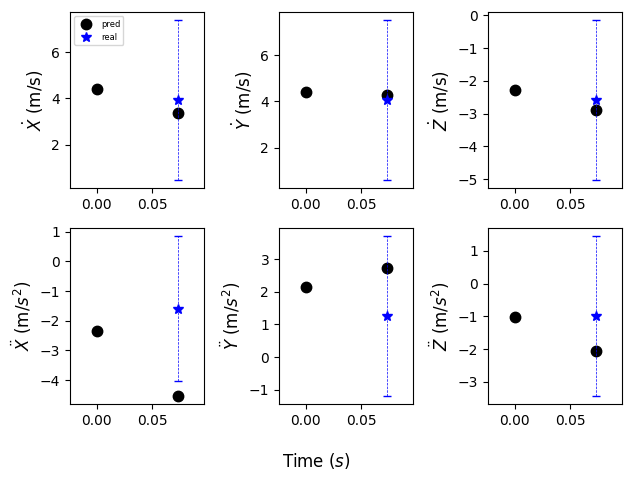

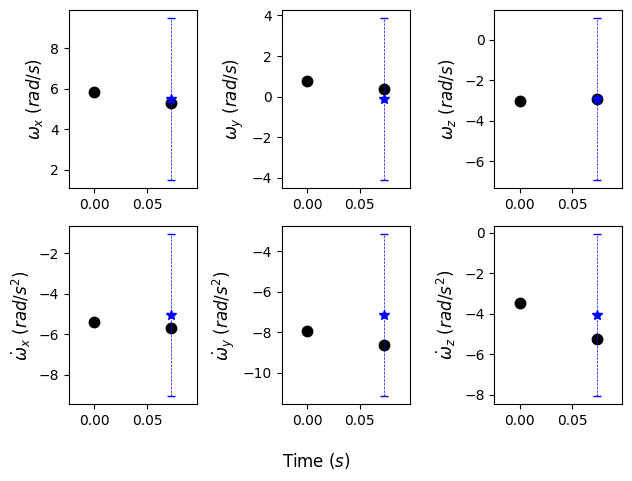

Current Batch Train Loss: -16.375043869018555

Current Batch Train Loss: -16.370330810546875

Current Batch Train Loss: -16.364246368408203

Current Batch Train Loss: -16.35162925720215

Current Batch Train Loss: -16.3503360748291

Current Batch Train Loss: -16.362957000732422

Current Batch Train Loss: -16.3530216217041

Current Batch Train Loss: -16.371482849121094

Current Batch Train Loss: -16.360401153564453

Current Batch Train Loss: -16.37006187438965

Current Batch Train Loss: -16.35539436340332

Current Batch Train Loss: -16.37753677368164

Current Batch Train Loss: -16.376863479614258

Current Batch Train Loss: -16.34033203125

Current Batch Train Loss: -16.376968383789062

Current Batch Train Loss: -16.354515075683594

Current Batch Train Loss: -16.355947494506836

Current Batch Train Loss: -16.370386123657227

Current Batch Train Loss: -16.372718811035156

Current Batch Train Loss: -16.37515640258789

Current Batch Train Loss: -16.36128044128418

Current Batch Train Loss: -

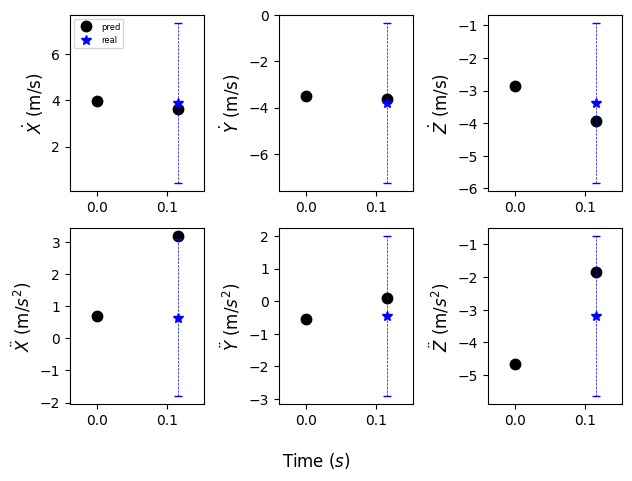

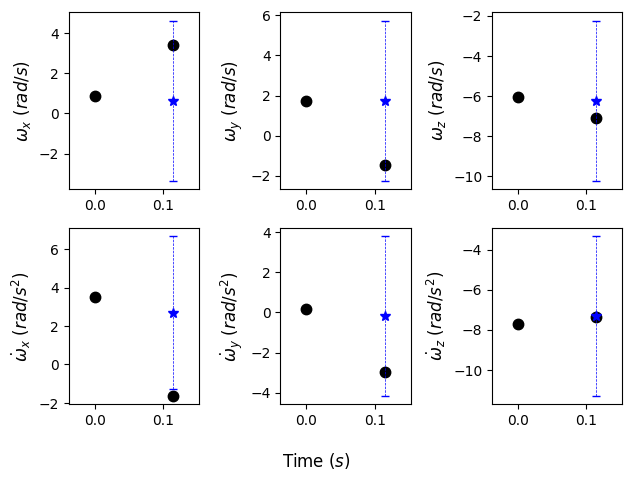

Current Batch Train Loss: -16.35515022277832

Current Batch Train Loss: -16.373655319213867

Current Batch Train Loss: -16.3862247467041

Current Batch Train Loss: -16.369401931762695

Current Batch Train Loss: -16.36572265625

Current Batch Train Loss: -16.37765884399414

Current Batch Train Loss: -16.364727020263672

Current Batch Train Loss: -16.33560562133789

Current Batch Train Loss: -16.37106704711914

Current Batch Train Loss: -16.371505737304688

Current Batch Train Loss: -16.370620727539062

Current Batch Train Loss: -16.365806579589844

Current Batch Train Loss: -16.358972549438477

Current Batch Train Loss: -16.365436553955078

Current Batch Train Loss: -16.356046676635742

Current Batch Train Loss: -16.348073959350586

Current Batch Train Loss: -16.351259231567383

Current Batch Train Loss: -16.365524291992188

Current Batch Train Loss: -16.380233764648438

Current Batch Train Loss: -16.386850357055664

Current Batch Train Loss: -16.364885330200195

Current Batch Train Los

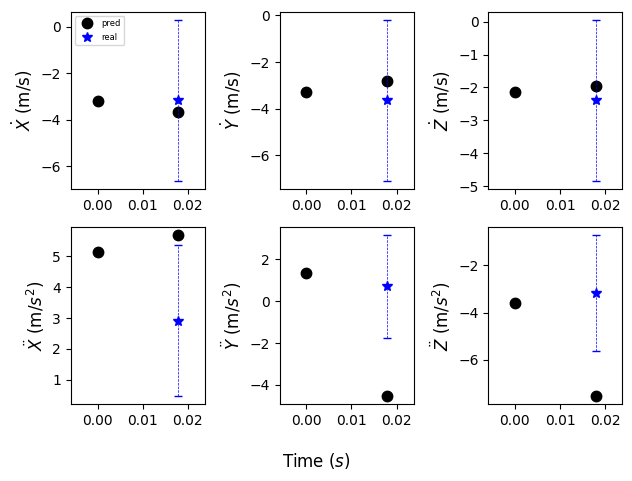

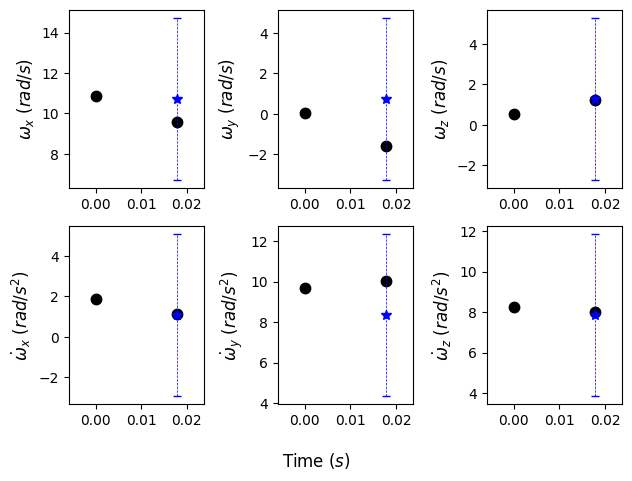

Current Batch Train Loss: -16.36136245727539

Current Batch Train Loss: -16.371416091918945

Current Batch Train Loss: -16.36661148071289

Current Batch Train Loss: -16.375856399536133

Current Batch Train Loss: -16.36140251159668

Current Batch Train Loss: -16.370325088500977

Current Batch Train Loss: -16.358627319335938

Current Batch Train Loss: -16.36773681640625

Current Batch Train Loss: -16.372156143188477

Current Batch Train Loss: -16.352338790893555

Current Batch Train Loss: -16.367738723754883

Current Batch Train Loss: -16.36672019958496

Current Batch Train Loss: -16.35479164123535

Current Batch Train Loss: -16.35716438293457

Current Batch Train Loss: -16.346214294433594

Current Batch Train Loss: -16.350160598754883

Current Batch Train Loss: -16.370187759399414

Current Batch Train Loss: -16.362123489379883

Current Batch Train Loss: -16.366130828857422

Current Batch Train Loss: -16.36251449584961

Current Batch Train Loss: -16.376583099365234

Current Batch Train L

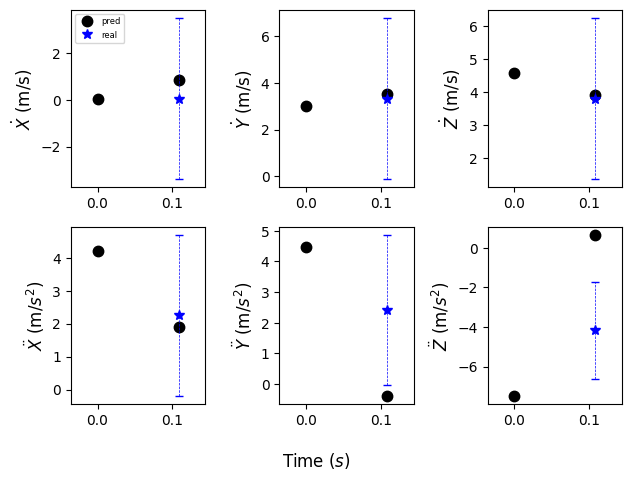

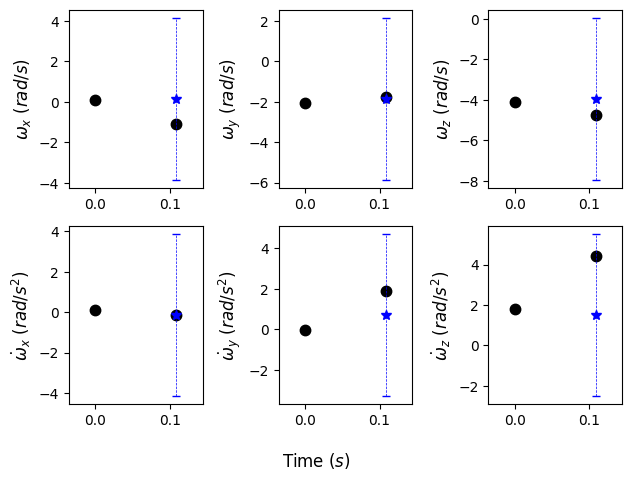

Current Batch Train Loss: -16.370162963867188

Current Batch Train Loss: -16.36368751525879

Current Batch Train Loss: -16.37603759765625

Current Batch Train Loss: -16.355796813964844

Current Batch Train Loss: -16.354764938354492

Current Batch Train Loss: -16.36312484741211

Current Batch Train Loss: -16.36734390258789

Current Batch Train Loss: -16.37737274169922

Current Batch Train Loss: -16.381765365600586

Current Batch Train Loss: -16.37165069580078

Current Batch Train Loss: -16.369335174560547

Current Batch Train Loss: -16.363462448120117

Current Batch Train Loss: -16.362438201904297

Current Batch Train Loss: -16.385204315185547

Current Batch Train Loss: -16.364181518554688

Current Batch Train Loss: -16.373022079467773

Current Batch Train Loss: -16.367721557617188

Current Batch Train Loss: -16.369571685791016

Current Batch Train Loss: -16.368682861328125

Current Batch Train Loss: -16.367050170898438

Current Batch Train Loss: -16.360258102416992

Current Batch Train

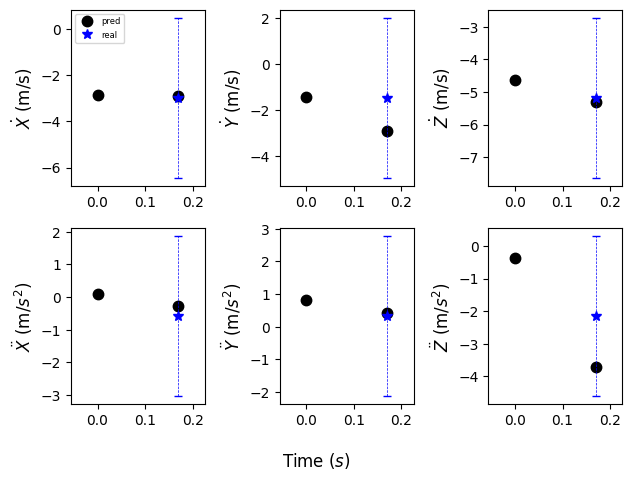

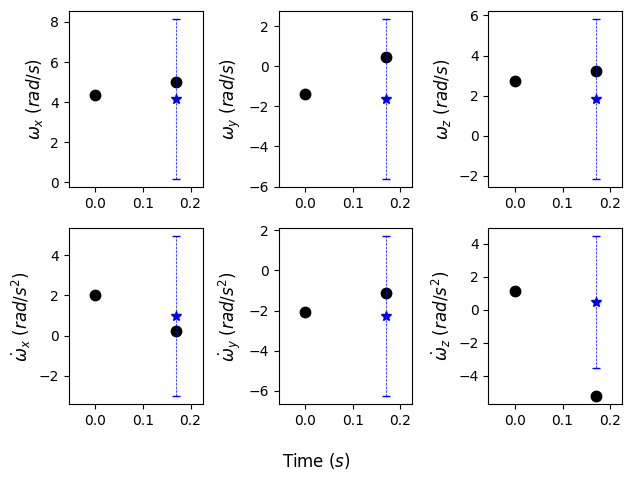

Current Batch Train Loss: -16.35296630859375

Current Batch Train Loss: -16.33355712890625

Current Batch Train Loss: -16.347702026367188

Current Batch Train Loss: -16.362110137939453

Current Batch Train Loss: -16.35352325439453

Current Batch Train Loss: -16.365947723388672

Current Batch Train Loss: -16.37135124206543

Current Batch Train Loss: -16.36931037902832

Current Batch Train Loss: -16.384479522705078

Current Batch Train Loss: -16.358318328857422

Current Batch Train Loss: -16.363801956176758

Current Batch Train Loss: -16.372516632080078

Current Batch Train Loss: -16.376205444335938

Current Batch Train Loss: -16.346046447753906

Current Batch Train Loss: -16.37309455871582

Current Batch Train Loss: -16.375505447387695

Current Batch Train Loss: -16.35140609741211

Current Batch Train Loss: -16.371740341186523

Current Batch Train Loss: -16.362077713012695

Current Batch Train Loss: -16.364471435546875

Current Batch Train Loss: -16.368240356445312

Current Batch Train 

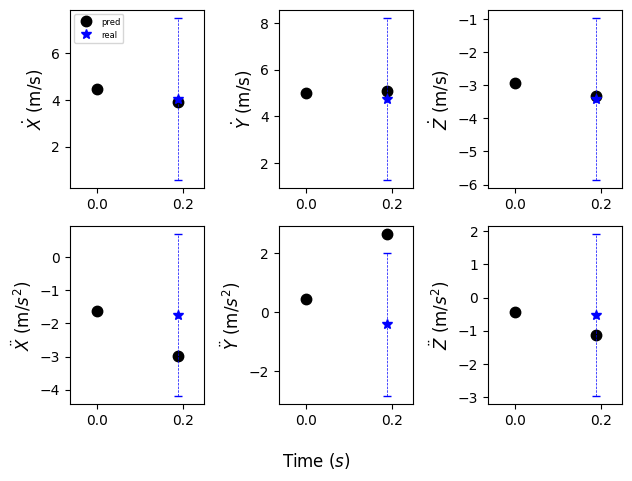

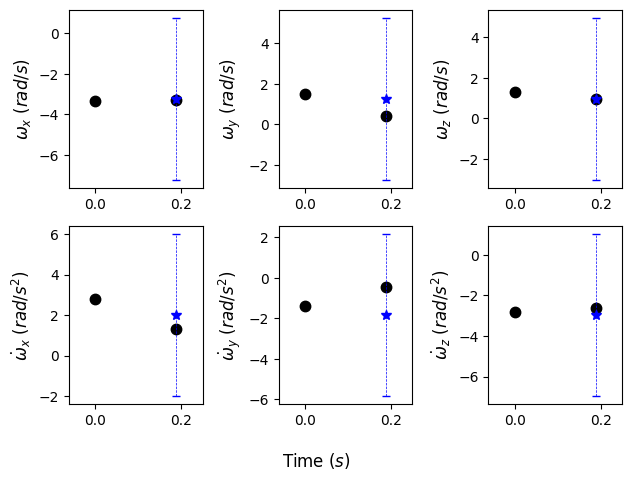

Current Batch Train Loss: -16.372915267944336

Current Batch Train Loss: -16.374250411987305

Current Batch Train Loss: -16.353519439697266

Current Batch Train Loss: -16.363168716430664

Current Batch Train Loss: -16.370891571044922

Current Batch Train Loss: -16.386823654174805

Current Batch Train Loss: -16.37746238708496

Current Batch Train Loss: -16.363677978515625

Current Batch Train Loss: -16.365516662597656

Current Batch Train Loss: -16.369657516479492

Current Batch Train Loss: -16.36312484741211

Current Batch Train Loss: -16.369335174560547

Current Batch Train Loss: -16.3525333404541

Current Batch Train Loss: -16.358842849731445

Current Batch Train Loss: -16.36907386779785

Current Batch Train Loss: -16.377689361572266

Current Batch Train Loss: -16.35240936279297

Current Batch Train Loss: -16.342885971069336

Current Batch Train Loss: -16.37110710144043

Current Batch Train Loss: -16.38459014892578

Current Batch Train Loss: -16.36321258544922

Current Batch Train Lo

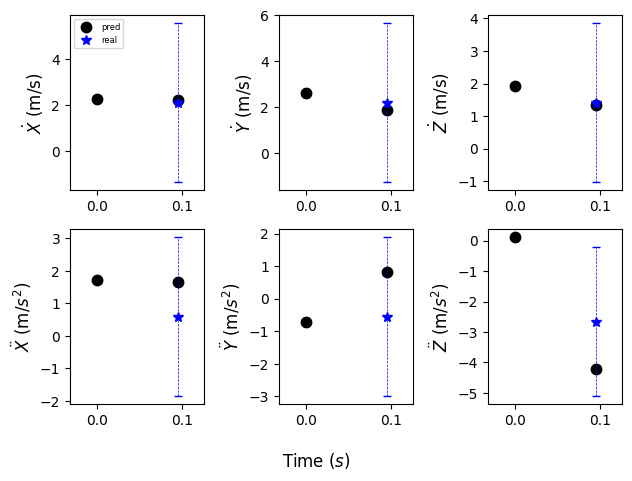

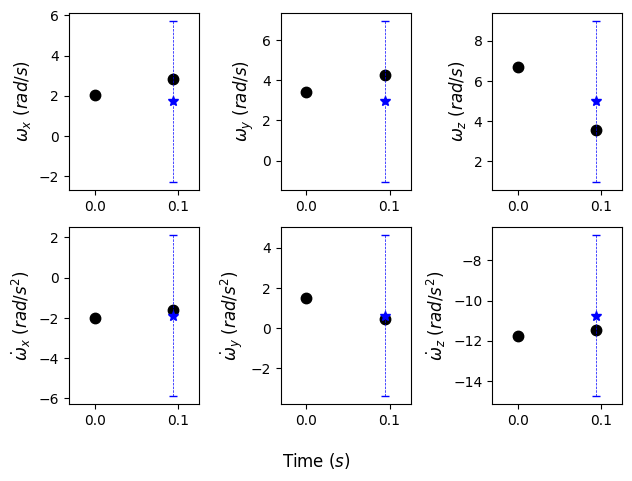

Current Batch Train Loss: -16.36005401611328

Current Batch Train Loss: -16.37831687927246

Current Batch Train Loss: -16.364974975585938

Current Batch Train Loss: -16.35682487487793

Current Batch Train Loss: -16.357912063598633

Current Batch Train Loss: -16.378679275512695

Current Batch Train Loss: -16.375736236572266

Current Batch Train Loss: -16.374515533447266

Current Batch Train Loss: -16.38141441345215

Current Batch Train Loss: -16.378320693969727

Current Batch Train Loss: -16.36882209777832

Current Batch Train Loss: -16.37286376953125

Current Batch Train Loss: -16.38131332397461

Current Batch Train Loss: -16.357563018798828

Current Batch Train Loss: -16.370532989501953

Current Batch Train Loss: -16.378421783447266

Current Batch Train Loss: -16.365821838378906

Current Batch Train Loss: -16.365793228149414

Current Batch Train Loss: -16.37080192565918

Current Batch Train Loss: -16.359752655029297

Current Batch Train Loss: -16.376726150512695

Current Batch Train L

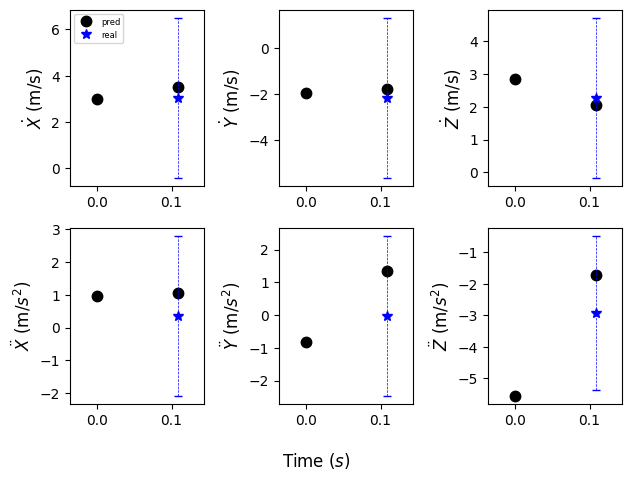

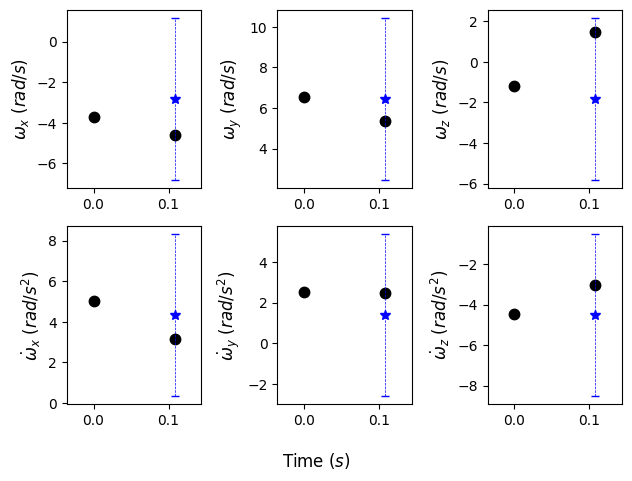

Current Batch Train Loss: -16.363801956176758

Current Batch Train Loss: -16.368497848510742

Current Batch Train Loss: -16.38756561279297

Current Batch Train Loss: -16.3696346282959

Current Batch Train Loss: -16.367176055908203

Current Batch Train Loss: -16.35136604309082

Current Batch Train Loss: -16.37081527709961

Current Batch Train Loss: -16.363615036010742

Current Batch Train Loss: -16.384532928466797

Current Batch Train Loss: -16.36843490600586

Current Batch Train Loss: -16.368303298950195

Current Batch Train Loss: -16.378612518310547

Current Batch Train Loss: -16.366161346435547

Current Batch Train Loss: -16.3813533782959

Current Batch Train Loss: -16.36100959777832

Current Batch Train Loss: -16.36050796508789

Current Batch Train Loss: -16.369836807250977

Current Batch Train Loss: -16.358686447143555

Current Batch Train Loss: -16.371334075927734

Current Batch Train Loss: -16.363292694091797

Current Batch Train Loss: -16.37044906616211

Current Batch Train Loss

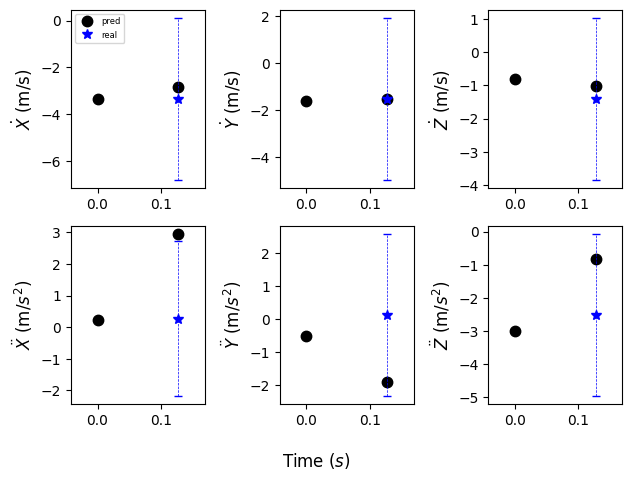

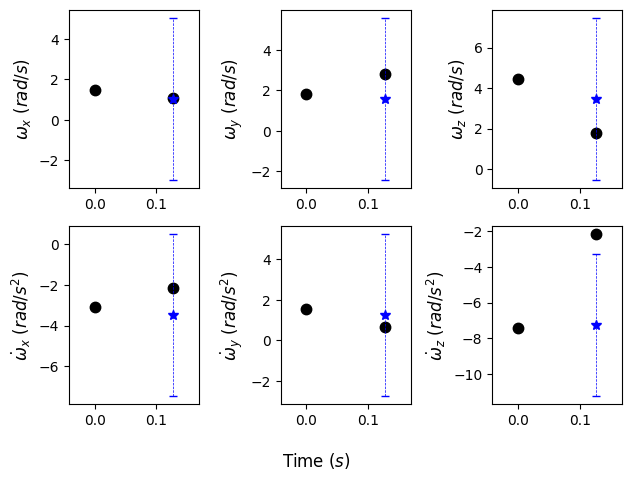

Current Batch Train Loss: -16.368806838989258

Current Batch Train Loss: -16.354604721069336

Current Batch Train Loss: -16.365365982055664

Current Batch Train Loss: -16.357746124267578

Current Batch Train Loss: -16.374723434448242

Current Batch Train Loss: -16.36786651611328

Current Batch Train Loss: -16.3704776763916

Current Batch Train Loss: -16.35736656188965

Current Batch Train Loss: -16.366806030273438

Current Batch Train Loss: -16.361732482910156

Current Batch Train Loss: -16.377391815185547

Current Batch Train Loss: -16.36980438232422

Current Batch Train Loss: -16.378925323486328

Current Batch Train Loss: -16.379852294921875

Current Batch Train Loss: -16.352584838867188

Current Batch Train Loss: -16.384723663330078

Current Batch Train Loss: -16.3690128326416

Current Batch Train Loss: -16.35695457458496

Current Batch Train Loss: -16.376792907714844

Current Batch Train Loss: -16.384023666381836

Current Batch Train Loss: -16.371545791625977

Current Batch Train L

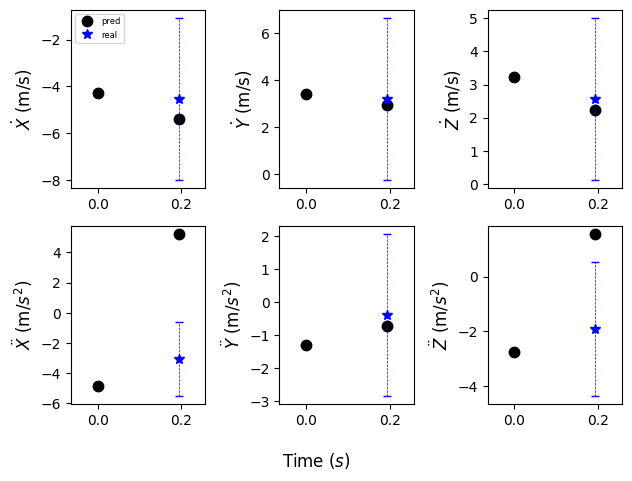

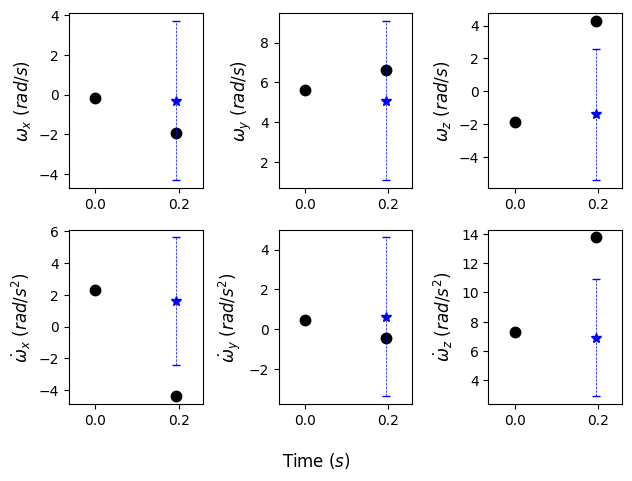

Current Batch Train Loss: -16.35213279724121

Current Batch Train Loss: -16.368789672851562

Current Batch Train Loss: -16.37892723083496

Current Batch Train Loss: -16.365428924560547

Current Batch Train Loss: -16.373802185058594

Current Batch Train Loss: -16.376575469970703

Current Batch Train Loss: -16.365692138671875

Current Batch Train Loss: -16.379940032958984

Current Batch Train Loss: -16.380393981933594

Current Batch Train Loss: -16.364593505859375

Current Batch Train Loss: -16.35877227783203

Current Batch Train Loss: -16.37958335876465

Current Batch Train Loss: -16.361968994140625

Current Batch Train Loss: -16.367000579833984

Current Batch Train Loss: -16.36587142944336

Current Batch Train Loss: -16.35284996032715

Current Batch Train Loss: -16.378429412841797

Current Batch Train Loss: -16.374610900878906

Current Batch Train Loss: -16.373632431030273

Current Batch Train Loss: -16.375308990478516

Current Batch Train Loss: -16.37196159362793

Current Batch Train 

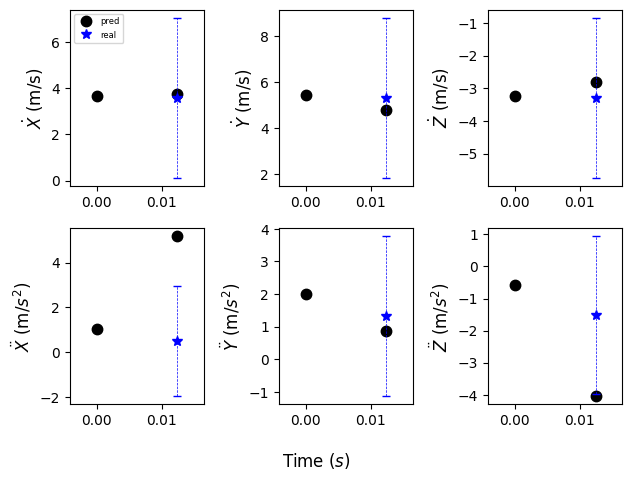

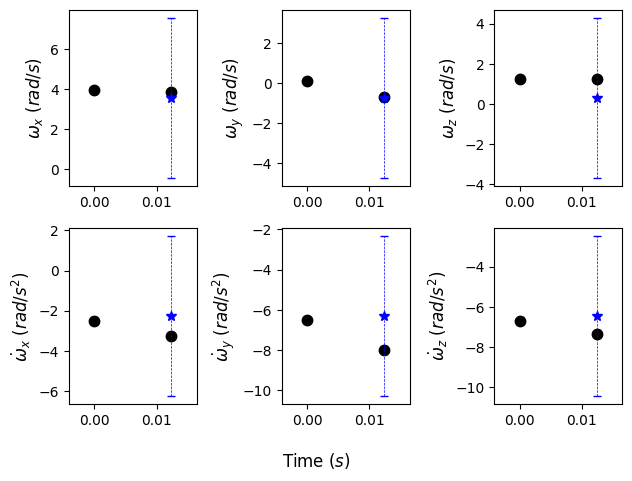

Current Batch Train Loss: -16.362131118774414

Current Batch Train Loss: -16.37550163269043

Current Batch Train Loss: -16.34849739074707

Current Batch Train Loss: -16.378786087036133

Current Batch Train Loss: -16.36643409729004

Current Batch Train Loss: -16.366493225097656

Current Batch Train Loss: -16.35637855529785

Current Batch Train Loss: -16.372533798217773

Current Batch Train Loss: -16.358522415161133

Current Batch Train Loss: -16.36667823791504

Current Batch Train Loss: -16.36772346496582

Current Batch Train Loss: -16.367055892944336

Current Batch Train Loss: -16.366323471069336

Current Batch Train Loss: -16.35818099975586

Current Batch Train Loss: -16.38448715209961

Current Batch Train Loss: -16.34453773498535

Current Batch Train Loss: -16.367263793945312

Current Batch Train Loss: -16.36365509033203

Current Batch Train Loss: -16.381816864013672

Current Batch Train Loss: -16.358524322509766

Current Batch Train Loss: -16.37221336364746

Current Batch Train Loss

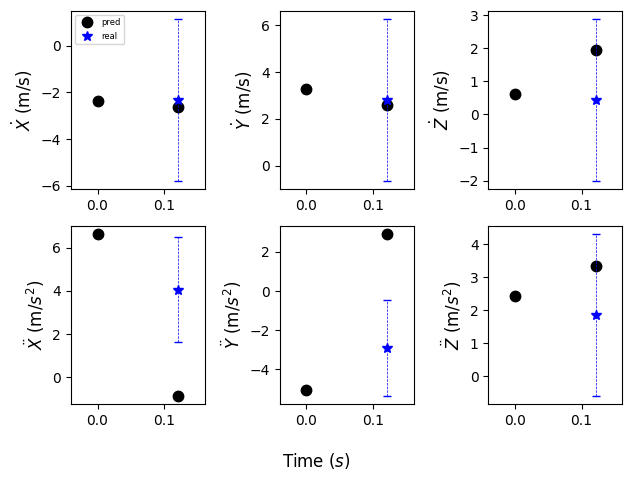

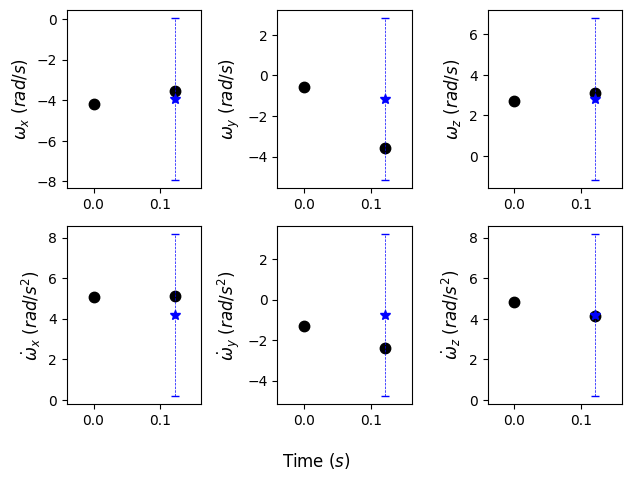

Current Batch Train Loss: -16.364768981933594

Current Batch Train Loss: -16.377771377563477

Current Batch Train Loss: -16.352230072021484

Current Batch Train Loss: -16.381860733032227

Current Batch Train Loss: -16.371135711669922

Current Batch Train Loss: -16.377120971679688

Current Batch Train Loss: -16.3682918548584

Current Batch Train Loss: -16.360912322998047

Current Batch Train Loss: -16.37140655517578

Current Batch Train Loss: -16.365610122680664

Current Batch Train Loss: -16.371992111206055

Current Batch Train Loss: -16.361448287963867

Current Batch Train Loss: -16.367738723754883

Current Batch Train Loss: -16.365312576293945

Current Batch Train Loss: -16.370397567749023

Current Batch Train Loss: -16.373640060424805

Current Batch Train Loss: -16.362028121948242

Current Batch Train Loss: -16.382858276367188

Current Batch Train Loss: -16.38924217224121

Current Batch Train Loss: -16.364356994628906

Current Batch Train Loss: -16.382301330566406

Current Batch Tra

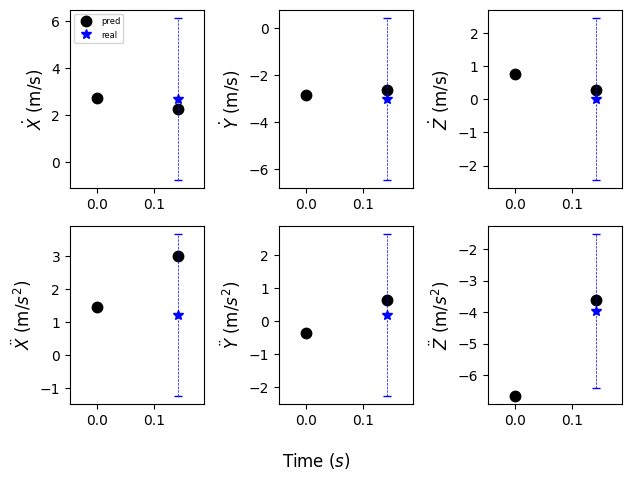

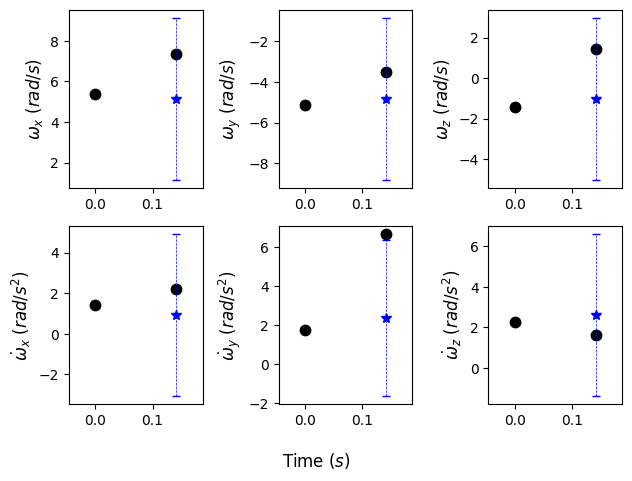

Current Batch Train Loss: -16.376232147216797

Current Batch Train Loss: -16.3674259185791

Current Batch Train Loss: -16.35192108154297

Current Batch Train Loss: -16.368940353393555

Current Batch Train Loss: -16.361665725708008

Current Batch Train Loss: -16.374298095703125

Current Batch Train Loss: -16.38092803955078

Current Batch Train Loss: -16.382600784301758

Current Batch Train Loss: -16.381282806396484

Current Batch Train Loss: -16.374643325805664

Current Batch Train Loss: -16.365432739257812

Current Batch Train Loss: -16.35373878479004

Current Batch Train Loss: -16.354829788208008

Current Batch Train Loss: -16.3768253326416

Current Batch Train Loss: -16.365446090698242

Current Batch Train Loss: -16.373788833618164

Current Batch Train Loss: -16.379796981811523

Current Batch Train Loss: -16.36335563659668

Current Batch Train Loss: -16.380685806274414

Current Batch Train Loss: -16.363615036010742

Current Batch Train Loss: -16.38541030883789

Current Batch Train Lo

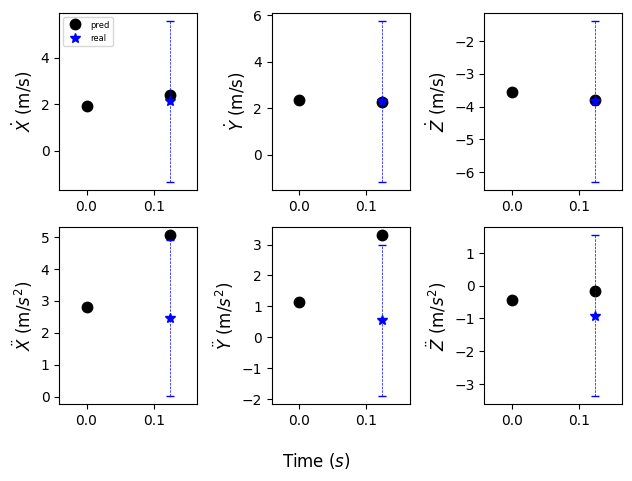

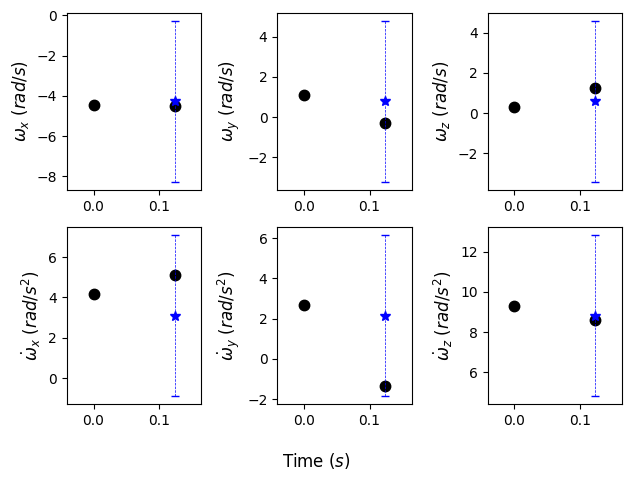

Current Batch Train Loss: -16.3618221282959

Current Batch Train Loss: -16.37150764465332

Current Batch Train Loss: -16.357431411743164

Current Batch Train Loss: -16.372234344482422

Current Batch Train Loss: -16.387651443481445

Current Batch Train Loss: -16.355039596557617

Current Batch Train Loss: -16.35761833190918

Current Batch Train Loss: -16.366687774658203

Current Batch Train Loss: -16.384241104125977

Current Batch Train Loss: -16.378217697143555

Current Batch Train Loss: -16.37403106689453

Current Batch Train Loss: -16.377689361572266

Current Batch Train Loss: -16.364364624023438

Current Batch Train Loss: -16.366519927978516

Current Batch Train Loss: -16.377866744995117

Current Batch Train Loss: -16.378252029418945

Current Batch Train Loss: -16.3750057220459

Current Batch Train Loss: -16.357025146484375

Current Batch Train Loss: -16.36771583557129

Current Batch Train Loss: -16.366443634033203

Current Batch Train Loss: -16.366525650024414

Current Batch Train L

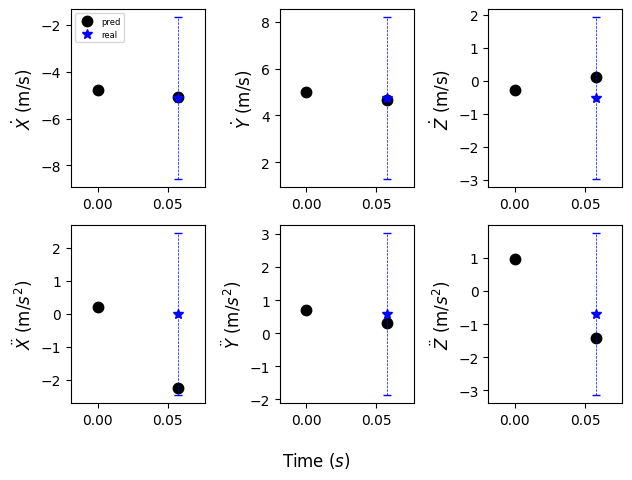

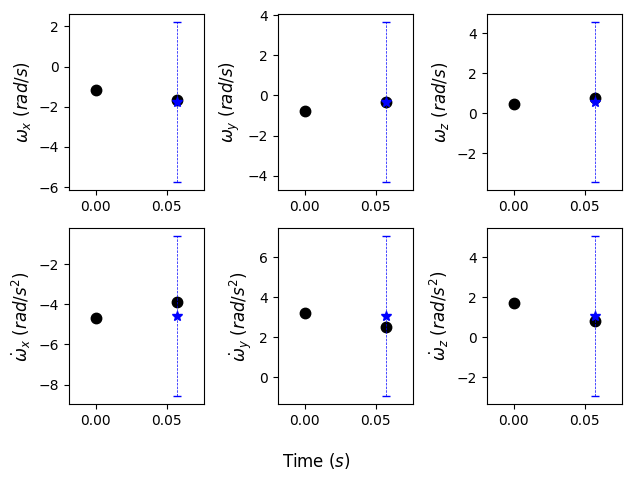

Current Batch Train Loss: -16.36090850830078

Current Batch Train Loss: -16.37844467163086

Current Batch Train Loss: -16.355247497558594

Current Batch Train Loss: -16.378896713256836

Current Batch Train Loss: -16.370311737060547

Current Batch Train Loss: -16.37038803100586

Current Batch Train Loss: -16.378704071044922

Current Batch Train Loss: -16.367528915405273

Current Batch Train Loss: -16.356962203979492

Current Batch Train Loss: -16.36216163635254

Current Batch Train Loss: -16.379302978515625

Current Batch Train Loss: -16.37701988220215

Current Batch Train Loss: -16.386402130126953

Current Batch Train Loss: -16.361757278442383

Current Batch Train Loss: -16.358821868896484

Current Batch Train Loss: -16.3669490814209

Current Batch Train Loss: -16.355335235595703

Current Batch Train Loss: -16.374589920043945

Current Batch Train Loss: -16.368431091308594

Current Batch Train Loss: -16.374919891357422

Current Batch Train Loss: -16.361738204956055

Current Batch Train 

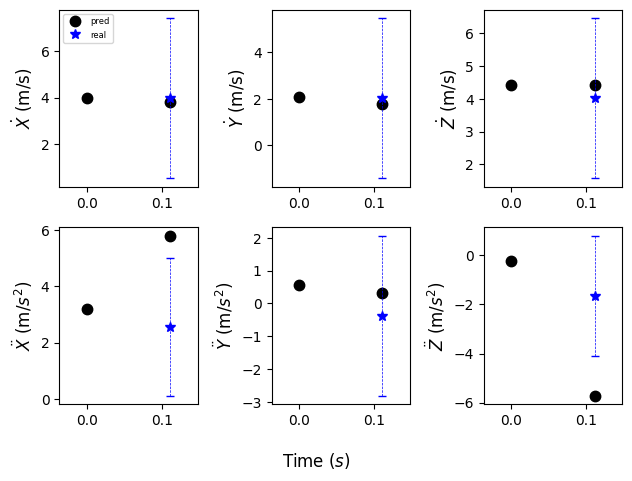

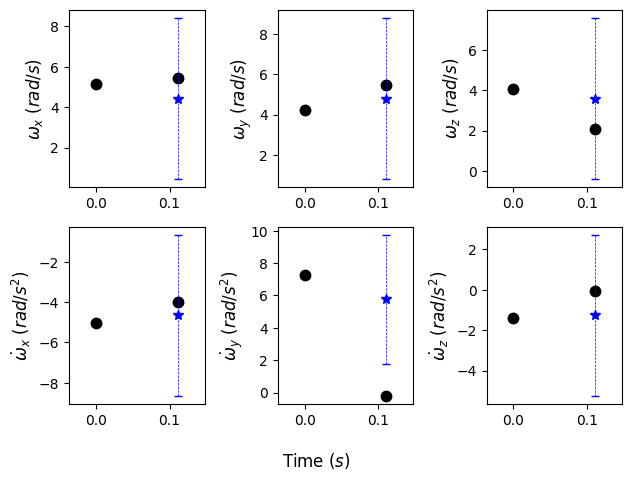

Current Batch Train Loss: -16.35622215270996

Current Batch Train Loss: -16.378387451171875

Current Batch Train Loss: -16.382614135742188

Current Batch Train Loss: -16.375751495361328

Current Batch Train Loss: -16.371902465820312

Current Batch Train Loss: -16.371313095092773

Current Batch Train Loss: -16.357641220092773

Current Batch Train Loss: -16.374990463256836

Current Batch Train Loss: -16.37946319580078

Current Batch Train Loss: -16.36072540283203

Current Batch Train Loss: -16.371326446533203

Current Batch Train Loss: -16.36865234375

Current Batch Train Loss: -16.3632755279541

Current Batch Train Loss: -16.3549861907959

Current Batch Train Loss: -16.36754035949707

Current Batch Train Loss: -16.392765045166016

Current Batch Train Loss: -16.35770034790039

Current Batch Train Loss: -16.37238883972168

Current Batch Train Loss: -16.365676879882812

Current Batch Train Loss: -16.36625862121582

Current Batch Train Loss: -16.382108688354492

Current Batch Train Loss: -1

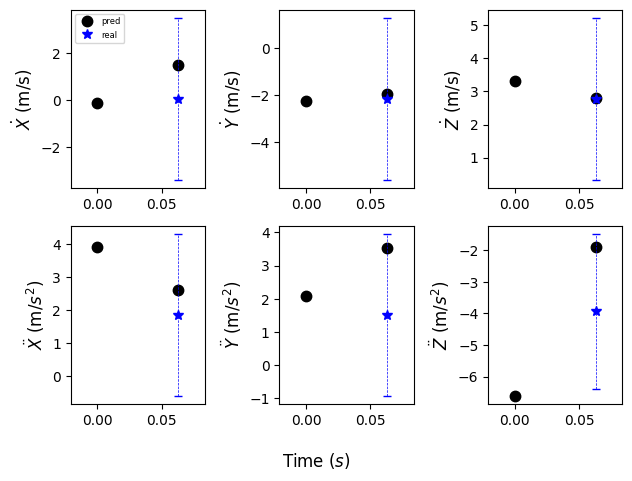

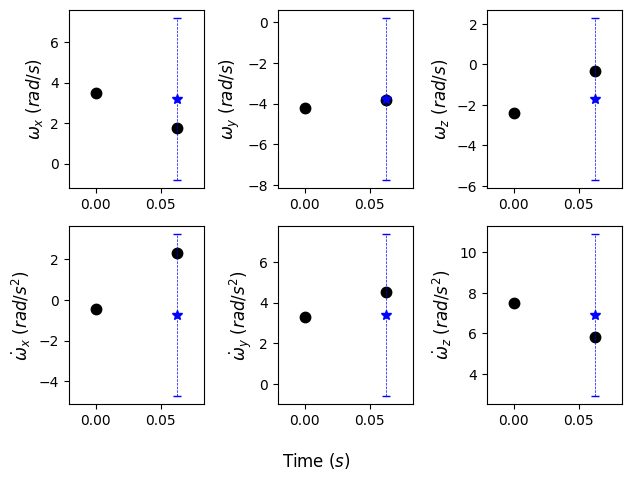

Current Batch Train Loss: -16.36601448059082

Current Batch Train Loss: -16.369003295898438

Current Batch Train Loss: -16.370336532592773

Current Batch Train Loss: -16.357248306274414

Current Batch Train Loss: -16.361486434936523

Current Batch Train Loss: -16.362646102905273

Current Batch Train Loss: -16.378751754760742

Current Batch Train Loss: -16.369735717773438

Current Batch Train Loss: -16.381088256835938

Current Batch Train Loss: -16.376890182495117

Current Batch Train Loss: -16.368133544921875

Current Batch Train Loss: -16.378368377685547

Current Batch Train Loss: -16.358665466308594

Current Batch Train Loss: -16.382577896118164

Current Batch Train Loss: -16.37668800354004

Current Batch Train Loss: -16.380998611450195

Current Batch Train Loss: -16.37291717529297

Current Batch Train Loss: -16.368427276611328

Current Batch Train Loss: -16.369611740112305

Current Batch Train Loss: -16.3681697845459

Current Batch Train Loss: -16.36563491821289

Current Batch Train

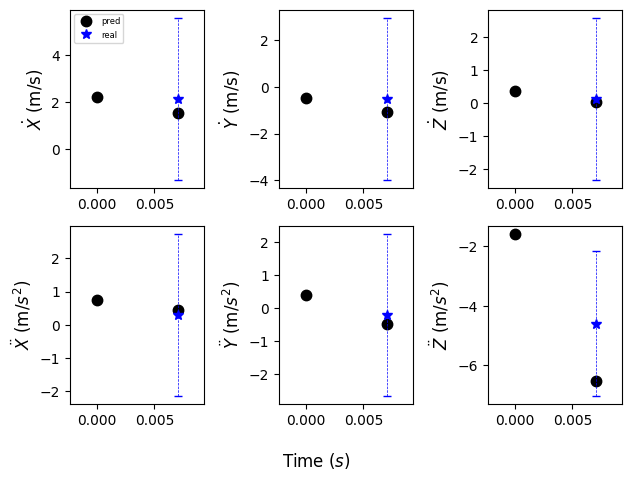

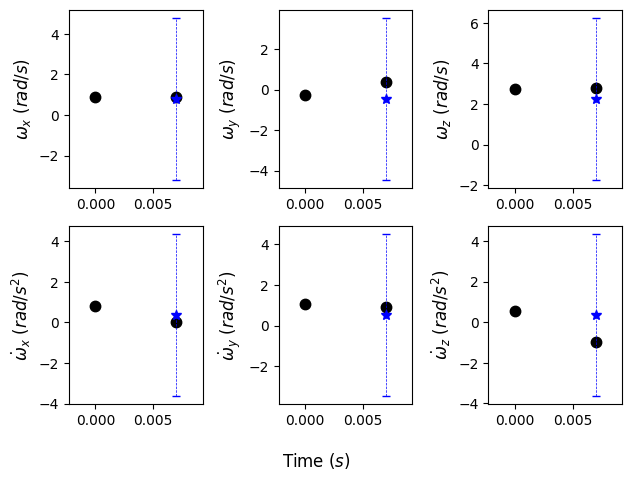

Current Batch Train Loss: -16.372974395751953

Current Batch Train Loss: -16.374744415283203

Current Batch Train Loss: -16.370351791381836

Current Batch Train Loss: -16.379310607910156

Current Batch Train Loss: -16.376859664916992

Current Batch Train Loss: -16.359050750732422

Current Batch Train Loss: -16.346323013305664

Current Batch Train Loss: -16.369140625

Current Batch Train Loss: -16.385473251342773

Current Batch Train Loss: -16.37818145751953

Current Batch Train Loss: -16.369678497314453

Current Batch Train Loss: -16.36675262451172

Current Batch Train Loss: -16.369064331054688

Current Batch Train Loss: -16.35249137878418

Current Batch Train Loss: -16.37071418762207

Current Batch Train Loss: -16.37221336364746

Current Batch Train Loss: -16.37200164794922

Current Batch Train Loss: -16.365711212158203

Current Batch Train Loss: -16.380268096923828

Current Batch Train Loss: -16.38161849975586

Current Batch Train Loss: -16.343582153320312

Current Batch Train Loss: 

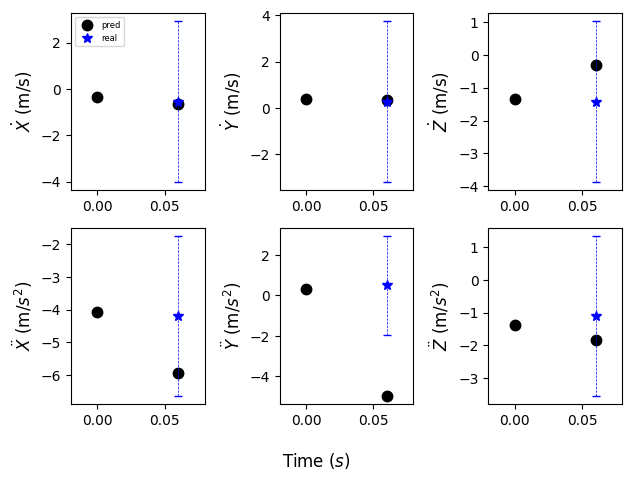

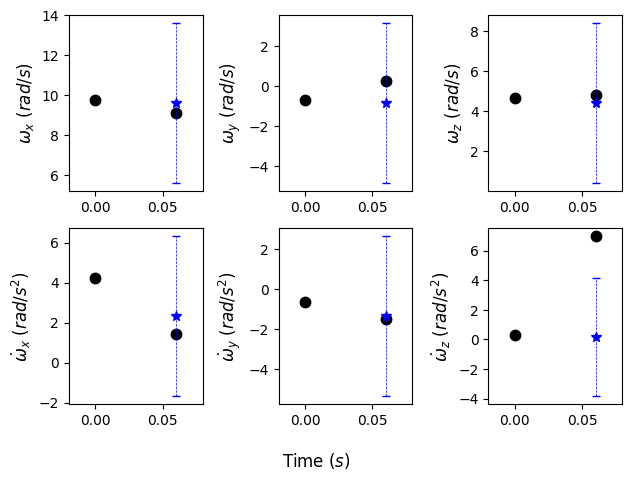

Current Batch Train Loss: -16.36707878112793

Current Batch Train Loss: -16.37711524963379

Current Batch Train Loss: -16.370243072509766

Current Batch Train Loss: -16.3587646484375

Current Batch Train Loss: -16.368621826171875

Current Batch Train Loss: -16.36505889892578

Current Batch Train Loss: -16.378192901611328

Current Batch Train Loss: -16.38238525390625

Current Batch Train Loss: -16.377426147460938

Current Batch Train Loss: -16.3702335357666

Current Batch Train Loss: -16.374147415161133

Current Batch Train Loss: -16.369796752929688

Current Batch Train Loss: -16.36890411376953

Current Batch Train Loss: -16.369626998901367

Current Batch Train Loss: -16.374353408813477

Current Batch Train Loss: -16.370256423950195

Current Batch Train Loss: -16.377029418945312

Current Batch Train Loss: -16.3829288482666

Current Batch Train Loss: -16.386940002441406

Current Batch Train Loss: -16.36251449584961

Current Batch Train Loss: -16.36233139038086

Current Batch Train Loss: 

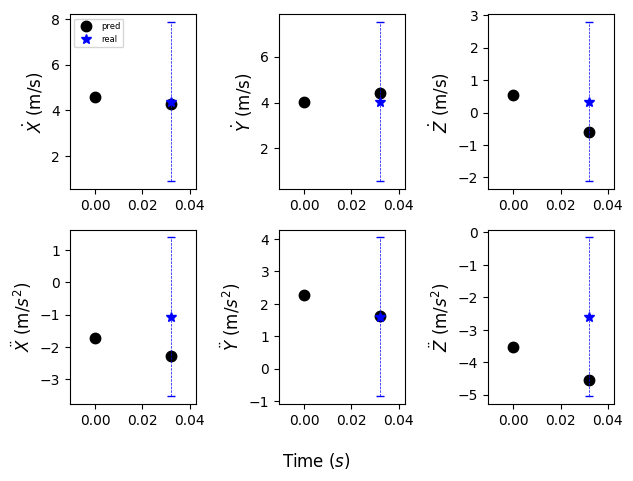

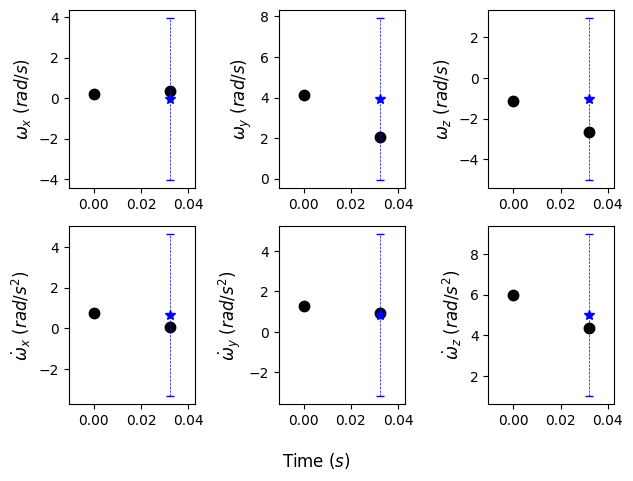

Current Batch Train Loss: -16.36587142944336

Current Batch Train Loss: -16.36957359313965

Current Batch Train Loss: -16.372806549072266

Current Batch Train Loss: -16.36720085144043

Current Batch Train Loss: -16.378992080688477

Current Batch Train Loss: -16.379413604736328

Current Batch Train Loss: -16.38969612121582

Current Batch Train Loss: -16.387109756469727

Current Batch Train Loss: -16.36081314086914

Current Batch Train Loss: -16.370582580566406

Current Batch Train Loss: -16.376514434814453

Current Batch Train Loss: -16.373090744018555

Current Batch Train Loss: -16.373741149902344

Current Batch Train Loss: -16.370338439941406

Current Batch Train Loss: -16.367345809936523

Current Batch Train Loss: -16.363943099975586

Current Batch Train Loss: -16.362037658691406

Current Batch Train Loss: -16.383363723754883

Current Batch Train Loss: -16.37359046936035

Current Batch Train Loss: -16.376386642456055

Current Batch Train Loss: -16.378673553466797

Current Batch Train

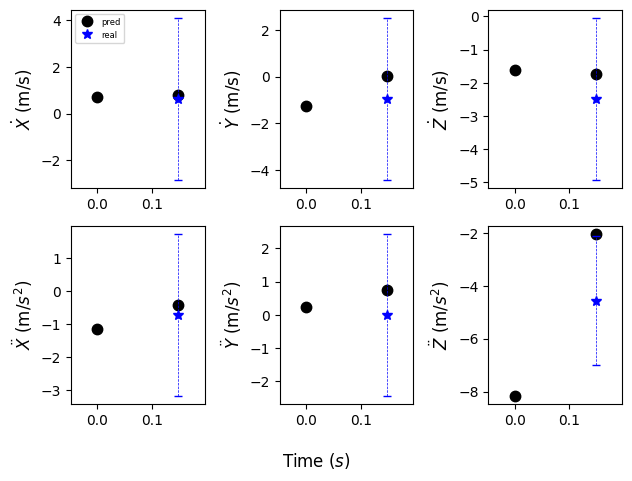

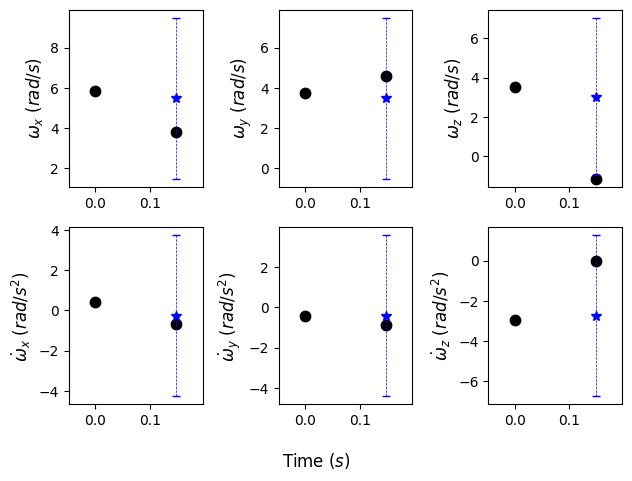

Current Batch Train Loss: -16.36528968811035

Current Batch Train Loss: -16.365413665771484

Current Batch Train Loss: -16.366029739379883

Current Batch Train Loss: -16.367698669433594

Current Batch Train Loss: -16.366437911987305

Current Batch Train Loss: -16.37140464782715

Current Batch Train Loss: -16.376707077026367

Current Batch Train Loss: -16.3761043548584

Current Batch Train Loss: -16.377145767211914

Current Batch Train Loss: -16.37429428100586

Current Batch Train Loss: -16.359296798706055

Current Batch Train Loss: -16.37637710571289

Current Batch Train Loss: -16.38124656677246

Current Batch Train Loss: -16.359081268310547

Current Batch Train Loss: -16.373674392700195

Current Batch Train Loss: -16.371490478515625

Current Batch Train Loss: -16.373199462890625

Current Batch Train Loss: -16.36410903930664

Current Batch Train Loss: -16.38518524169922

Current Batch Train Loss: -16.373281478881836

Current Batch Train Loss: -16.36044692993164

Current Batch Train Los

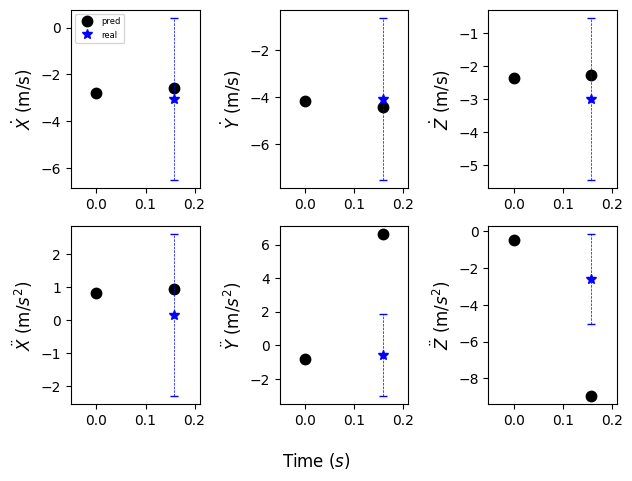

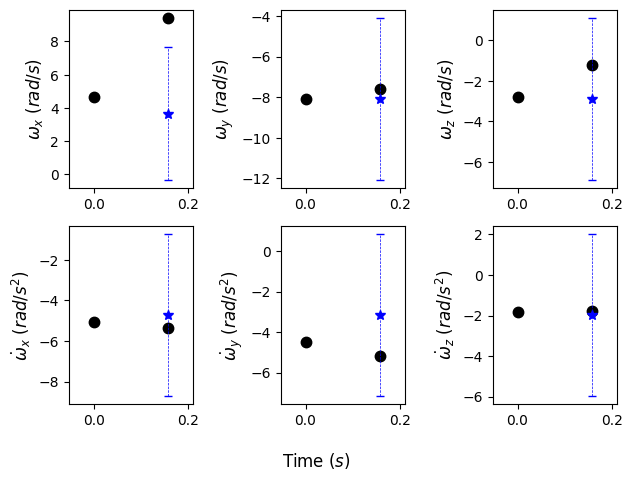

Current Batch Train Loss: -16.381032943725586

Current Batch Train Loss: -16.372684478759766

Current Batch Train Loss: -16.381366729736328

Current Batch Train Loss: -16.358922958374023

Current Batch Train Loss: -16.369935989379883

Current Batch Train Loss: -16.366851806640625

Current Batch Train Loss: -16.382726669311523

Current Batch Train Loss: -16.375818252563477

Current Batch Train Loss: -16.366790771484375

Current Batch Train Loss: -16.375024795532227

Current Batch Train Loss: -16.378400802612305

Current Batch Train Loss: -16.368412017822266

Current Batch Train Loss: -16.37279510498047

Current Batch Train Loss: -16.380794525146484

Current Batch Train Loss: -16.368511199951172

Current Batch Train Loss: -16.380556106567383

Current Batch Train Loss: -16.380062103271484

Current Batch Train Loss: -16.38118553161621

Current Batch Train Loss: -16.369304656982422

Current Batch Train Loss: -16.372020721435547

Current Batch Train Loss: -16.374561309814453

Current Batch T

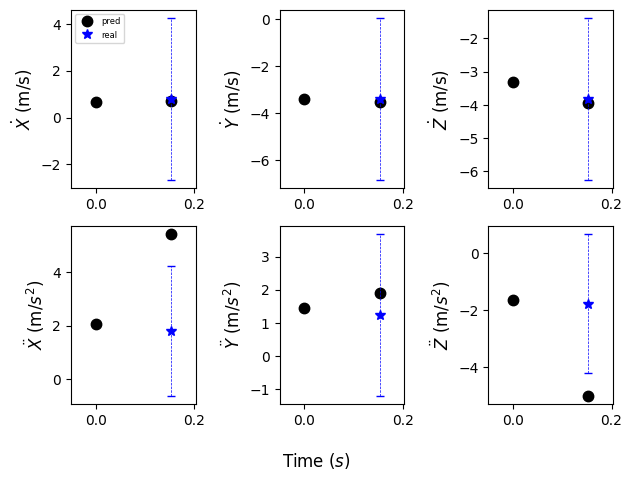

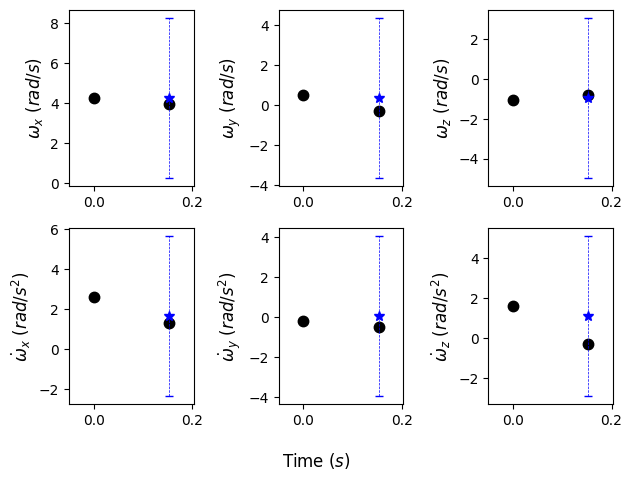

Current Batch Train Loss: -16.383636474609375

Current Batch Train Loss: -16.370460510253906

Current Batch Train Loss: -16.366186141967773

Current Batch Train Loss: -16.368196487426758

Current Batch Train Loss: -16.374446868896484

Current Batch Train Loss: -16.378480911254883

Current Batch Train Loss: -16.36679458618164

Current Batch Train Loss: -16.36910057067871

Current Batch Train Loss: -16.360368728637695

Current Batch Train Loss: -16.37935447692871

Current Batch Train Loss: -16.383573532104492

Current Batch Train Loss: -16.36443328857422

Current Batch Train Loss: -16.390165328979492

Current Batch Train Loss: -16.363506317138672

Current Batch Train Loss: -16.362356185913086

Current Batch Train Loss: -16.375396728515625

Current Batch Train Loss: -16.388683319091797

Current Batch Train Loss: -16.37795639038086

Current Batch Train Loss: -16.38454246520996

Current Batch Train Loss: -16.346782684326172

Current Batch Train Loss: -16.368806838989258

Current Batch Train

KeyboardInterrupt: 

In [28]:
# Initializing LNP model
encoder_input = torch.concat([context_x, context_y], dim=-1)
encoder_size = encoder_input.shape[2]

model = AttLNP(
    encoder_size=encoder_size,
    use_deterministic_path=True,
    rep_transform='mlp',
    att_type='mha',
    x_dim=8,
    y_dim=12
)
#model = torch.load('vel+accel-high-disturbance-mm-noise-model-1370-epochs.pt')

# Initializing model's loss function and optimizer
criterion = LossFunc()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7, amsgrad=True)

# Initializing training + validation loss tracker
train_loss_array = np.array([])
train_iter_array = np.array([])
val_loss_array = np.array([])
val_AAE_array = np.array([])
val_epoch_array = np.linspace(0, NUM_EPOCHS, int(NUM_EPOCHS/PLOT_AFTER)+1)

# Initializing training loop
i = 0
for epoch in range(NUM_EPOCHS+1):

  if epoch % PLOT_AFTER == 0:
    with torch.no_grad():

      # Sampling random validation batch
      idx = random.randint(0, test_dataset.shape[0]-BATCH_SIZE)
      batch_dataset = test_dataset[idx:idx+BATCH_SIZE,:,:]
      input = batch_dataset[:,:,:8]
      output = batch_dataset[:,:,8:]

      # Defining context and target sets
      context_x = input[:,0:1,:].clone()
      context_y = output[:,0:1,:].clone()
      target_x = input.clone()
      target_y = output.clone()

      # Initializing query object for model
      query = ((context_x, context_y), target_x)

      # Collecting predicted outputs + their associated variances + loss info
      # from comparing to ground-truth dynamical data
      log_p, kl, pred_y, var = model(query, target_y, is_testing=True)

      # Collecting loss from prediction
      loss_test = criterion(log_p, kl)

      # Unnormalizing data for plotting and computing AAE
      #context_x, context_y = db.minmax_unnorm(context_x, context_y)
      target_y, pred_y, var = db.minmax_unnorm(target_y, pred_y, var)

      # Computing average absolute error (AAE) over current testing batch
      AE_array = compute_AE(target_y.detach().numpy(), pred_y.detach().numpy())
      test_batch_AAE = np.mean(AE_array)
      test_batch_AAE_std = np.std(AE_array)
      val_AAE_array = np.concatenate([val_AAE_array, np.array([test_batch_AAE])], axis=0)

      # Recording performance after every 'PLOT_AFTER' iterations
      print(f"Epoch: {epoch}, Batch Testing Loss: {loss_test}, Batch Testing Average AE: {test_batch_AAE} w/ Standard Deviation: {test_batch_AAE_std}")

      # Plotting testing GP sample vs the corresponding LNP prediction
      plot_all_functions(context_x,context_y,target_x,target_y, pred_y, var)

      # Collecting validation loss history
      val_loss_array = np.concatenate([val_loss_array, np.array([loss_test])], axis=0)

  # Executing training loop
  for batch in range(0, train_dataset.shape[0], BATCH_SIZE):
    # Parsing batch dataset
    batch_dataset = train_dataset[batch:batch+BATCH_SIZE,:,:]
    input = batch_dataset[:,:,:8]
    output = batch_dataset[:,:,8:]

    # Defining context and target sets
    context_x = input[:,0:1,:].clone()
    context_y = output[:,0:1,:].clone()
    target_x = input.clone()
    target_y = output.clone()

    # generating new batch of functions sampled from GP
    query = ((context_x, context_y), target_x)

    # zero the parameter gradients for each batch
    optimizer.zero_grad()

    # forward + back propogation + optimizer step
    log_p, kl, pred_y, _ = model(query, target_y)
    loss_train = criterion(log_p, kl)
    loss_train.backward()
    optimizer.step()

    # Collecting training loss history after every 'COLLECT_LOSS_AFTER' iters
    if i % COLLECT_TRAINING_LOSS_AFTER == 1:
      print(f"Current Batch Train Loss: {loss_train.item()}\n")
      train_loss_array = np.concatenate([train_loss_array, np.array([loss_train.detach()])], axis=0)
      train_iter_array = np.concatenate([train_iter_array, np.array([i])], axis=0)
    i += 1

  train_dataset = shuffle_data(train_dataset)  

In [33]:
torch.save(model, 'vel+accel-high-disturbance-mm-noise-model-316-epochs.pt')

In [31]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"name: {name}, param.data, {param.data}")

name: latent_encoder_network.to_hidden.weight, param.data, tensor([[ 3.6385e-02, -1.9251e-02,  2.2958e-02,  ...,  2.0466e-01,
          1.0659e-01,  6.3661e-02],
        [ 1.0834e-02, -2.0706e-02, -1.5055e-02,  ..., -1.9737e-03,
         -9.8939e-02,  1.3643e-01],
        [-1.2699e-02,  8.4763e-02, -9.1582e-02,  ...,  2.8470e-02,
          4.4420e-02,  6.1707e-02],
        ...,
        [ 6.2280e-08,  8.3829e-02, -5.0474e-02,  ..., -1.1683e-01,
         -3.7569e-02, -6.5525e-02],
        [-5.9105e-35,  3.1436e-35, -5.7069e-35,  ..., -3.7528e-35,
          4.0594e-35, -2.2607e-35],
        [ 7.9379e-23,  2.2591e-22,  2.4722e-22,  ...,  5.0486e-22,
          5.0118e-22,  5.3991e-22]])
name: latent_encoder_network.to_hidden.bias, param.data, tensor([-1.5558e-01, -8.7763e-02,  4.3586e-02, -1.0823e-02, -4.1696e-02,
         1.4991e-01,  5.9509e-35, -1.4845e-01,  1.5655e-01,  7.5782e-02,
         8.2406e-02,  1.2639e-01,  1.6505e-02,  7.7438e-02,  3.0169e-35,
        -1.5389e-01, -8.6225e-02,

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

writer.add_graph(model, [query, target_y])
writer.close()

In [40]:
loss_array = np.array([])
AAE_array = np.array([])
for batch in range(0, test_dataset.shape[0], BATCH_SIZE):
    
    batch_dataset = test_dataset[batch:batch+BATCH_SIZE,:,:]
    #batch_dataset = minmax_norm(batch_dataset)

    input = batch_dataset[:,:,:17]
    output = batch_dataset[:,:,17:]

    # Defining context and target sets
    context_x = input[:,0:1,:].clone()
    context_y = output[:,0:1,:].clone()
    target_x = input.clone()
    target_y = output.clone()

    # generating new batch of functions sampled from GP
    query = ((context_x, context_y), target_x)

    # Collecting predicted outputs + their associated variances + loss info
    # from comparing to ground-truth dynamical data
    log_p, kl, pred_y, var = model(query, target_y, is_testing=True)

    # Collecting loss from prediction
    num_targets = target_x.shape[1]
    loss_test = criterion(log_p, kl, num_targets)

    # Unnormalizing data for AAE computation
    context_x, context_y = db.minmax_unnorm(context_x, context_y)
    target_x, target_y, pred_y, var = db.minmax_unnorm(target_x, target_y, pred_y, var)

    # Computing average absolute error (AAE) over current testing batch 
    val_batch_AAE = np.mean(compute_AE(target_y.detach().numpy(), pred_y.detach().numpy()))

    # Collecting validation loss and AAE history
    loss_array = np.concatenate([loss_array, np.array([loss_test.detach()])], axis=0)
    AAE_array = np.concatenate([AAE_array, np.array([val_batch_AAE])], axis=0)

print(f"Average Validation Loss Across Batches: {np.mean(loss_array)}, Average Validation AAE Across Batches: {np.mean(AAE_array)}")

Average Validation Loss Across Batches: -4.134170302804911, Average Validation AAE Across Batches: 3.311296629455854


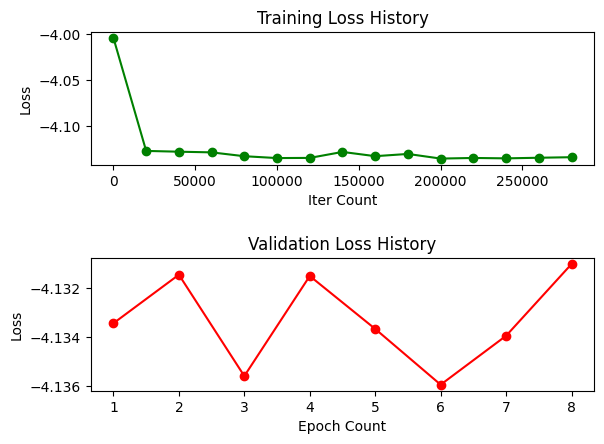

In [37]:
val_epoch_array = np.linspace(0, NUM_EPOCHS, int(NUM_EPOCHS/PLOT_AFTER)+1)

# Plotting both training+testing loss vs iteration
figure, axis = plt.subplots(2,1)
axis[0].plot(train_iter_array[::20], train_loss_array[::20], 'go-')
axis[0].set_xlabel('Iter Count')
axis[0].set_ylabel('Loss')
axis[0].set_title('Training Loss History')

axis[1].plot(np.linspace(1,8,8), val_loss_array[::5], 'ro-')
axis[1].set_xlabel('Epoch Count')
axis[1].set_ylabel('Loss')
axis[1].set_title('Validation Loss History')


figure.tight_layout(pad=2.0)
plt.show()

Text(0.5, 1.0, 'Validation Average Absolute Prediction Error History')

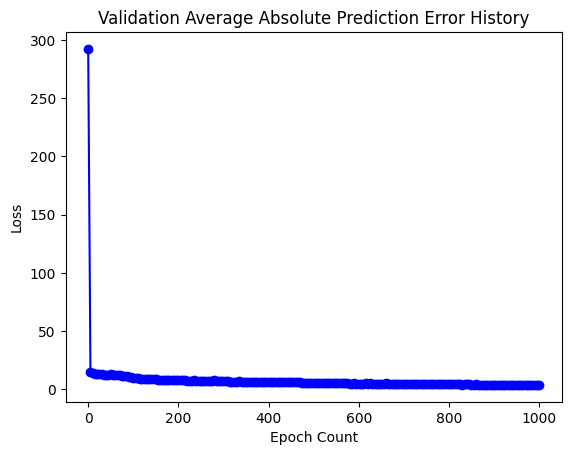

In [18]:
plt.plot(val_epoch_array, val_AAE_array, 'bo-')
plt.xlabel('Epoch Count')
plt.ylabel('Loss')
plt.title('Validation Average Absolute Prediction Error History')

In [21]:
np.save('test_AAE_array_high_disturbance_no_noise.npy', val_AAE_array)

### Evaluation: Predicted Context Mode

In [10]:
xydot_offset=60.0
min_Zdot = -30
max_Zdot = 30
min_accel_xy = -20
max_accel_xy = 20
min_accel_z = -20
max_accel_z = 20 
min_omega=-80
max_omega=80
min_omegadot=-80
max_omegadot=80
wind_vel_offset = 25
min_rotor_rps = 0
max_rotor_rps = 1000

# Defining minmax array for normalization/unnormalization
minmax_data = torch.tensor([[0, 0], #dt
                            [min_rotor_rps, max_rotor_rps],
                            [min_rotor_rps, max_rotor_rps],
                            [min_rotor_rps, max_rotor_rps],
                            [min_rotor_rps, max_rotor_rps],
                            [-wind_vel_offset, wind_vel_offset],
                            [-wind_vel_offset, wind_vel_offset],
                            [-wind_vel_offset, wind_vel_offset],
                            [-xydot_offset, xydot_offset],
                            [-xydot_offset, xydot_offset],
                            [min_Zdot, max_Zdot],
                            [min_accel_xy, max_accel_xy],
                            [min_accel_xy, max_accel_xy],
                            [min_accel_z, max_accel_z],
                            [min_omega, max_omega],
                            [min_omega, max_omega],
                            [min_omega, max_omega],
                            [min_omegadot, max_omegadot],
                            [min_omegadot, max_omegadot],
                            [min_omegadot, max_omegadot]])

In [11]:
def compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(target_y[:,-1,:] - pred_y[:,-1,:])
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array

def scaled_compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  scaled_state_diff = np.abs((target_y[:,-1,:] - pred_y[:,-1,:]) / target_y[:,-1,:]) * 100
  scaled_AE_array = np.mean(scaled_state_diff)

  return scaled_AE_array


In [178]:
l = torch.abs(((target_y[:,-1,:] - pred_y[:,-1,:]) / target_y[:,-1,:])) * 100
l

tensor([[ 13.3240,  32.9785,   1.3692, 133.2717, 662.3981,  65.6425,  45.9764,
         129.6000, 174.0904,  18.5956,  82.5909,  28.4092]],
       grad_fn=<MulBackward0>)

In [179]:
target_y[:,-1,:]

tensor([[ 4.2581, -3.3443, -5.8115,  2.1199, -0.2772, -3.9335, -1.0402, -1.6886,
          0.7284,  1.4303, -0.8567,  3.0325]])

In [180]:
pred_y[:,-1,:]

tensor([[ 3.6908, -2.2414, -5.8911, -0.7053, -2.1134, -6.5156, -0.5620,  0.4998,
          1.9966,  1.1643, -1.5643,  3.8941]], grad_fn=<SliceBackward0>)

In [12]:
test_db = Quadrotor_Dynamics_Generator(normalize=False)
orig_traj = torch.from_numpy(np.load('test_traj_GT.npy'))
test_traj = test_db.convert2new(orig_traj.clone())

In [18]:
Xdot_orig = orig_traj[:,-1,26].detach().numpy()
Xdot_test = test_traj[:,-1,8].detach().numpy()

In [21]:
array3 = np.load('test_traj_xdot_PINN.npy')

(1, 100)

In [29]:
array1 = np.load('test_traj_xdot_AttNP.npy')
array2 = np.load('test_traj_xdot_DKF.npy')

In [30]:
array2.shape

(1, 200)

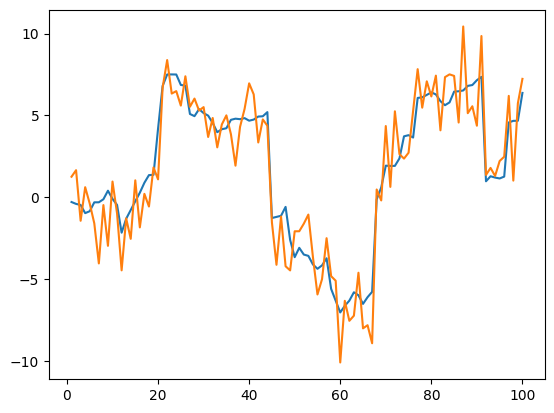

In [24]:
dt = np.linspace(1,Xdot_orig.shape[0],Xdot_orig.shape[0])
plt.plot(dt, Xdot_orig)
plt.plot(dt, array3[0,:])

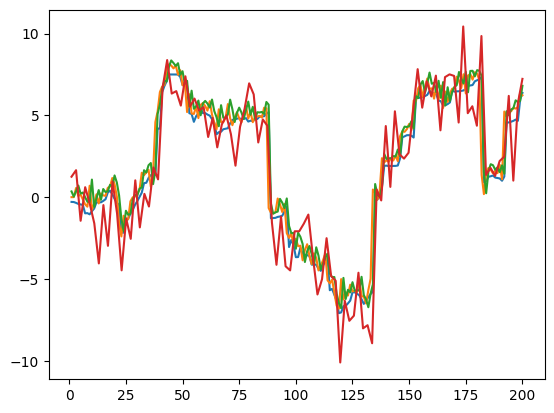

In [34]:
dt1 = np.linspace(1,Xdot_test.shape[0],Xdot_test.shape[0])
dt2 = np.linspace(1,Xdot_test.shape[0],Xdot_orig.shape[0])
plt.plot(dt1, Xdot_test)
plt.plot(dt1, array1[0,:])
plt.plot(dt1, array2[0,:])
plt.plot(dt2, array3[0,:])

Random Trajectory Mode

In [35]:
# Initializing models used in evaluation
model1 = torch.load('vel+accel-high-disturbance-mm-noise-model-316-epochs.pt')
#model2 = torch.load('large-ss-medium-disturbance-medium-noise-model.pt')
#model3 = torch.load('large-ss-slow-vel-low-noise-model.pt')
model_list = [model1]
num_models = len(model_list)

'''
# Initializing quadrotor sensor noise/disturbance parameters
num_perturb_profiles = 1
perturb_params = torch.zeros([num_perturb_profiles,2])
rotor_spike_profile = 100 
wind_vel_array = 10 * torch.ones([3,])
#disturb_quad_at_array = torch.linspace(1,100,num_perturb_profiles)

gps_bias_profile = 1e-2 * np.ones([num_perturb_profiles,]) #np.linspace(0, 0.2, num_perturb_profiles)
gps_std_profile = 1e-1 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,0.6,num_perturb_profiles)
gyro_bias_profile = 1e-3 * np.ones([num_perturb_profiles,]) #np.linspace(0,0.5,num_perturb_profiles)
gyro_std_profile = 1e-5 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,1e-2,num_perturb_profiles)
disturb_quad_at_array = 10   #np.linspace(1,100,num_perturb_profiles)
'''
#perturb_params[:,2] = disturb_quad_at_array

# Initializing quadrotor sensor noise/disturbance parameters
num_perturb_profiles = 1
perturb_params = torch.zeros([num_perturb_profiles,2])
rotor_spike_profile = 100 
wind_vel_array = 10
perturb_params[0,0] = rotor_spike_profile
perturb_params[0,1] = wind_vel_array


# Sampling random trajectory data 
sample_length = 200
test_db = Quadrotor_Dynamics_Generator(normalize=False)
test_traj = torch.from_numpy(np.load('test_traj_GT.npy')) #test_db.generate_test_traj(seq_length=sample_length, perturb_params=perturb_params[0,:], gaussian_noise=True)
test_traj = test_db.convert2new(test_traj.clone())
test_traj = test_db.minmax_norm(test_traj)

print(test_traj.shape)

#test_traj = test_traj.unsqueeze(dim=0)
test_AAE_array = np.zeros([num_models, sample_length])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Initializing array that will contain model predictions
eval_data = torch.zeros([num_models, 3, sample_length, 12])
eval_data[:,0:1,0:1,:] = torch.tile(torch.unsqueeze(test_traj[0:1,0:1,8:], dim=0), dims=[num_models, 1, 1, 1])


# Initializing plotting parameters
Xdot = np.zeros([num_models, sample_length])
Ydot = np.zeros([num_models, sample_length])
Zdot = np.zeros([num_models, sample_length])
ωx = np.zeros([num_models, sample_length])
ωy = np.zeros([num_models, sample_length])
ωz = np.zeros([num_models, sample_length])
Xdot_pred = np.zeros([num_models, sample_length])
Ydot_pred = np.zeros([num_models, sample_length])
Zdot_pred = np.zeros([num_models, sample_length])
ωx_pred = np.zeros([num_models, sample_length])
ωy_pred = np.zeros([num_models, sample_length])
ωz_pred = np.zeros([num_models, sample_length])

Xdot_var = np.zeros([num_models, sample_length])
Ydot_var = np.zeros([num_models, sample_length])
Zdot_var = np.zeros([num_models, sample_length])
ωx_var = np.zeros([num_models, sample_length])
ωy_var = np.zeros([num_models, sample_length])
ωz_var = np.zeros([num_models, sample_length])


# Looping through entire test trajectory
for nn in range(num_models):

  # Setting 'curr_model' to next model in list
  curr_model = model_list[nn]
  
  # Resetting time counter
  curr_time = 0

  # Initializing first context as first state estimate
  next_context = test_traj[0:1,0:1,8:]

  for i in range(1, sample_length):

    curr_sample = test_traj[i:i+1,:,:]
    #curr_sample[:,0:1,8:] = next_context

    curr_dt = curr_sample[:,1:2,0]
    curr_time += curr_dt 
    time_array[i] = curr_time.detach().numpy()

    context_x, context_y = curr_sample[:,0:1,:8], curr_sample[:,0:1,8:]
    target_x, target_y = curr_sample[:,:,:8], curr_sample[:,:,8:]

    query = ((context_x, context_y), target_x)

    pred_y, var = curr_model(query, is_testing=True)

    # Computing AE of current prediction
    target_y, pred_y, var = test_db.minmax_unnorm(target_y, pred_y, var)
    AE_array = compute_AE(target_y.detach().numpy(), pred_y.detach().numpy())
    test_AAE_array[nn, i] = AE_array

    eval_data[nn,0:1,i:i+1,:] = target_y[:,1:2,:]
    eval_data[nn,1:2,i-1:i+1,:] = pred_y
    eval_data[nn,2:3,i-1:i+1,:] = var

    #next_context = test_traj[i:i+1,1:2,8:] #pred_y[:,1:2,:]


  # Unnormalizing true states, their predictions, and associated variances for plotting
  Xdot[nn,:] = eval_data[nn,0,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0]) + minmax_data[8,0]).detach().numpy()
  Ydot[nn,:] = eval_data[nn,0,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0]) + minmax_data[9,0]).detach().numpy()
  Zdot[nn,:] = eval_data[nn,0,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0]) + minmax_data[10,0]).detach().numpy()

  Xdot_pred[nn,:] = eval_data[nn,1,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0]) + minmax_data[8,0]).detach().numpy()
  Ydot_pred[nn,:] = eval_data[nn,1,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0]) + minmax_data[9,0]).detach().numpy()
  Zdot_pred[nn,:] = eval_data[nn,1,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0]) + minmax_data[10,0]).detach().numpy()
  
  ωx[nn,:] = eval_data[nn,0,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy()
  ωy[nn,:] = eval_data[nn,0,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy()
  ωz[nn,:] = eval_data[nn,0,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy()
  
  ωx_pred[nn,:] = eval_data[nn,1,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy()
  ωy_pred[nn,:] = eval_data[nn,1,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy()
  ωz_pred[nn,:] = eval_data[nn,1,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy()
  
  Xdot_var[nn,:] = eval_data[nn,2,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0])).detach().numpy())
  Ydot_var[nn,:] = eval_data[nn,2,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0])).detach().numpy())
  Zdot_var[nn,:] = eval_data[nn,2,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0])).detach().numpy())
  
  ωx_var[nn,:] = eval_data[nn,2,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy())
  ωy_var[nn,:] = eval_data[nn,2,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy())
  ωz_var[nn,:] = eval_data[nn,2,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy())


model_AAE_array = np.mean(test_AAE_array, axis=1)
#print(f"AAE Results\nNo Noise/Disturbance: {model_AAE_array[2]}, Medium Noise/Disturbance: {model_AAE_array[1]}, High Noise/Disturbance: {model_AAE_array[0]}")

torch.Size([200, 2, 20])


/tmp/ipykernel_4164/939517929.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_4164/939517929.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[nn, i] = AE_array


In [36]:
Xdot.shape

(1, 200)

In [37]:
test_traj

tensor([[[ 0.0000,  0.9208,  0.6452,  ...,  0.4861,  0.4891,  0.5571],
         [ 0.0241,  0.0000,  0.0000,  ...,  0.4887,  0.4924,  0.5608]],

        [[ 0.0000,  0.9208,  0.6452,  ..., -0.2824, -1.2923,  9.7782],
         [ 0.0241,  0.0000,  0.0000,  ..., -2.0089, -0.8243,  8.9280]],

        [[ 0.0000,  0.9077,  0.6546,  ..., -1.0854, -1.3162,  9.5086],
         [ 0.1094,  0.0000,  0.0000,  ..., -3.0065,  0.8510,  9.8308]],

        ...,

        [[ 0.0000,  0.9296,  0.6520,  ..., -1.2330, -0.7760, 13.2556],
         [ 0.1329,  0.0000,  0.0000,  ..., -0.6532, -4.6625, 13.0529]],

        [[ 0.0000,  0.9209,  0.6311,  ...,  0.1404, -1.6704,  4.7041],
         [ 0.1734,  0.0000,  0.0000,  ...,  0.1199, -4.2318,  8.5339]],

        [[ 0.0000,  0.9209,  0.6311,  ...,  0.0162, -3.7761,  8.1266],
         [ 0.1734,  0.0000,  0.0000,  ...,  2.4584, -2.5380,  6.6712]]])

In [112]:
perturb_params.shape

torch.Size([1, 2])

In [38]:
model_AAE_array

array([9.67133545])

In [39]:
np.median(test_AAE_array)

8.600651741027832

### Plotting Predictions vs Ground-Truth

In [40]:
# Defining length of plotted trajectories (ensure its <= to sample_length)
plt_idx = 200

In [41]:
# Xdot Arrays
array1 = np.load('test_traj_xdot_AttNP.npy')
array2 = np.load('test_traj_xdot_DKF.npy')
array3 = np.load('test_traj_xdot_PINN.npy')

# Ydot Arrays
array4 = np.load('test_traj_ydot_AttNP.npy')
array5 = np.load('test_traj_ydot_DKF.npy')
array6 = np.load('test_traj_ydot_PINN.npy')

# Zdot Arrays
array7 = np.load('test_traj_zdot_AttNP.npy')
array8 = np.load('test_traj_zdot_DKF.npy')
array9 = np.load('test_traj_zdot_PINN.npy')

# ωx Arrays
array10 = np.load('test_traj_ωx_AttNP.npy')
array11 = np.load('test_traj_ωx_DKF.npy')
array12 = np.load('test_traj_ωx_PINN.npy')

# ωy Arrays
array13 = np.load('test_traj_ωy_AttNP.npy')
array14 = np.load('test_traj_ωy_DKF.npy')
array15 = np.load('test_traj_ωy_PINN.npy')

# ωz Arrays
array16 = np.load('test_traj_ωz_AttNP.npy')
array17 = np.load('test_traj_ωz_DKF.npy')
array18 = np.load('test_traj_ωz_PINN.npy')

# var arrays
array19 = np.load('test_traj_xdot_AttNP_var.npy')
array20 = np.load('test_traj_ydot_AttNP_var.npy')
array21 = np.load('test_traj_zdot_AttNP_var.npy')
array22 = np.load('test_traj_ωx_AttNP_var.npy')
array23 = np.load('test_traj_ωy_AttNP_var.npy')
array24 = np.load('test_traj_ωz_AttNP_var.npy')

In [46]:
time_array_PINN = np.linspace(0,time_array[-1],100)

time_array_PINN

array([ 0.        ,  0.17950675,  0.35901349,  0.53852024,  0.71802698,
        0.89753373,  1.07704047,  1.25654722,  1.43605396,  1.61556071,
        1.79506745,  1.9745742 ,  2.15408094,  2.33358769,  2.51309443,
        2.69260118,  2.87210792,  3.05161467,  3.23112141,  3.41062816,
        3.5901349 ,  3.76964165,  3.94914839,  4.12865514,  4.30816188,
        4.48766863,  4.66717537,  4.84668212,  5.02618886,  5.20569561,
        5.38520235,  5.5647091 ,  5.74421584,  5.92372259,  6.10322933,
        6.28273608,  6.46224282,  6.64174957,  6.82125631,  7.00076306,
        7.1802698 ,  7.35977655,  7.53928329,  7.71879004,  7.89829678,
        8.07780353,  8.25731027,  8.43681702,  8.61632376,  8.79583051,
        8.97533725,  9.154844  ,  9.33435074,  9.51385749,  9.69336423,
        9.87287098, 10.05237772, 10.23188447, 10.41139121, 10.59089796,
       10.7704047 , 10.94991145, 11.12941819, 11.30892494, 11.48843168,
       11.66793843, 11.84744517, 12.02695192, 12.20645866, 12.38

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{X}$ (m/s)'))

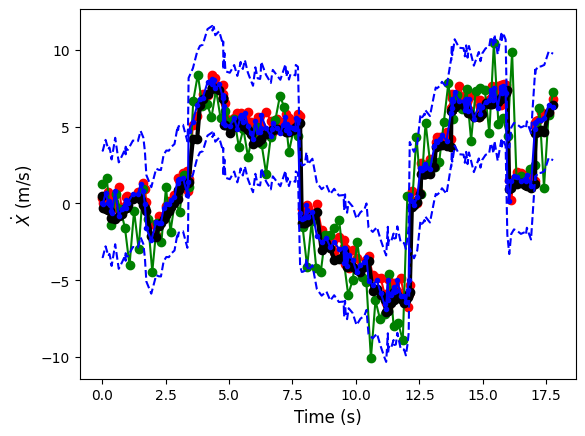

In [47]:
plt.plot(time_array[:plt_idx], array2[0,:plt_idx],'-ro')
plt.plot(time_array_PINN, array3[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], Xdot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Xdot_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], X_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx] - Xdot_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx] + Xdot_var[0,:plt_idx], '--b')


plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{X}$ (m/s)", fontsize=12)
#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{Y}$ (m/s)'))

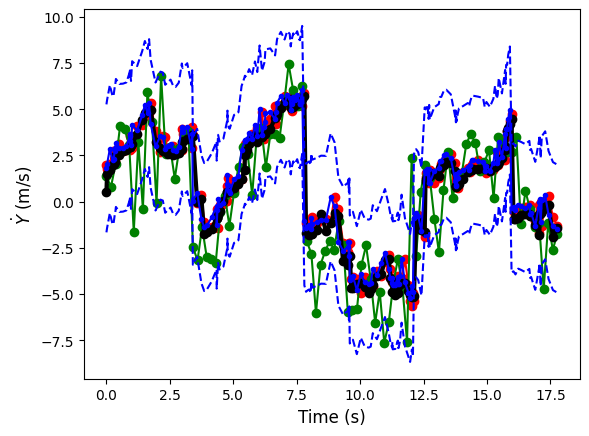

In [48]:
plt.plot(time_array[:plt_idx], array5[0,:plt_idx], '-ro')
plt.plot(time_array_PINN, array6[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], Ydot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Y_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Y_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx] - Ydot_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx] + Ydot_var[0,:plt_idx], '--b')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{Y}$ (m/s)", fontsize=12)
#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{Z}$ (m)'))

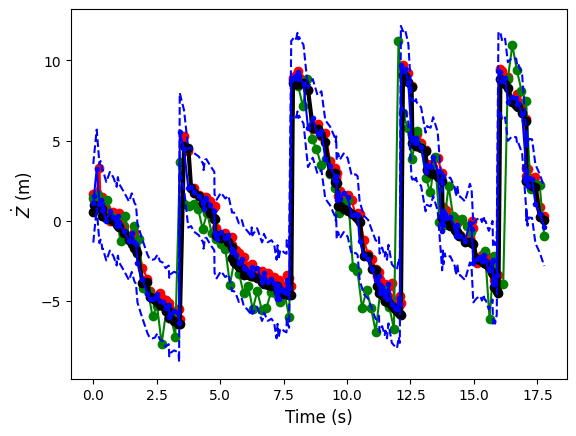

In [49]:
plt.plot(time_array[:plt_idx], array8[0,:plt_idx], '-ro')
plt.plot(time_array_PINN, array9[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], Zdot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx] - Zdot_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx] + Zdot_var[0,:plt_idx], '--b')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{Z}$ (m)", fontsize=12)
#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\omega_{x}$ (rad/s)'))

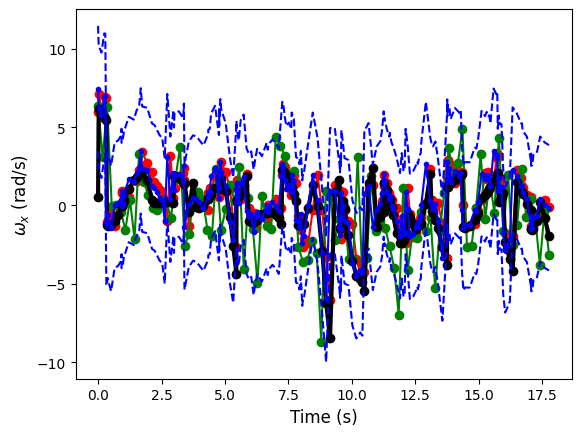

In [50]:
plt.plot(time_array[:plt_idx], array11[0,:plt_idx], '-ro')
plt.plot(time_array_PINN, array12[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], ωx[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx] - ωx_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx] + ωx_var[0,:plt_idx], '--b')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\omega_{x}$ (rad/s)", fontsize=12)
#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
#plt.ylim([-2*pi,2*pi])

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\omega_y$ (rad/s)'))

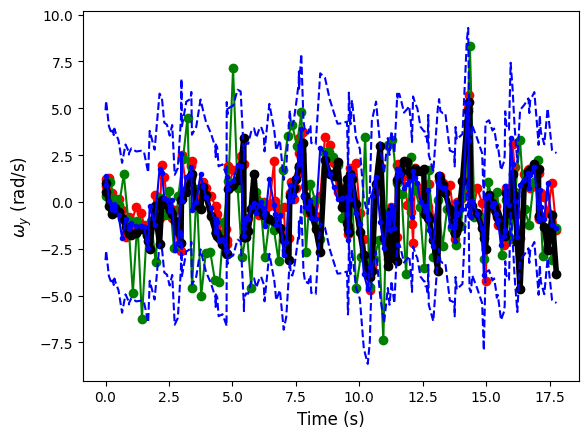

In [51]:
plt.plot(time_array[:plt_idx], array14[0,:plt_idx], '-ro')
plt.plot(time_array_PINN, array15[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], ωy[0,:plt_idx], '-ko', linewidth=4)
plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx], '-bo', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx] - ωy_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx] + ωy_var[0,:plt_idx], '--b')

#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\omega_y$ (rad/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\psi$ (rad)'))

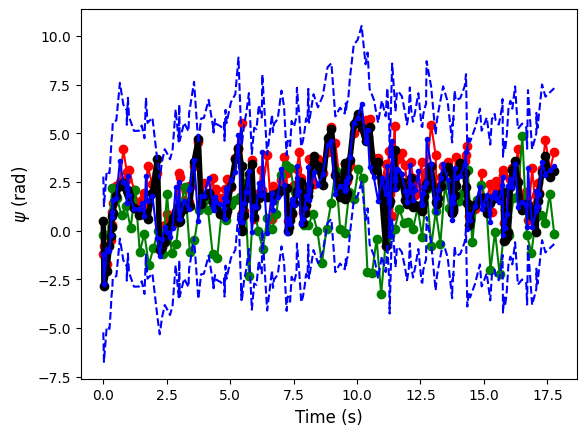

In [52]:
plt.plot(time_array[:plt_idx], array17[0,:plt_idx], '-ro')
plt.plot(time_array_PINN, array18[0,:plt_idx], '-go')
plt.plot(time_array[:plt_idx], ωz[0,:plt_idx], '-ko', linewidth=4)
plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx], '-bo', markersize=3)

plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx] - ωz_var[0,:plt_idx], '--b')
plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx] + ωz_var[0,:plt_idx], '--b')


#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\psi$ (rad)", fontsize=12)

### Noise/Disturbance vs Average Absolute Prediction Error Analysis

In [ ]:
# Initializing quadrotor sensor noise/disturbance parameters
num_perturb_profiles = 100
perturb_params = np.zeros([num_perturb_profiles,6])

rotor_spike_profile = 100 * np.ones([num_perturb_profiles,])  
gps_bias_profile = 1e-5 * np.ones([num_perturb_profiles,])                          
gps_std_profile = 1e-5 * np.ones([num_perturb_profiles,])                         
gyro_bias_profile = 1e-5 * np.ones([num_perturb_profiles,])     
gyro_std_profile = 1e-5 * np.ones([num_perturb_profiles,])      
disturb_quad_at_max_iter = np.linspace(1,100,num_perturb_profiles)                

perturb_params[:,0] = rotor_spike_profile
perturb_params[:,1] = gps_bias_profile
perturb_params[:,2] = gps_std_profile
perturb_params[:,3] = gyro_bias_profile
perturb_params[:,4] = gyro_std_profile
perturb_params[:,5] = disturb_quad_at_max_iter

In [14]:
# Initializing quadrotor sensor noise/disturbance parameters
num_perturb_profiles = 100
perturb_params = np.zeros([num_perturb_profiles,6])

rotor_spike_profile = np.linspace(0,100,num_perturb_profiles)
gps_bias_profile = np.linspace(0, 0.2, num_perturb_profiles) 
gps_std_profile = np.linspace(1e-5,0.6,num_perturb_profiles)  
gyro_bias_profile = np.linspace(0,0.5,num_perturb_profiles)    
gyro_std_profile = np.linspace(1e-5,1e-2,num_perturb_profiles)   
disturb_quad_at_max_iter = 50 * np.ones([num_perturb_profiles])    

perturb_params[:,0] = rotor_spike_profile
perturb_params[:,1] = gps_bias_profile
perturb_params[:,2] = gps_std_profile
perturb_params[:,3] = gyro_bias_profile
perturb_params[:,4] = gyro_std_profile
perturb_params[:,5] = disturb_quad_at_max_iter

In [17]:
# Initializing models used in evaluation
model1 = torch.load('vel+accel-high-disturbance-mm-noise-model-316-epochs.pt')
#model2 = torch.load('large-ss-medium-disturbance-medium-noise-model.pt')
#model3 = torch.load('large-ss-slow-vel-low-noise-model.pt')
model_list = [model1]
num_models = len(model_list)

'''
# Initializing quadrotor sensor noise/disturbance parameters
num_perturb_profiles = 1
perturb_params = torch.zeros([num_perturb_profiles,2])
rotor_spike_profile = 100 
wind_vel_array = 10 * torch.ones([3,])
#disturb_quad_at_array = torch.linspace(1,100,num_perturb_profiles)

gps_bias_profile = 1e-2 * np.ones([num_perturb_profiles,]) #np.linspace(0, 0.2, num_perturb_profiles)
gps_std_profile = 1e-1 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,0.6,num_perturb_profiles)
gyro_bias_profile = 1e-3 * np.ones([num_perturb_profiles,]) #np.linspace(0,0.5,num_perturb_profiles)
gyro_std_profile = 1e-5 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,1e-2,num_perturb_profiles)
disturb_quad_at_array = 10   #np.linspace(1,100,num_perturb_profiles)
'''
#perturb_params[:,2] = disturb_quad_at_array

# Initializing quadrotor sensor noise/disturbance parameters
num_perturb_profiles = 100
perturb_params = torch.zeros([num_perturb_profiles,2])
rotor_spike_profile = torch.linspace(1, 100, num_perturb_profiles)
wind_vel_array = torch.linspace(0, 20, 100)
perturb_params[:,0] = rotor_spike_profile
perturb_params[:,1] = wind_vel_array


# Sampling random trajectory data 
sample_length = 10
num_trajs = 20
test_db = Quadrotor_Dynamics_Generator(normalize=False)

#test_traj = test_traj.unsqueeze(dim=0)
test_AAE_array = np.zeros([num_perturb_profiles, sample_length*num_trajs])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Initializing array that will contain model predictions
#eval_data = torch.zeros([num_models, 3, sample_length, 12])
#eval_data[:,0:1,0:1,:] = torch.tile(torch.unsqueeze(test_traj[0:1,0:1,8:], dim=0), dims=[num_models, 1, 1, 1])


# Looping through entire test trajectory
for profile in range(num_perturb_profiles):
    
    params = perturb_params[profile,:]
    
    count = 0
    for traj in range(num_trajs):
        
        # Sampling random trajectory data 
        test_traj = test_db.generate_test_traj(seq_length=sample_length, perturb_params=params, gaussian_noise=True)
        test_traj = test_db.convert2new(test_traj.clone())
        test_traj = test_db.minmax_norm(test_traj)

        # Setting 'curr_model' to next model in list
        #curr_model = model_list[nn]
        
        # Resetting time counter
        curr_time = 0

        # Initializing first context as first state estimate
        next_context = test_traj[0:1,0:1,8:]

        for i in range(sample_length):

            curr_sample = test_traj[i:i+1,:,:]
            #curr_sample[:,0:1,8:] = next_context

            curr_dt = curr_sample[:,1:2,0]
            curr_time += curr_dt 
            time_array[i] = curr_time.detach().numpy()

            context_x, context_y = curr_sample[:,0:1,:8], curr_sample[:,0:1,8:]
            target_x, target_y = curr_sample[:,:,:8], curr_sample[:,:,8:]

            query = ((context_x, context_y), target_x)

            pred_y, var = model1(query, is_testing=True)

            # Computing AE of current prediction
            target_y, pred_y, var = test_db.minmax_unnorm(target_y, pred_y, var)
            AE_array = compute_AE(target_y.detach().numpy(), pred_y.detach().numpy())
            test_AAE_array[profile, count] = AE_array
            count += 1

#model_AAE_array = np.mean(test_AAE_array, axis=1)
#print(f"AAE Results\nNo Noise/Disturbance: {model_AAE_array[2]}, Medium Noise/Disturbance: {model_AAE_array[1]}, High Noise/Disturbance: {model_AAE_array[0]}")

/tmp/ipykernel_13343/3335487428.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_13343/3335487428.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[profile, count] = AE_array


In [18]:
np.mean(test_AAE_array,axis=1)

array([ 9.47803514,  8.43855781,  9.78002148,  8.45754211, 10.4011199 ,
        9.46036253,  9.49295514,  9.27132444,  9.1478205 ,  9.90473318,
        9.79656054, 10.04462534,  9.12186938,  9.22756675,  9.43313164,
        9.57361686,  8.41979598,  9.89835517,  8.95401459,  9.62172711,
       10.15827875,  9.60077703,  9.84485853,  8.37383838,  8.76381132,
        9.59002005,  9.45282513,  9.01073483,  9.28379433, 10.11990787,
       10.58350311,  9.42561708,  8.52366472,  9.92000525,  9.21718842,
        9.71431461,  8.85023931,  9.49256504,  7.78596315,  8.699381  ,
        9.67324822,  8.74340161,  9.46380642,  9.82824243,  9.91491097,
        9.61289094,  9.40257409,  8.59552098,  9.79862339,  9.97120275,
        9.45316273,  9.82423223,  8.39495671,  9.06405284, 10.03741307,
        9.3021168 ,  8.95054559,  9.72082105,  9.08991721,  8.81172235,
        9.96009723,  7.63711923,  9.45445781,  8.43655972,  8.34080045,
       10.33028547, 10.13546043,  9.46788909,  8.47840956,  9.67

In [20]:
perturb_AAE_array = np.mean(test_AAE_array,axis=1)
np.save('AttNP-AAE-Perturb-array.npy', perturb_AAE_array)

In [ ]:
PINN_results = np.load('perturbation_level_eval_PINN.npy')

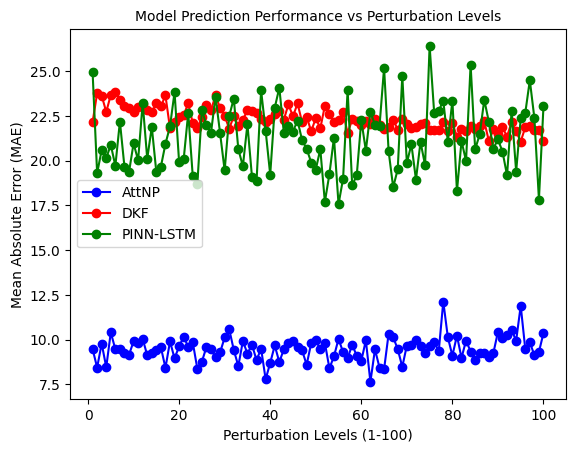

In [23]:
disturb_quad_at_array = np.linspace(1,100,num_perturb_profiles)

AttNP_AAE_array = np.load('AttNP-AAE-Perturb-array.npy')
DKF_AAE_array = np.load('DKF-AAE-Perturb-array.npy')
PINN_LSTM_AAE_array = np.load('LSTM-PINN-AAE-Perturb-array.npy')

plt.plot(disturb_quad_at_array, AttNP_AAE_array, '-bo')
plt.plot(disturb_quad_at_array, DKF_AAE_array, '-ro')
plt.plot(disturb_quad_at_array, PINN_LSTM_AAE_array, '-go')
plt.xlabel('Perturbation Levels (1-100)', fontsize=10), plt.ylabel('Mean Absolute Error (MAE)')
#plt.xticks(perturb_level_array)
plt.title('Model Prediction Performance vs Perturbation Levels', fontsize=10)
plt.legend(['AttNP','DKF','PINN-LSTM'], loc='best')
#plt.savefig()
